# BiAge

## Imports

In [1]:
import datetime
import os
from tqdm import tqdm
import h5py

import pandas as pd
import numpy as np

import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import torch
from torch import nn
import torch.utils.data as data
import lightning as pl

from matplotlib import gridspec
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
import matplotlib.font_manager as font_manager
import seaborn as sns

pingouin_available = False
statannotations_available = False

try:
    import pingouin as pg

    pingouin_available = True
    print("Using pingouin package for partial correlations")
except:
    pingouin_available = False

try:
    from statannotations.Annotator import Annotator

    statannotations_available = True
    print("Using statannotations package for boxplot star annotations")
except:
    statannotations_available = False

Using pingouin package for partial correlations
Using statannotations package for boxplot star annotations


## Define graphic parameters and declare functions used to plot figures

In [2]:
try:
    mpl.colormaps.unregister("mg_custom_cmap")
except:
    pass
mpl.colormaps.register(cmap=ListedColormap(["#eaecee", "#aed6f1", "#7393B3", "#17202a"], name="mg_custom_cmap"))

# graphical parameters, for article figures:
pp_size = 6
legend_font_params = font_manager.FontProperties(family='Calibri',
                                                 weight='normal',
                                                 style='normal',
                                                 size=24)
paneltitle_font_params = font_manager.FontProperties(family='Calibri',
                                                     weight='bold',
                                                     style='normal',
                                                     size=24)
labels_font_params = {"fontname": "Calibri", "fontweight": "normal", "fontsize": 24}
ticks_font_params = {'family': 'Calibri', 'weight': 'normal', 'size': 22}
scatter_plot_size = 120
boxplot_mean_marker_size = 10
boxplot_lw = 4.0
boxplot_precise_lw = 1.0
boxplot_props = {
    'flierprops': {"markersize": boxplot_mean_marker_size},
    'meanprops': {"marker": "X", "markeredgecolor": "#333333", "markerfacecolor": "#333333", "markersize": boxplot_mean_marker_size}}

rcParams['axes.facecolor'] = 'white'
# rcParams['axes.edgecolor'] = 'black'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'Calibri:italic'
rcParams['mathtext.rm'] = 'Calibri'
rcParams['mathtext.bf'] = 'Calibri:bold'
rc_params = {'font.size': 16, }
plt.rcParams.update(rc_params)

# quick function to do regression plot
def plot_lm(x, y, group_name, xlabel, ylabel, xticks=None, yticks=None, show_grid: bool = True,
            correlation_method=("spearman", "pearson")[1],
            n_xticks: int = 7, n_yticks: int = 7, suptitle: str = None,
            scatter_plot_custom_size: float = scatter_plot_size, scatter_kws_custom_alpha: float = 0.5,
            text_show: bool = True, text_show_sample_size: bool = True, text_bbox_alpha: float = .0, text_pos: str = "top left",
            verticalalignment=None, horizontalalignment=None,
            common_scale: bool = False, no_lm: bool = False,
            console_print_pr: bool = False,
            confidence_level: float = None):
    from scipy import stats
    from sklearn.linear_model import LinearRegression

    x = x.to_numpy() if type(x) is pd.Series else x
    x = np.array(x) if type(x) in (list, tuple) else x
    y = y.to_numpy() if type(y) is pd.Series else y
    y = np.array(y) if type(y) in (list, tuple) else y
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    xymin, xymax = min(x.min(), y.min()), max(x.max(), y.max())
    xyrange = xymax - xymin
    xrange, yrange = xmax - xmin, ymax - ymin
    if correlation_method == "pearson":
        # r, p = scipy.stats.pearsonr(x=x, y=y)
        cor_method = stats.pearsonr
    elif correlation_method == "spearman":
        # r, p = scipy.stats.spearmanr(a=x, b=y)
        cor_method = stats.spearmanr
    else:
        assert False, f"Unsupported {correlation_method=}"
    r, p = cor_method(x, y)
    if confidence_level is not None:
        assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
        bts_results = stats.bootstrap((x, y), cor_method, paired=True, n_resamples=9999, confidence_level=confidence_level, random_state=1)
        r_lo = bts_results.confidence_interval[0][0]
        r_hi = bts_results.confidence_interval[1][0]
    else:
        r_lo, r_hi = None, None

    lm = LinearRegression()
    lm.fit(X=x.reshape(-1, 1), y=y.reshape(-1, 1))
    # slope, intercept = lm.coef_[0][0], lm.intercept_[0]
    if common_scale:
        xmin, xmax, xrange, ymin, ymax, yrange = xymin, xymax, xyrange, xymin, xymax, xyrange
        ax = sns.lineplot(x=[0, xymax], y=[0, xymax], linestyle='--', color="#aaaaaa")
        scatter_kws = {"color": "black", "alpha": scatter_kws_custom_alpha, "s": scatter_plot_custom_size}
        if no_lm:
            sns.scatterplot(x=x, y=y, **scatter_kws, ax=ax)
        else:
            sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={"color": "red"}, ax=ax)
    else:
        scatter_kws = {"color": "black", "alpha": scatter_kws_custom_alpha, "s": scatter_plot_custom_size}
        if no_lm:
            ax = sns.scatterplot(x=x, y=y, **scatter_kws)
        else:
            ax = sns.regplot(x=x, y=y, scatter_kws=scatter_kws, line_kws={"color": "red"})
    # reset ymin, max, etc. based on xticks yticks
    if (xticks is not None) and (len(xticks) > 0):
        xmin = min(xmin, min(xticks))
        xmax = max(xmax, max(xticks))
    if (yticks is not None) and (len(yticks) > 0):
        ymin = min(ymin, min(yticks))
        ymax = max(ymax, max(yticks))
    xrange = xmax - xmin
    yrange = ymax - ymin
    if text_pos.split(" ")[0] == "top":
        text_y = ymin + yrange * .98
        if verticalalignment is None:
            verticalalignment = "top"
    else:
        text_y = ymin + yrange * .02
        if verticalalignment is None:
            verticalalignment = "bottom"
    if text_pos.split(" ")[1] == "left":
        text_x = xmin + xrange * .02
        if horizontalalignment is None:
            horizontalalignment = "left"
    else:
        text_x = xmax - xrange * .02
        if horizontalalignment is None:
            horizontalalignment = "right"
    if text_show:
        if no_lm and text_show_sample_size:
            if (group_name is not None) and (len(group_name) > 0):
                lm_text = f'{group_name}: '
            else:
                lm_text = ""
            lm_text += r'$\it{n}$' + f' = {len(x)}'
        elif (not no_lm) and text_show_sample_size:
            if (group_name is not None) and (len(group_name) > 0):
                lm_text = f'{group_name}: '
            else:
                lm_text = ""
            lm_text += r'$\it{n}$' + f' = {len(x)}' + '\n' + r"$\it{r}$" + f' = {r:.2f}'
            if confidence_level is not None:
                lm_text += f" ({r_lo:.2f}, {r_hi:.2f})"
        elif (not no_lm) and (not text_show_sample_size):
            lm_text = (r"$\it{r}$" + f' = {r:.2f}')
            if confidence_level is not None:
                lm_text += f" ({r_lo:.2f}, {r_hi:.2f})"
        else:
            lm_text = ""
            text_show = False
        if text_show:
            plt.text(text_x, text_y,
                     # '\n' + '$\it{slope} = $' + f'{slope:.1f}' + ', $\it{intercept} = $' + f'{intercept:.1f}' +
                     lm_text,
                     verticalalignment=verticalalignment,
                     horizontalalignment=horizontalalignment,
                     font=legend_font_params,
                     bbox=dict(facecolor='white', alpha=text_bbox_alpha) if text_bbox_alpha > 0 else None)
    if common_scale:
        plt.xlim(xymin, xymax)
        plt.ylim(xymin, xymax)
    if xticks is not None:
        plt.xticks(xticks)
    else:
        plt.locator_params(axis='x', nbins=n_xticks)
    xticks = ax.get_xticks()
    if (xticks % 1 == 0).all():
        xticks = xticks.astype(int)
    round_yticks = False
    if yticks is not None:
        plt.yticks(yticks)
    else:
        round_yticks = True
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    elif round_yticks:
        # round intelligently
        n_decimalzeros = np.ceil(-np.log10((np.max(yticks) - np.min(yticks)) / 100))
        yticks = np.round(yticks, n_decimalzeros)
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if show_grid:
        plt.grid(color='#aaaaaa', linewidth=0.5)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    if console_print_pr:
        print(f"r={r:.2f}, p={p:.1g}")
    return ax


# quick function to do regression
def plot_box(x, y, hue, xlabel, ylabel, yticks=None, n_yticks: int = 5, showmeans: bool = True, suptitle: str = None,
             legend_loc: str = None, legend_off: bool = False,
             data=None, palette=None,
             show_grid: bool = True,
             subtype="boxplot",
             swarmsize=None,
             display_n_obs=True,
             ax=None):
    # the actual box plot
    # ax = None
    if subtype == "boxplot":
        ax = sns.boxplot(data=data, x=x, y=y, hue=hue,
                         ax=ax,
                         palette=palette,
                         linewidth=boxplot_lw,
                         notch=False,
                         # saturation=1.,
                         **boxplot_props,
                         showmeans=showmeans)
    elif subtype == "violinplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
    elif subtype == "precise_violinplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_precise_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
    elif subtype == "precise_violinplot+swarmplot":
        ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
                            ax=ax,
                            palette=palette,
                            linewidth=boxplot_precise_lw,
                            # **boxplot_props,
                            # showmeans=showmeans,
                            )
        sns.swarmplot(data=data, x=x, y=y, hue=hue,
                      ax=ax,
                      dodge=True,
                      color="#999999",
                      alpha=.9,
                      # color="black",
                      # alpha=.5,
                      # palette=palette,
                      legend=False,
                      size=1 if swarmsize is None else swarmsize,
                      )
    elif subtype == "stripplot":
        ax = sns.stripplot(data=data, x=x, y=y, hue=hue,
                           ax=ax,
                           palette=palette,
                           # linewidth=boxplot_lw,
                           # saturation=1.,
                           # **boxplot_props,
                           # showmeans=showmeans,
                           )
    elif subtype == "swarmplot":
        ax = sns.swarmplot(data=data, x=x, y=y, hue=hue,
                           ax=ax,
                           dodge=True,
                           palette=palette,
                           size=1,
                           # linewidth=boxplot_lw,
                           # saturation=1.,
                           # **boxplot_props,
                           # showmeans=showmeans,
                           )
    else:
        assert False, f"Unknown {subtype=}"
    # ticks and labels
    if yticks is not None:
        plt.yticks(yticks)
    else:
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    xticks = ax.get_xticks()
    if (data is not None) and (type(x) is str):
        if data[x].dtype.name == "category":
            xticks = [data[x].cat.categories[v] for v in xticks]
    elif type(x) is pd.Series:
        if x.dtype.name == "category":
            xticks = [x.cat.categories[v] for v in xticks]
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    # grid
    if show_grid:
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='#aaaaaa', linewidth=0.5)
        # plt.grid(axis="y", color='#aaaaaa', linewidth=0.5)
    # display n
    if display_n_obs:
        # assert hue is None, "Cannot compute text for n_obs if hue is not None!"
        assert data is not None, "Cannot compute text for n_obs if data is None!"
        # medians = data.groupby([x])[y].median().values
        ylo, yhi = ax.get_ylim()
        y0pos = ylo + (yhi - ylo) * .01
        if hue is None:
            # nobs = boxplot_kwargs["data"][boxplot_kwargs["x"]].value_counts().values
            nobs = data[x].value_counts().values
            nobs = [str(x) for x in nobs.tolist()]
            nobs = ["n=" + i for i in nobs]
        else:
            nobs = []
            # for x_possible_value in list(boxplot_kwargs["data"][boxplot_kwargs["x"]].cat.categories):
            #     n_by_hue = []
            #     for hue_possible_value in list(boxplot_kwargs["data"][boxplot_kwargs["hue"]].cat.categories):
            #         n_here = ((boxplot_kwargs["data"][boxplot_kwargs["x"]] == x_possible_value) & (boxplot_kwargs["data"][boxplot_kwargs["hue"]] == hue_possible_value)).sum()
            #         n_by_hue.append(n_here)
            #     nobs.append(n_by_hue)
            for x_possible_value in list(data[x].cat.categories):
                n_by_hue = []
                for hue_possible_value in list(data[hue].cat.categories):
                    n_here = ((data[x] == x_possible_value) & (data[hue] == hue_possible_value)).sum()
                    n_by_hue.append(n_here)
                nobs.append(n_by_hue)
            nobs = [["n=" + str(x) for x in xlist] for xlist in nobs]

        pos = range(len(nobs))
        for tick, label in zip(pos, ax.get_xticklabels()):
            if type(nobs[tick]) is list:
                hueobs = nobs[tick]
                space_between_ticks = 1 / (len(hueobs) + 1)
                ticks_range = (len(hueobs) - 1) * space_between_ticks
                tick_start = 0 - (ticks_range / 2)
                for ti, nobs_hue in enumerate(hueobs):
                    ax.text(pos[tick] + tick_start + ti * space_between_ticks,
                            # medians[tick] + 0.03,
                            y0pos,
                            nobs_hue,
                            horizontalalignment='center',
                            size='x-small',
                            color='black', )
            else:
                ax.text(pos[tick],
                        # medians[tick] + 0.03,
                        y0pos,
                        nobs[tick],
                        horizontalalignment='center',
                        size='x-small',
                        color='black', )
    # legend
    if not legend_off:
        if legend_loc == "outside":
            ax.legend(prop=legend_font_params, bbox_to_anchor=(1.04, 0.5), loc="center left")
        else:
            ax.legend(prop=legend_font_params, loc=legend_loc)
    return ax


def plot_roc(y, y_, suptitle: str = None, display_n: bool = False, text_bbox_alpha: float = .0, confidence_level: float = None):
    if confidence_level is not None:
        # using confidenceinterval
        import confidenceinterval

        assert (confidence_level > 0) and (confidence_level < 1), f"Unexpected {confidence_level=}"

        t = np.concatenate([[np.Inf, ], np.sort(np.unique(y_))[::-1]])
        tpr, tpr_lo, tpr_hi, fpr, fpr_lo, fpr_hi = [], [], [], [], [], []
        for thresh in t:
            thresh_tpr, (thresh_tpr_lo, thresh_tpr_hi) = confidenceinterval.tpr_score(y, (y_ >= thresh) * 1, confidence_level=confidence_level)
            thresh_fpr, (thresh_fpr_lo, thresh_fpr_hi) = confidenceinterval.fpr_score(y, (y_ >= thresh) * 1, confidence_level=confidence_level)
            tpr.append(thresh_tpr)
            tpr_lo.append(thresh_tpr_lo)
            tpr_hi.append(thresh_tpr_hi)
            fpr.append(thresh_fpr)
            fpr_lo.append(thresh_fpr_lo)
            fpr_hi.append(thresh_fpr_hi)
        tpr, tpr_lo, tpr_hi, fpr, fpr_lo, fpr_hi = np.array(tpr), np.array(tpr_lo), np.array(tpr_hi), np.array(fpr), np.array(fpr_lo), np.array(fpr_hi)

        roc_auc, (roc_auc_lo, roc_auc_hi) = confidenceinterval.roc_auc_score(y, y_, confidence_level=confidence_level)

    else:
        # using sklearn
        from sklearn import metrics

        fpr, tpr, t = metrics.roc_curve(y, y_)
        tpr_lo, tpr_hi, fpr_lo, fpr_hi = None, None, None, None
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_lo, roc_auc_hi = None, None

    # confidenceinterval.roc_auc_score(y_true=balanced_df["Binary race"], y_pred=balanced_df[peak_method])

    # Plot curve
    plt.plot([0, 1], [0, 1], color='#aaaaaa', lw=2, linestyle='--')

    if confidence_level is not None:
        plt.fill_between(x=fpr, y1=tpr_lo, y2=tpr_hi, color='black', alpha=.1)
        plt.plot(fpr, tpr, color='black', lw=2, label=f'AUC={roc_auc:0.2f} ({roc_auc_lo:0.2f}-{roc_auc_hi:0.2f})')
    else:
        plt.plot(fpr, tpr, color='black', lw=2, label=f'AUC={roc_auc:0.2f}')

    if display_n:
        plt.text(.05, .95,
                 '$\it{n}$' + f' = {len(y)}',
                 verticalalignment="top",
                 horizontalalignment="left",
                 font=legend_font_params,
                 bbox=dict(facecolor='white', alpha=text_bbox_alpha) if text_bbox_alpha > 0 else None)

    # Set boundaries, labels, titles...
    plt.xlim([0., 1.])
    plt.ylim([0., 1.])

    ax = plt.gca()
    xticks = np.round(100 * ax.get_xticks(), 0).astype(int)
    yticks = np.round(100 * ax.get_yticks(), 0).astype(int)
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)

    plt.xlabel('False Positive Rate', **labels_font_params)
    plt.ylabel('True Positive Rate', **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
        # plt.title(suptitle)
    plt.legend(loc="lower right")
    plt.tight_layout()
    return ax


# quick function to do regression
def plot_paired_box(data, x, y, xlabel, ylabel, yticks=None, n_yticks: int = 7, showmeans: bool = False, suptitle: str = None,
                    legend_loc: str = None, legend_off: bool = False, palette=None, points_palette=None):
    # the actual box plot
    ax = sns.boxplot(data=data, x=x, y=y,
                     palette=palette,
                     linewidth=boxplot_lw,
                     notch=False,
                     # saturation=1.,
                     **boxplot_props,
                     showmeans=showmeans)
    scatter_kws = {"alpha": 1.0, "s": scatter_plot_size}
    sns.scatterplot(data=data, x=x, y=y, ax=ax, **scatter_kws, palette=points_palette, hue=x)
    x1, x2 = data[x].unique()
    for y1, y2 in zip(data[data[x] == x1][y].tolist(), data[data[x] == x2][y].tolist()):
        lcolor = "#ff0000" if y2 > y1 else "#0000ff"
        sns.lineplot(x=[x1, x2], y=[y1, y2], ax=ax, color=lcolor)
    # ticks and labels
    if yticks is not None:
        plt.yticks(yticks)
    else:
        plt.locator_params(axis='y', nbins=n_yticks)
    yticks = ax.get_yticks()
    if (yticks % 1 == 0).all():
        yticks = yticks.astype(int)
    xticks = ax.get_xticks()
    if (data is not None) and (type(x) is str):
        if data[x].dtype.name == "category":
            xticks = [data[x].cat.categories[v] for v in xticks]
    elif type(x) is pd.Series:
        if x.dtype.name == "category":
            xticks = [x.cat.categories[v] for v in xticks]
    ax.set_xticklabels(xticks, fontdict=ticks_font_params)
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    plt.ylabel(ylabel, **labels_font_params)
    plt.xlabel(xlabel, **labels_font_params)
    if suptitle is not None:
        plt.title(suptitle, loc='left', font=paneltitle_font_params)
    # legend
    if not legend_off:
        if legend_loc == "outside":
            ax.legend(prop=legend_font_params, bbox_to_anchor=(1.04, 0.5), loc="center left")
        else:
            ax.legend(prop=legend_font_params, loc=legend_loc)
    else:
        ax.legend_.remove()
    return ax

Set dataset path

In [3]:
dataset_dir = None

for dropbox_path in [r"C:\Users\flori\Dropbox (Partners HealthCare)", r"C:\Users\f.chabrun\Partners HealthCare Dropbox\Floris Chabrun"]:
    if os.path.exists(dropbox_path):
        print(f"Found DROPBOX folder")
        checkpoint_path = os.path.join(dropbox_path, r"Floris\SPECTR-MS\out\checkpoints", r"v92_age_v2\age_v2_base_batch_size_32",
                                       "epoch=33-step=8466.ckpt")
        dataset_dir = os.path.join(dropbox_path, 'Floris/SPECTR-MS/data/v9.0/dataset')
        break

Found DROPBOX folder


Set various parameters that will be used for deep learning analysis (e.g. input size, batch size, etc.)

In [4]:
input_dim = 1536
batch_size = 32
training_coarse_dropout = {
    "n_binom_n": 10,
    "n_binom_p": 0.5,
    "width_binom_n": 200,
    "width_binom_p": 0.5
}
prediction_target = "AGE"

Load dataset, and pre-process: filter out samples not passing QC, perform some statistics

In [5]:
dataset = pd.DataFrame(pd.read_hdf(os.path.join(dataset_dir, "dataset_final.h5"), key="dataset"))
dataset_backup = dataset.copy()
print(f"Loaded dataset with {dataset.shape=}")

dataset = dataset.loc[dataset.QC_MSRAW_Data_Available, :]
print(f"    > Filtered to {dataset.shape=} after removing missing/invalid MS data")
dataset = dataset.loc[~dataset.QC_MS_Noise_Filter_Triggered, :]
print(f"    > Filtered to {dataset.shape=} after removing noisy samples")

# remove patients with unavailable MS_DIAGNOSIS
filt = dataset.GLOBAL_DIAGNOSIS.isin(["Negative", "MGUS", "MGIP-High", "MGIP-Low", "LC-MGUS"])
print("dataset statistics:")
print("")
print(f"{len(dataset)=}")
print("")
print("dataset.COHORT2")
print(dataset.COHORT2.value_counts().to_string())
print("")
print("dataset.GLOBAL_DIAGNOSIS")
print(dataset.GLOBAL_DIAGNOSIS.value_counts().to_string())
print("")
print("Earliest date: ", end="")
print((pd.to_datetime(dataset.SAMPLE_DATE)).min())
print("Latest date: ", end="")
print((pd.to_datetime(dataset.SAMPLE_DATE)).max())
print("")
print("dataset.RACE")
print(dataset.RACE.value_counts().to_string())
print("")
print("dataset.SEX")
print(dataset.SEX.value_counts().to_string())
print("dataset.AGE")
print(np.nanquantile(dataset.AGE, [.25, .5, .75]))
print("")
print("dataset.ETHNIC_GROUP")
print(dataset.ETHNIC_GROUP.value_counts().to_string())

print(pd.crosstab(dataset.MS_DIAGNOSIS, dataset.GLOBAL_DIAGNOSIS).to_string())

# create the batch variable, using the plate barcode (barcodes are ordered, lowest = oldest batch, highest = latest batch)
plate_barcode_batch_dict = {plate_barcode: index + 1 for index, plate_barcode in
                            enumerate(dataset.PLATE_BARCODE_BATCH.astype(int).sort_values().unique())}

# check properly correlated
ordered_plate_barcodes = np.array([k for k, v in plate_barcode_batch_dict.items()])
ordered_batches = np.array([plate_barcode_batch_dict[k] for k in ordered_plate_barcodes])
assert (np.argsort(ordered_plate_barcodes) == np.arange(len(ordered_plate_barcodes))).all()
assert (np.argsort(ordered_batches) == np.arange(len(ordered_batches))).all()

# create the batch variable
dataset["Batch"] = dataset.PLATE_BARCODE_BATCH.astype(int).map(plate_barcode_batch_dict)

# also add "simplified batch", depending on the year the sample was analyzed
dataset["Simplified_Batch"] = dataset.PLATE_BARCODE_BATCH.astype(int).apply(
    lambda b: 1 if b < 22000000 else 2 if b < 22800000 else 3 if b < 24000000 else -1)

# filter -> keep only finite
dataset = dataset.loc[np.isfinite(dataset[[prediction_target, ]]).all(axis=1), :]

print(f"After removing NA/extreme/unkept values, {dataset.shape=}")

negative_training_filter = (dataset.GLOBAL_DIAGNOSIS.isin(["Negative", ]) &
                            dataset.COHORT.isin(["MGB", "PROMISE_USA", "PROMISE_SA", "PROMISE_SERIAL", ]))
# only negative AND in a screening cohort

positive_leftout_filter = (dataset.GLOBAL_DIAGNOSIS.isin(["MGIP-Low", "MGIP-High", "LC-MGUS", "MGUS"]))
# regardless of the cohort

dataset_intraining = dataset.loc[negative_training_filter, :]  # negative; may have peaks <LLMI, but will have normal FLCr (not pathological)
dataset_outtraining = dataset.loc[positive_leftout_filter, :]  # mgip group, mgus group, LC-MGUS group

print(f"Training (based on MS Diagnosis): {dataset_intraining.shape=}")
if dataset_outtraining is not None:
    print(f"Out of training (based on MS Diagnosis): {dataset_outtraining.shape=}")

x_intraining = dataset_intraining.ANON_ID.tolist()
y_intraining = dataset_intraining[[prediction_target, ]].to_numpy()
x_outtraining = dataset_outtraining.ANON_ID.tolist()
y_outtraining = dataset_outtraining[[prediction_target, ]].to_numpy()

y_intraining_mean = np.mean(y_intraining, axis=0, keepdims=True)
y_intraining_std = np.std(y_intraining, axis=0, keepdims=True)
print(f"Training population age distribution: {y_intraining.mean()} +/- {y_intraining.std()}")
if dataset_outtraining is not None:
    print(f"Out of training population age distribution: {y_outtraining.mean()} +/- {y_outtraining.std()}")
y_intraining = (y_intraining - y_intraining_mean) / y_intraining_std
if dataset_outtraining is not None:
    y_outtraining = (y_outtraining - y_intraining_mean) / y_intraining_std

x = x_intraining
y = y_intraining
y_stratify = None

spectrum_files_with_annotations = x
spectrum_annotations_matching = y
spectrum_stratify = y_stratify

print(f"Found {len(spectrum_files_with_annotations)=} labeled samples for supervised training")

Loaded dataset with dataset.shape=(18115, 39)
    > Filtered to dataset.shape=(18052, 39) after removing missing/invalid MS data
    > Filtered to dataset.shape=(17151, 39) after removing noisy samples
dataset statistics:

len(dataset)=17151

dataset.COHORT2
COHORT2
mgb1.0              5318
PSCR_USA            3997
PLCO_MM_NIH1.0      2225
PRM_South_Africa    1985
mgb2.0              1956
PCROWD               726
PRES                 337
PFOL                 274
PSCR                 117
SU2C                  90
nan                   85
PROMISE_PRES          35
MGIP_exp               6

dataset.GLOBAL_DIAGNOSIS
GLOBAL_DIAGNOSIS
Negative               9214
MGUS                   3947
MGIP-High              1783
MGIP-Low               1657
LC-MGUS                 446
nan                      85
MG_not_quantifiable      17
Failure                   2

Earliest date: 2010-07-28 00:00:00
Latest date: 2024-03-01 00:00:00

dataset.RACE
RACE
White                     9684
Black                 

The raw mass spectrometry data (spectra) are stored in a separate dataset
Below we are going to define the functions that can be used to load the spectra from the anonymization IDs listed in the dataset

In [6]:
def load_sample_ms_data(dataset_path: str, match_id: str, peak_removal_method=None):
    if (peak_removal_method is None) or (type(peak_removal_method) in (list, tuple)):  # load raw ms data
        ms_fn = "ms_data.h5"
    else:  # load ms data already preprocessed (peaks dropped out or smoothed)
        ms_fn = f"ms_data_{peak_removal_method}_nopeaks.h5"
    with h5py.File(os.path.join(dataset_path, ms_fn), 'r') as hf:
        x = np.array(hf[match_id])
    if type(peak_removal_method) in (list, tuple):  # manually dropout according to some peaks location information
        for peak_info in peak_removal_method:
            peak_map = (x[0, peak_info["track"], :] >= peak_info["mz_start"]) & (x[0, peak_info["track"], :] <= peak_info["mz_end"])  # locate peak are
            x[1, peak_info["track"], peak_map] = 0  # dropout area
    return x


def _auto_reshape_x(x: np.array, input_dim: int, max_random: int = 0) -> np.array:
    dim = x.shape[-1]
    # handle dim
    if dim < input_dim:
        total_padding = input_dim - dim
        padding_left = total_padding // 2
        if max_random > 0:
            padding_left = np.random.randint(low=max(0, padding_left - max_random), high=min(total_padding, padding_left + max_random) + 1)
        padding_right = total_padding - padding_left
        return np.concatenate([np.tile(x[:, [0]], reps=padding_left), x, np.tile(x[:, [-1]], reps=padding_right)], axis=-1)
    elif dim > input_dim:
        total_remove = dim - input_dim
        remove_left = total_remove // 2
        if max_random > 0:
            # adjust start of the input data by random value
            # min and max would be default pos value +/- max random allowed, clipped to 0/(dim-input_dim)
            remove_left = np.random.randint(low=max(0, remove_left - max_random), high=min(total_remove, remove_left + max_random) + 1)
        return x[:, remove_left:(remove_left + input_dim)]
    return x


class MSSpectraDataset(data.Dataset):
    def __init__(self, dataset_path, sample_match_ids, input_dim, sample_annotations=None,
                 coarse_dropout_parameters=None, peak_removal_method=None, random_crop=0, make_segmentation_maps=False):
        self.dataset_path = dataset_path
        self.sample_match_ids = sample_match_ids
        self.sample_annotations = sample_annotations
        self.input_dim = input_dim
        self.buffered_data = None
        self.coarse_dropout_parameters = coarse_dropout_parameters
        self.peak_removal_method = peak_removal_method
        self.random_crop = random_crop
        self.make_segmentation_maps = make_segmentation_maps

    def __len__(self):
        return len(self.sample_match_ids)

    def __getitem__(self, idx):
        if self.buffered_data is not None:
            return self.buffered_data[idx]
        x = None
        if (self.peak_removal_method is None) or type(self.peak_removal_method) is str:
            x = load_sample_ms_data(self.dataset_path, self.sample_match_ids[idx], self.peak_removal_method)
        elif type(self.peak_removal_method) in (list, tuple):
            x = load_sample_ms_data(self.dataset_path, self.sample_match_ids[idx], self.peak_removal_method[idx])
        y = None if self.sample_annotations is None else self.sample_annotations[idx]
        if len(x.shape) == 3:
            x = x[1, ...]
        x = _auto_reshape_x(x=x, input_dim=self.input_dim, max_random=self.random_crop)
        # normalize
        xmin = x.min(axis=1, keepdims=True)
        xmax = x.max(axis=1, keepdims=True)
        x = (x - xmin) / (xmax - xmin)
        # random coarse dropouts
        if self.coarse_dropout_parameters is not None:
            cd_params = self.coarse_dropout_parameters
            n_coarse_dropouts = np.random.binomial(cd_params["n_binom_n"], cd_params["n_binom_p"])
            if n_coarse_dropouts > 0:
                # randomly determine dropouts location, size and track
                coarse_dropouts_width = np.random.binomial(cd_params["width_binom_n"], cd_params["width_binom_p"], n_coarse_dropouts)
                coarse_dropouts_track = np.random.uniform(0, 5, n_coarse_dropouts).astype(int)
                coarse_dropouts_center = [np.random.choice(x.shape[-1], p=x[track] / x[track].sum()) for track in coarse_dropouts_track]
                # apply
                for coarse_loc, coarse_width, coarse_track in zip(coarse_dropouts_center, coarse_dropouts_width, coarse_dropouts_track):
                    x[coarse_track, (coarse_loc - coarse_width):(coarse_loc + coarse_width)] = 0
        # reshape
        x = x.reshape((5, 1, self.input_dim))
        # turn to tensor
        x = torch.as_tensor(x, dtype=torch.float32)
        if y is not None:
            return x, y
        return x,

Then we can create our datasets, after separating training and validation samples

In [7]:
spectrum_files_train, spectrum_files_test, spectrum_annotations_train, spectrum_annotations_test = train_test_split(spectrum_files_with_annotations,
                                                                                                                    spectrum_annotations_matching,
                                                                                                                    test_size=.1,
                                                                                                                    random_state=1, shuffle=True,
                                                                                                                    stratify=y_stratify)

train_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                 sample_match_ids=spectrum_files_train,
                                 sample_annotations=spectrum_annotations_train.astype(np.float32),
                                 input_dim=input_dim,
                                 random_crop=20,
                                 coarse_dropout_parameters=training_coarse_dropout)

test_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                sample_match_ids=spectrum_files_test,
                                sample_annotations=spectrum_annotations_test.astype(np.float32),
                                input_dim=input_dim)

train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)

validation_loader = data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    num_workers=0,
    persistent_workers=False
)

We can plot how a batch of samples looks like (first 8 samples of a batch)

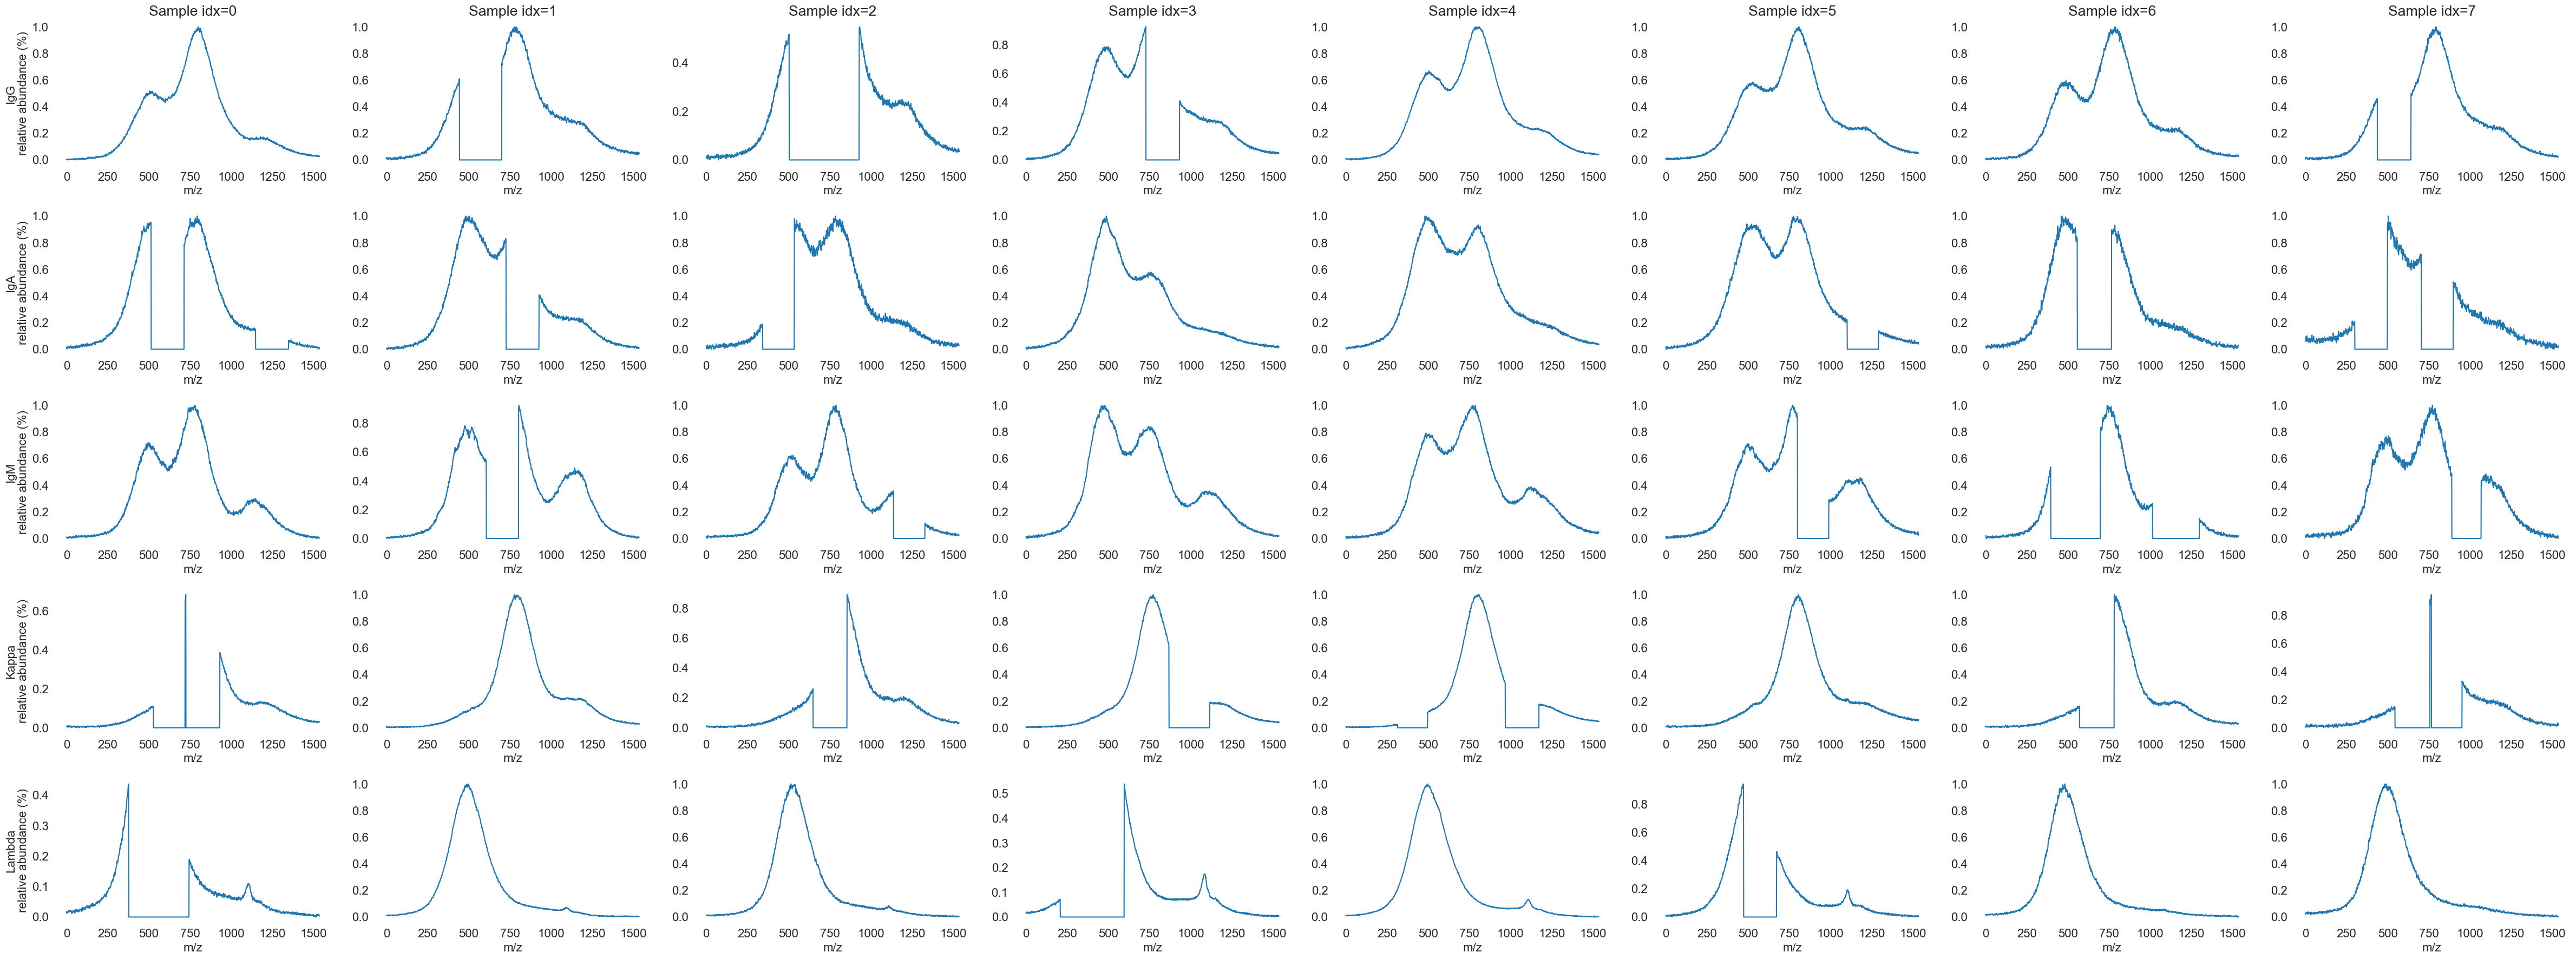

In [8]:
n_images = 8  # we want to show a limited number of samples on the plot
x, y = next(iter(train_loader))
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()
plt.figure(figsize=(6 * n_images, 18))
gs = gridspec.GridSpec(5, n_images)
for idx in range(n_images):
    for i in range(5):
        plt.subplot(gs[i, idx])
        plt.plot(x[idx, i, 0, :])
        if idx == 0:
            plt.ylabel(f'{["IgG", "IgA", "IgM", "Kappa", "Lambda"][i]}\nrelative abundance (%)')
        if i == 0:
            plt.title(f"Sample {idx=}")
        plt.xlabel("m/z")
plt.tight_layout()
plt.show()

## Deep learning pipeline

In [9]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss
    

def _get_homemade_encoder_v1_base_modules(input_dim, input_channels, encoder_blocks_layout, maxpool, kernel_size, stride, dropout,
                                          first_layer_groups, groups, batchnorm, hidden_activation, flatten):

    assert (maxpool == 1 and stride > 1) or (maxpool > 1 and stride == 1), f"Exactly one of {maxpool=} and {stride=} must be > 1"
    n_pools = len(encoder_blocks_layout) - 1 if maxpool > 1 else len(encoder_blocks_layout)

    _encoder_modules = []

    previous_channels = input_channels

    for block_position, block_layers in enumerate(encoder_blocks_layout):
        if block_position > 0:
            if maxpool > 1:
                _encoder_modules.append(nn.MaxPool2d(kernel_size=(1, maxpool), stride=(1, maxpool)))
        for layer_position, layer_channels in enumerate(block_layers):
            current_stride = stride if layer_position == 0 else 1
            padding = 0
            if current_stride > 1:
                hin = input_dim // (max(maxpool, stride) ** (layer_position))
                padding = (kernel_size - hin + stride * (hin / stride - 1)) / 2
                assert (padding % 1) == 0, f"Current {stride}, {hin=} and {kernel_size=} end with decimal {padding=}"
                padding = int(padding)

            _encoder_modules.append(nn.Conv2d(in_channels=previous_channels, out_channels=layer_channels, kernel_size=(1, kernel_size),
                                              stride=(1, current_stride),
                                              groups=first_layer_groups if ((layer_position == 0) and (block_position == 0)) else groups,
                                              padding=(0, padding) if current_stride > 1 else "same"))
            if (dropout is not None) and (dropout > 0):
                _encoder_modules.append(nn.Dropout(p=dropout))
            previous_channels = layer_channels
            if batchnorm:
                _encoder_modules.append(nn.BatchNorm2d(layer_channels))
            if hidden_activation == "relu":
                _encoder_modules.append(nn.ReLU())
            elif hidden_activation == "leaky_relu":
                _encoder_modules.append(nn.LeakyReLU())
            elif hidden_activation == "elu":
                _encoder_modules.append(nn.ELU())
            elif hidden_activation == "selu":
                _encoder_modules.append(nn.SELU())
            else:
                assert False, f"Unknown {hidden_activation=}"

    encoder_lastconv_dim = input_dim // (max(stride, maxpool) ** n_pools)
    encoder_lastconv_channels = encoder_blocks_layout[-1][-1]

    if flatten == "avg":
        global_pooling_kernel = encoder_lastconv_dim
        encoder_output_dim = encoder_lastconv_channels
        _encoder_modules.append(nn.AvgPool2d(kernel_size=(1, global_pooling_kernel)))
        _encoder_modules.append(nn.Flatten())
    elif flatten == "max":
        global_pooling_kernel = encoder_lastconv_dim
        encoder_output_dim = encoder_lastconv_channels
        _encoder_modules.append(nn.MaxPool2d(kernel_size=(1, global_pooling_kernel)))
        _encoder_modules.append(nn.Flatten())
    elif flatten == "flatten":
        encoder_output_dim = encoder_lastconv_channels * encoder_lastconv_dim
        _encoder_modules.append(nn.Flatten())
    else:
        assert False, f"Unknown {flatten=}"

    return _encoder_modules, encoder_output_dim  # , encoder_lastconv_channels, encoder_lastconv_dim


def _get_dense_encoder(input_dim, input_channels, encoder_blocks_layout, dropout, batchnorm, hidden_activation):

    _encoder_modules = []

    previous_size = input_dim * input_channels

    _encoder_modules.append(nn.Flatten())

    for layer_position, layer_size in enumerate(encoder_blocks_layout):

        _encoder_modules.append(nn.Linear(previous_size, layer_size))

        if (dropout is not None) and (dropout > 0):
            _encoder_modules.append(nn.Dropout(p=dropout))
        previous_size = layer_size
        if batchnorm:
            _encoder_modules.append(nn.BatchNorm1d(layer_size))
        if hidden_activation == "relu":
            _encoder_modules.append(nn.ReLU())
        elif hidden_activation == "leaky_relu":
            _encoder_modules.append(nn.LeakyReLU())
        elif hidden_activation == "elu":
            _encoder_modules.append(nn.ELU())
        elif hidden_activation == "selu":
            _encoder_modules.append(nn.SELU())
        else:
            assert False, f"Unknown {hidden_activation=}"

    return _encoder_modules, previous_size



class SupervisedModule(pl.LightningModule):
    def __init__(self, n_classes, mode,
                 input_dim, input_channels, latent_dim, kernel_size, flatten, stride, dropout, groups, first_layer_groups, maxpool,
                 encoder_blocks_layout, backbone, batchnorm, hidden_activation,
                 optimizer,
                 lr, lr_scheduler, lr_reduceonplateau_factor, lr_reduceonplateau_patience, lr_reduceonplateau_threshold, lr_reduceonplateau_minlr,
                 lr_multistep_milestones,
                 lr_multistep_gamma,
                 ):
        super().__init__()
        self.save_hyperparameters()

        self.n_classes = n_classes
        self.mode = mode
        self.backbone = backbone

        if self.backbone == "resnet1d":
            from resnet1d.resnet1d import ResNet1D
            self.encoder = ResNet1D(in_channels=input_channels,
                                    base_filters=encoder_blocks_layout[0][0],
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    groups=groups,
                                    n_block=len(encoder_blocks_layout),
                                    n_classes=n_classes)

        elif self.backbone == "net1d":
            from resnet1d.net1d import Net1D
            self.encoder = Net1D(
                in_channels=input_channels,
                base_filters=encoder_blocks_layout[0][0],
                ratio=1.0,
                filter_list=[f[0] for f in encoder_blocks_layout],
                m_blocks_list=[len(f) for f in encoder_blocks_layout],
                kernel_size=kernel_size,
                stride=stride,
                groups_width=groups,
                verbose=False,
                n_classes=n_classes)

        elif (self.backbone == "conv") or (self.backbone == "homemade"):  # conv model was the first model designed, hence homemade
            encoder_modules, enc_out_dim = _get_homemade_encoder_v1_base_modules(input_dim=input_dim, input_channels=input_channels, maxpool=maxpool,
                                                                                 encoder_blocks_layout=encoder_blocks_layout, kernel_size=kernel_size,
                                                                                 stride=stride, dropout=dropout,
                                                                                 first_layer_groups=first_layer_groups, groups=groups,
                                                                                 batchnorm=batchnorm, hidden_activation=hidden_activation, flatten=flatten)
            self.encoder = nn.Sequential(*encoder_modules)
            self.fc = nn.Linear(enc_out_dim, latent_dim)
            self.pred = nn.Linear(latent_dim, self.n_classes)

        elif self.backbone == "dense":
            encoder_modules, enc_out_dim = _get_dense_encoder(input_dim=input_dim, input_channels=input_channels, encoder_blocks_layout=encoder_blocks_layout,
                                                              dropout=dropout, batchnorm=batchnorm, hidden_activation=hidden_activation)
            self.encoder = nn.Sequential(*encoder_modules)
            # self.fc = nn.Linear(enc_out_dim, latent_dim)
            # self.pred = nn.Linear(latent_dim, self.n_classes)
            self.pred = nn.Linear(enc_out_dim, self.n_classes)
        elif self.backbone == "vit_1d":
            from vit_pytorch import vit_1d

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // defaults 0.1

            vit = vit_1d.ViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                emb_dropout=dropout
            )

            self.encoder = vit
        elif self.backbone == "simple_vit_1d":
            from vit_pytorch import simple_vit_1d

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // NO DROPOUT IN SIMPLE VIT!

            vit = simple_vit_1d.SimpleViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
            )

            self.encoder = vit

        elif self.backbone == "smalldataset_vit_1d":
            from python.pyms_assets.vit_1d_for_small_dataset import SDViT

            # for vit we used config parameter "encoder_blocks_layout" in a weird way:
            patch_size = encoder_blocks_layout[0]  # the patch size // defaults 16 from ViT, 20 from ecg classifier
            heads = encoder_blocks_layout[1]  # the number of self attention heads // defaults 6
            depth = encoder_blocks_layout[2]  # the number of layers (depth) // defaults 6
            mlp_dim = encoder_blocks_layout[3]  # the mlp dim // defaults 256
            dim_head = encoder_blocks_layout[4]  # the head dim // defaults 64
            hidden_dim = latent_dim  # the hidden_dim // defaults 768
            # dropout  // NO DROPOUT IN SIMPLE VIT!

            vit = SDViT(
                seq_len=input_dim,
                patch_size=patch_size,
                num_classes=self.n_classes,
                channels=input_channels,
                dim=hidden_dim,
                dim_head=dim_head,
                depth=depth,
                heads=heads,
                mlp_dim=mlp_dim,
                dropout=dropout,
                emb_dropout=dropout
            )

            self.encoder = vit
        else:
            assert False, f"Unknown {backbone=}"

        self.softmax = nn.Softmax(dim=1)

        if self.mode == "quant":
            self.loss = RMSELoss()
        if self.mode == "qual":
            self.loss = nn.CrossEntropyLoss()

        self.y_true = []
        self.y_pred = []

    def configure_optimizers(self):
        if self.hparams.optimizer == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "AdamW":
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        elif self.hparams.optimizer == "RMSProp":
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.hparams.lr)
        else:
            assert False, f"Unknown {self.hparams.optimizer=}"
        if self.hparams.lr_scheduler == "reduceonplateau":
            print(
                f"Setting optimizer to reduceonplateau with params {self.hparams.lr_reduceonplateau_factor=}, {self.hparams.lr_reduceonplateau_patience=}, {self.hparams.lr_reduceonplateau_threshold=}, {self.hparams.lr_reduceonplateau_minlr=}")
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=self.hparams.lr_reduceonplateau_factor,
                                                                   patience=self.hparams.lr_reduceonplateau_patience,
                                                                   threshold=self.hparams.lr_reduceonplateau_threshold,
                                                                   min_lr=self.hparams.lr_reduceonplateau_minlr, verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        elif self.hparams.lr_scheduler == "multistep":
            print(f"Setting optimizer to multistep with params {self.hparams.lr_multistep_milestones=}, {self.hparams.lr_multistep_gamma=}")
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.hparams.lr_multistep_milestones, gamma=self.hparams.lr_multistep_gamma,
                                                             verbose=True)
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        elif self.hparams.lr_scheduler != "none":
            assert False, f"Unknown {self.hparams.lr_scheduler=}"
        return optimizer

    def forward(self, batch):
        if type(batch) in (tuple, list):
            x, y = batch
        else:
            x = batch
        if self.backbone in ("resnet1d", "net1d"):
            x = x.view(x.size(0), x.size(1), x.size(3))
            x = self.encoder(x)
        elif self.backbone == "homemade":
            x = self.pred(self.fc(self.encoder(x)))
        elif self.backbone == "dense":
            x = self.pred(self.encoder(x))
        elif self.backbone in ("vit_1d", "simple_vit_1d", "smalldataset_vit_1d"):
            x = torch.squeeze(x)  # drop H in H x W
            x = self.encoder(x)
        if self.mode == "qual":
            x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        # encode x to get the mu and variance parameters
        yhat = None
        if self.backbone in ("resnet1d", "net1d"):
            x = x.view(x.size(0), x.size(1), x.size(3))
            yhat = self.encoder(x)
        elif self.backbone == "homemade":
            yhat = self.pred(self.fc(self.encoder(x)))
        elif self.backbone == "dense":
            yhat = self.pred(self.encoder(x))
        elif self.backbone in ("vit_1d", "simple_vit_1d", "smalldataset_vit_1d"):
            x = torch.squeeze(x)  # drop H in H x W
            yhat = self.encoder(x)

        loss = self.loss(yhat, y)

        self.log_dict({
            'loss': loss,
        })

        return loss

Now we can load the deep learning model and pytorch/lightning objects needed to run the DL pipeline

In [10]:
trainer_args = {'accelerator': 'gpu' if torch.cuda.is_available() else 'cpu',
                'devices': 'auto',
                'num_nodes': 1,
                'strategy': 'auto'}

pl.seed_everything(44)  # To be reproducible
model = SupervisedModule.load_from_checkpoint(checkpoint_path)

print(model)

trainer = pl.Trainer(
    # default_root_dir=os.path.split(checkpoint_path)[0],
    **trainer_args,
    callbacks=None,
    logger=None,
)

Seed set to 44
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


SupervisedModule(
  (encoder): Sequential(
    (0): Conv2d(5, 65, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (1): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Conv2d(65, 65, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (4): BatchNorm2d(65, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU()
    (6): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(65, 130, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (8): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SELU()
    (10): Conv2d(130, 130, kernel_size=(1, 5), stride=(1, 1), padding=same, groups=5)
    (11): BatchNorm2d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): SELU()
    (13): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (14):

C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Then we can define the parameters that we will use to define what predictions we will realized and how we will analyze them
Here, we want to predict BiAge, so we will focus on comparing with Age (chronological age)
Let's define some parameters that will guide plot production later
This will allow reusing similar functions for race and sex prediction, with minor changes only

In [11]:
# parameters specific for age_v2 validation
ANALYSIS_TYPE = "QUANTITATIVE"
UNSTANDARDIZE_PREDICTIONS = False
UNSTANDARDIZE_TRUES = True
OUTPUT_COLUMN_LOC = -1
TRUES_COLNAME = "Age"
PREDS_COLNAME = "Age score"
SAFETYCHECK_COLNAME = "AGE"

trues_label = "Chronological age"
peak_method_2_label = {"Age score": "BiAge",
                       "Age score (peaks dropped out)": "BiAge (masked peaks)",
                       "Age score (peaks smoothed)": "BiAge (smoothed peaks)"}
trues_ticks = [40, 50, 60, 70, 80]
trues_ticks_full_length = [20, 30, 40, 50, 60, 70, 80, 90]
peak_method_ticks = [-1., 0, 1.]

Then, we will define a `supervised_inference` function which will help with automatically obtaining predictions from the model and converting those predictions into usable data for validation
Particularly, this function will be responsible of outputing raw predictions and predictions after masking peaks (peak dropout)
Furthermore, this function will be responsible of unstandardizing the target (y) variable, since age was standardized before training the model

In [12]:
def supervised_inference(sample_match_ids: list, sample_annotations: np.array,
                         negative_dropout_preprocess_data, output_column_loc: int,
                         unstandardize: bool, return_datasets_instead: bool = False, multi_preprocessing: bool = True):
    assert type(sample_match_ids) is list, f"{type(sample_match_ids)=}, must be a list"

    all_preds = []
    all_datasets = []

    if multi_preprocessing:
        if negative_dropout_preprocess_data is not None:
            preprocessings = [None, negative_dropout_preprocess_data]
        else:
            preprocessings = [None, "dropout"]
    else:
        preprocessings = [None, ]

    for preprocessing in preprocessings:
        the_dataset = MSSpectraDataset(dataset_path=dataset_dir,
                                       sample_match_ids=sample_match_ids,
                                       sample_annotations=sample_annotations,
                                       peak_removal_method=preprocessing,
                                       input_dim=input_dim)

        if return_datasets_instead:
            all_datasets.append(the_dataset)
            continue

        the_loader = data.DataLoader(
            the_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=0,
            persistent_workers=False
        )

        the_outputs = trainer.predict(model, dataloaders=the_loader)
        the_preds = torch.cat(the_outputs).detach().cpu().numpy()
        if unstandardize:
            the_preds = (the_preds * y_intraining_std) + y_intraining_mean
        if output_column_loc is not None:
            the_preds = the_preds[:, output_column_loc]

        # save
        all_preds.append(the_preds)

    if return_datasets_instead:
        return all_datasets

    return all_preds

Specifically, the `find_paired_dropout_data` function will help with selecting paired samples so we can apply peak dropout on negative samples (i.e. which do not have any peaks) by resampling the peak locations/sizes from positive samples from similar patients (e.g. similar age)

In [13]:
def find_paired_dropout_data(target_match_ids, positive_match_ids_to_pair, take_original_for_non_negatives_targets: bool):
    # 1) get the ages of the patients
    find_age_df_negatives = pd.DataFrame({"ANON_ID": target_match_ids}).merge(
        dataset[["ANON_ID", "AGE", "GLOBAL_DIAGNOSIS"]], how="left")
    assert len(find_age_df_negatives) == len(target_match_ids)
    find_age_df_positives = pd.DataFrame({"ANON_ID": positive_match_ids_to_pair}).merge(
        dataset[["ANON_ID", "AGE", "GLOBAL_DIAGNOSIS"]], how="left")
    assert len(find_age_df_positives) == len(positive_match_ids_to_pair)
    # remove LC-MGUS (no peaks)
    find_age_df_positives = find_age_df_positives[find_age_df_positives.GLOBAL_DIAGNOSIS != "LC-MGUS"]
    # now randomly pair each negative with a positive with same age
    # to do this, we can just merge both by rounded age
    find_age_df_negatives = find_age_df_negatives.rename(
        columns={"ANON_ID": "Negative_ANON_ID", "GLOBAL_DIAGNOSIS": "Negative_GLOBAL_DIAGNOSIS"})
    find_age_df_positives = find_age_df_positives.rename(
        columns={"ANON_ID": "Positive_ANON_ID", "GLOBAL_DIAGNOSIS": "Positive_GLOBAL_DIAGNOSIS"})
    find_age_df_negatives["Rounded_Age"] = find_age_df_negatives.AGE.round(0)
    find_age_df_positives["Rounded_Age"] = find_age_df_positives.AGE.round(0)
    all_possible_negpos_pairs = find_age_df_negatives.merge(find_age_df_positives, on="Rounded_Age", how="left")
    # now we can just shuffle our dataset randomly, and then remove duplicated Negative_ANON_ID to keep only 1 match per patient
    random_order = np.random.RandomState(seed=1).choice(np.arange(len(all_possible_negpos_pairs)), size=len(all_possible_negpos_pairs),
                                                        replace=False)
    all_possible_negpos_pairs = all_possible_negpos_pairs.iloc[random_order]
    paired_negative_samples = all_possible_negpos_pairs[~all_possible_negpos_pairs.Negative_ANON_ID.duplicated()]
    # finally re-order by merging with our initial negative samples list
    final_pair_df = find_age_df_negatives[["Negative_ANON_ID", "Negative_GLOBAL_DIAGNOSIS"]].merge(
        paired_negative_samples[["Negative_ANON_ID", "Positive_ANON_ID", "Positive_GLOBAL_DIAGNOSIS"]],
        on="Negative_ANON_ID", how="left")
    # now we just have to load the data that will be used for dropping out parts
    peaks_info_df = pd.DataFrame(pd.read_hdf(os.path.join(dataset_dir, "peaks_positions.h5")))
    paired_peaks_info = []
    # note: we are not using the type of pos diagnosis to decide which sample to pair
    # because since we are using ALL positives
    # we can say that the dropout will be make according to how frequent some peaks are seen in the whole population
    for idx in tqdm(range(len(final_pair_df))):
        if take_original_for_non_negatives_targets and (final_pair_df.iloc[idx]["Negative_GLOBAL_DIAGNOSIS"] != "Negative"):
            # we want to take the original peaks_info for non-negative samples
            # and this sample is not a negative
            # so we'll take its info instead of a matched positive
            selected_match_id = final_pair_df.iloc[idx].Negative_ANON_ID
        else:
            # this sample is a negative so has no peaks info (except potentially <LLMI/C1q)
            # or we set take_original_for_non_negatives to False to force taking the paired positive sample's peak info
            # any case, we'll "overwrite" this sample's peak info by the paired positive's
            selected_match_id = final_pair_df.iloc[idx].Positive_ANON_ID
        match_peaks_info = peaks_info_df[peaks_info_df.match_id == selected_match_id]
        match_peaks_info = [match_peaks_info.iloc[k].to_dict() for k in range(len(match_peaks_info))]
        paired_peaks_info.append(match_peaks_info)
    # now we can call our dataset
    (np.array([len(p) for p in paired_peaks_info]) > 0).sum()  # 876
    (np.array([len(p) for p in
               paired_peaks_info]) == 0).sum()  # 13  # sometimes there may be "0" peaks... it's rare and when the peak is 0.015 g/L, but flagged as LLMI (really in between)
    # return
    return paired_peaks_info


Then, we can create our different datasets (training set, validation set for negative samples, validation set for samples with monoclonal gammopathy) and compute model predictions

In [14]:
dataset_intraining = dataset_intraining.copy()
dataset_intraining[TRUES_COLNAME] = dataset_intraining.AGE

# COMMON FOR ALL: GET PREDICTIONS, GROUND TRUTHS, ETC.

# run all predictions
# predict humoral age/other things for negative samples
training_match_ids, training_trues = spectrum_files_train, spectrum_annotations_train
negative_match_ids, negative_trues = spectrum_files_test, spectrum_annotations_test
positive_match_ids, positive_trues = x_outtraining, y_outtraining
if UNSTANDARDIZE_TRUES:
    training_trues = (training_trues * y_intraining_std) + y_intraining_mean
    negative_trues = (negative_trues * y_intraining_std) + y_intraining_mean
    positive_trues = (positive_trues * y_intraining_std) + y_intraining_mean
training_trues = training_trues[:, OUTPUT_COLUMN_LOC] if len(training_trues.shape) == 2 else training_trues
negative_trues = negative_trues[:, OUTPUT_COLUMN_LOC] if len(negative_trues.shape) == 2 else negative_trues
positive_trues = positive_trues[:, OUTPUT_COLUMN_LOC] if len(positive_trues.shape) == 2 else positive_trues

training_preds, = supervised_inference(sample_match_ids=training_match_ids,
                                       sample_annotations=training_trues,
                                       output_column_loc=OUTPUT_COLUMN_LOC,
                                       negative_dropout_preprocess_data=None,  # no need to dropout: comparing only negatives
                                       unstandardize=UNSTANDARDIZE_PREDICTIONS,
                                       multi_preprocessing=False)

negative_preds, negative_preds_dropout = supervised_inference(sample_match_ids=negative_match_ids,
                                                              sample_annotations=negative_trues,
                                                              output_column_loc=OUTPUT_COLUMN_LOC,
                                                              negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                  target_match_ids=negative_match_ids,
                                                                  positive_match_ids_to_pair=positive_match_ids,
                                                                  take_original_for_non_negatives_targets=False),
                                                              unstandardize=UNSTANDARDIZE_PREDICTIONS)

# same for positives
positive_preds, dropoutpeaks_positive_preds = supervised_inference(sample_match_ids=positive_match_ids,
                                                                   sample_annotations=positive_trues,
                                                                   output_column_loc=OUTPUT_COLUMN_LOC,
                                                                   negative_dropout_preprocess_data=None,
                                                                   unstandardize=UNSTANDARDIZE_PREDICTIONS)

# for negatives, we also want to use dropout to compare results consistently with positives
# but they do not have peaks (by definition...)
# so instead we will pair each negative sample with one positive sample from the positive set
# (pairing will be made by age)
# and then we will mask them how we masked the positive samples

# PLOT DROPOUT EXAMPLES => FIGURE S11, FIGURE S1

# do small figures of how we dropout negative samples (once is enough for all models)
debug_paired_peaks_info = find_paired_dropout_data(target_match_ids=negative_match_ids,
                                                   positive_match_ids_to_pair=positive_match_ids,
                                                   take_original_for_non_negatives_targets=False)
nodropout_negative_dataset, dropout_negative_dataset = supervised_inference(sample_match_ids=negative_match_ids,
                                                                            sample_annotations=negative_trues,
                                                                            output_column_loc=OUTPUT_COLUMN_LOC,
                                                                            negative_dropout_preprocess_data=debug_paired_peaks_info,
                                                                            unstandardize=UNSTANDARDIZE_PREDICTIONS,
                                                                            return_datasets_instead=True)
nodropout_positive_dataset, dropout_positive_dataset = supervised_inference(
    sample_match_ids=positive_match_ids,
    sample_annotations=positive_trues,
    output_column_loc=OUTPUT_COLUMN_LOC,
    negative_dropout_preprocess_data=None,
    unstandardize=UNSTANDARDIZE_PREDICTIONS,
    return_datasets_instead=True)


You are using a CUDA device ('NVIDIA RTX A5500 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 250/250 [00:08<00:00, 28.38it/s]


100%|██████████| 889/889 [00:00<00:00, 929.80it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 30.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 30.54it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 245/245 [00:07<00:00, 31.56it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 245/245 [00:08<00:00, 29.88it/s]


100%|██████████| 889/889 [00:00<00:00, 897.78it/s]


To illustrate what an original set of spectra (for 1 sample of 1 patient) looks like, without or with peaks masking, we can plot the figure below

This is **Figure 2B** and **Figure 2C** in the manuscript

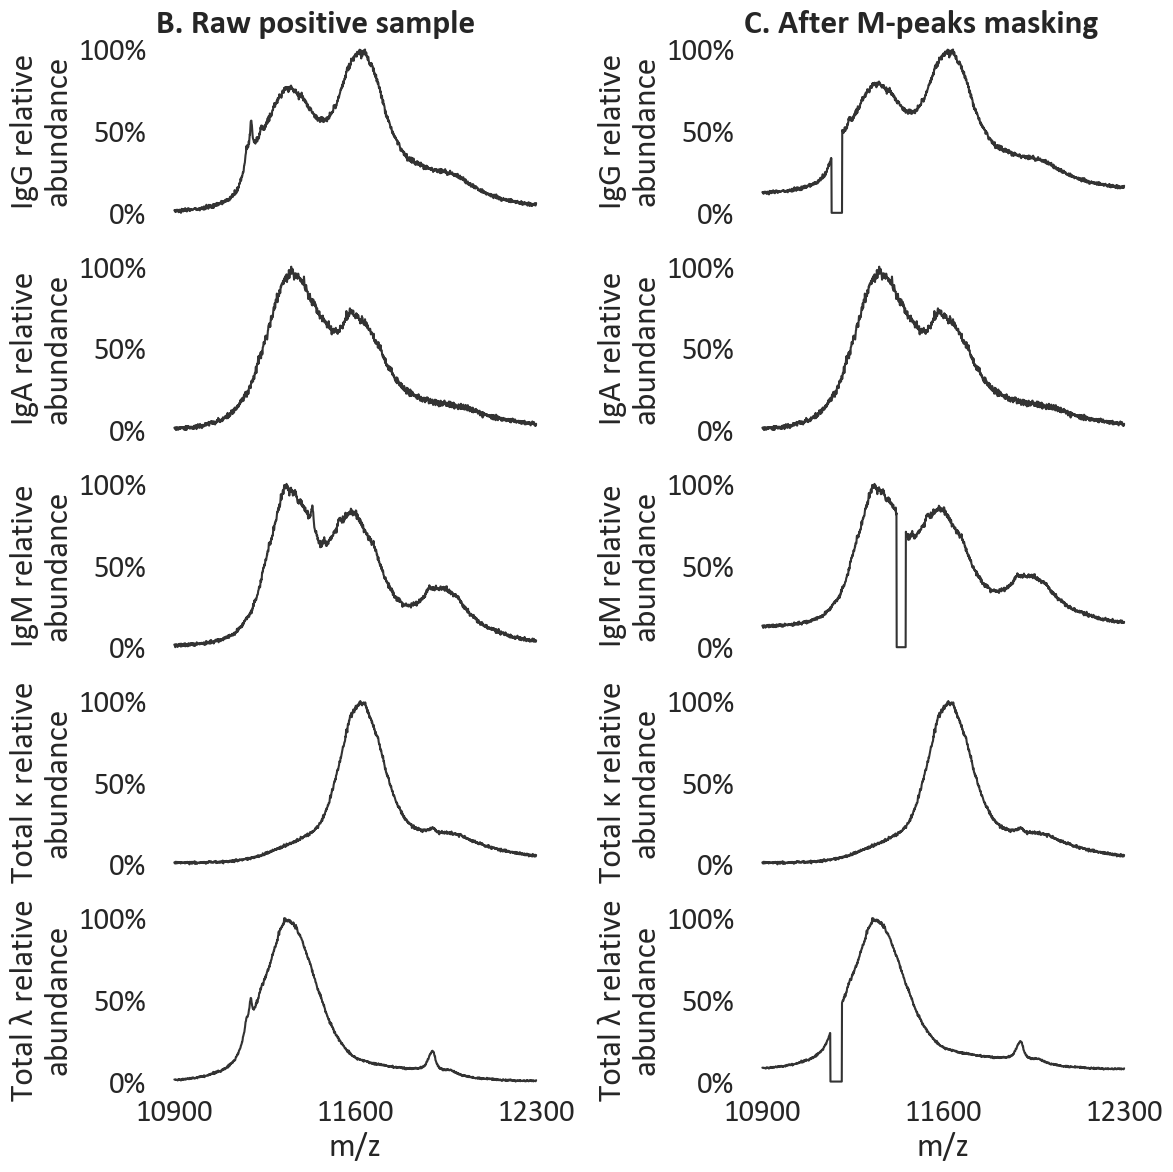

In [15]:
# FIGURE 2 B, C

dropout_examples = [0, ]
for idx in dropout_examples:
    original_x, _ = nodropout_negative_dataset.__getitem__(idx)
    dropout_x, _ = dropout_negative_dataset.__getitem__(idx)
    paired_pos_matchid = debug_paired_peaks_info[idx][0]["match_id"]
    pos_idx = [k for k, v in enumerate(x_outtraining) if v == paired_pos_matchid][0]
    original_posx, _ = nodropout_positive_dataset.__getitem__(pos_idx)
    dropout_posx, _ = dropout_positive_dataset.__getitem__(pos_idx)

    gamkl_label = [*["Ig" + ist for ist in "GAM"], *["Total " + ist for ist in "κλ"]]

    # visualize how it looks like
    plt.figure(figsize=(pp_size * 2, pp_size * 2))
    gs: np.array = gridspec.GridSpec(5, 2)
    for i in range(5):
        plot_title_lst = ["B. Raw positive sample",
                          "C. After M-peaks masking",
                          ]
        y_values_lst = [original_posx, dropout_posx]
        for j, (y_values, plot_title) in enumerate(zip(y_values_lst, plot_title_lst)):
            plt.subplot(gs[i, j])
            ax = sns.lineplot(x=np.arange(y_values.shape[-1]), y=y_values[i, 0, :], hue=[gamkl_label[i], ] * original_x.shape[-1],
                              palette={c: "#333333" for c in gamkl_label}, legend=False)
            if j < 2:
                # ax.legend(prop=legend_font_params, loc="upper right")
                plt.yticks([0, .5, 1.])
                ax.set_yticklabels([f"{v * 100:.0f}%" for v in ax.get_yticks()], fontdict=ticks_font_params)
                plt.ylabel(gamkl_label[i] + " relative\nabundance", **labels_font_params)
            else:
                plt.yticks([0, .5, 1.])
                ax.set_yticklabels(["" for v in ax.get_yticks()], fontdict=ticks_font_params)
                plt.ylabel(None)
                # ax.legend().remove()
            if i == 0:
                plt.title(plot_title, loc='left', font=paneltitle_font_params)
            if i == 4:
                plt.xticks([0, 768, 1536])
                ax.set_xticklabels([{0: "10900", 768: "11600", 1536: "12300"}[v] for v in ax.get_xticks()], fontdict=ticks_font_params)
                plt.xlabel("m/z", **labels_font_params)
            else:
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    plt.tight_layout()
    plt.show()

We can also do a similar figure with more details, and especially showcase how we can, from a negative sample (A), sample a similar positive sample (B), and use the peaks position/size on this positive sample to mask the peaks from this positive sample's spectra (C), and also mask the same areas in the negative sample (D)

This is **Supplementary Figure S11** in the manuscript

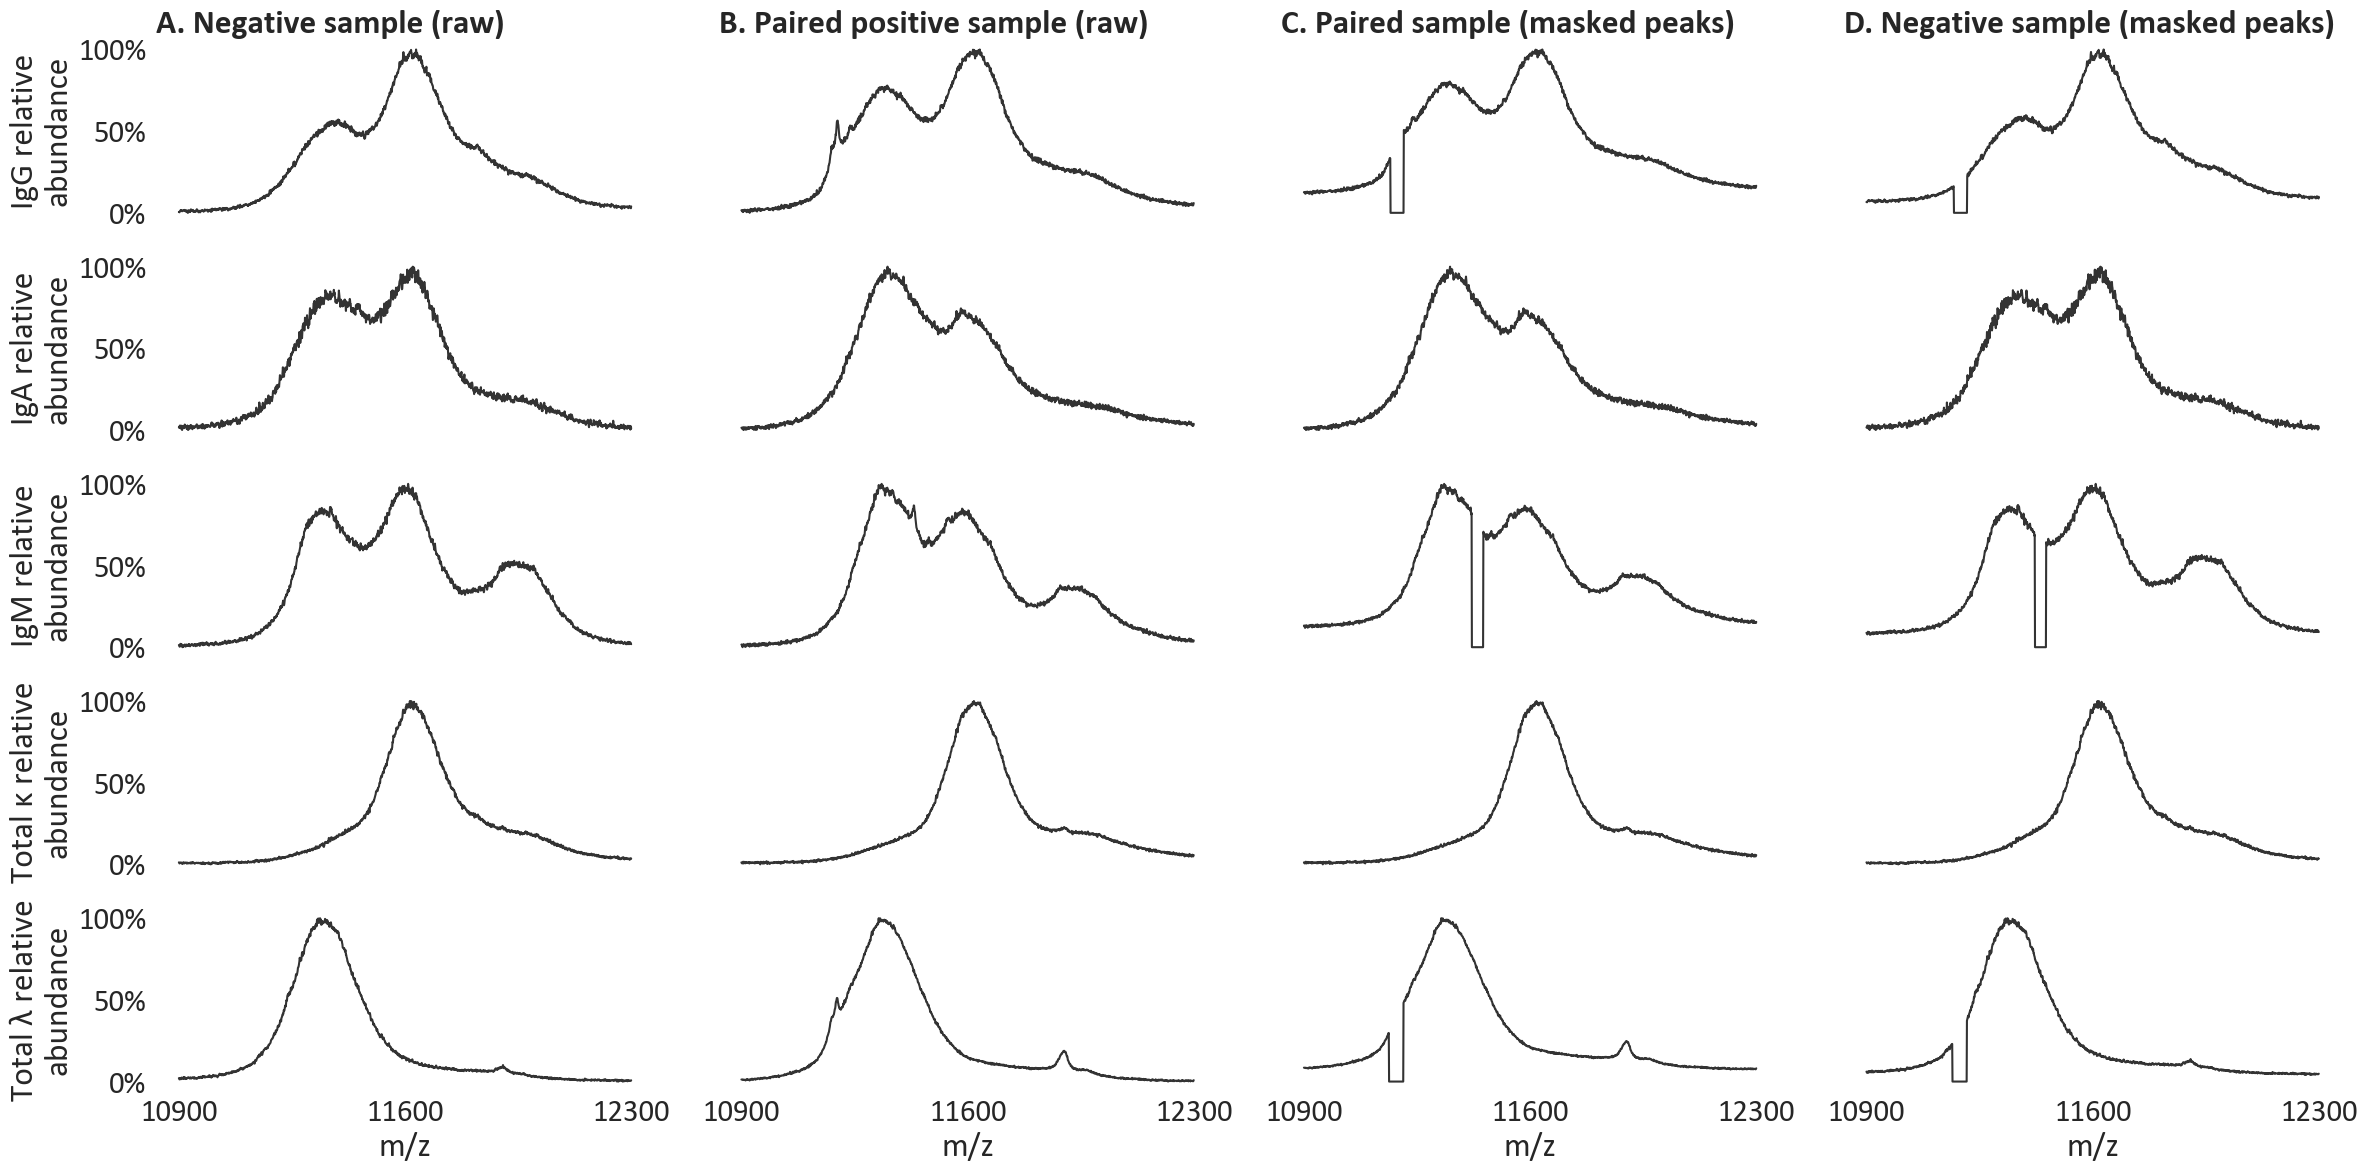

In [16]:
# WITH MORE DETAILS, SUPPLEMENTARY FIGURE S11

dropout_examples = [0, ]
for idx in dropout_examples:
    original_x, _ = nodropout_negative_dataset.__getitem__(idx)
    dropout_x, _ = dropout_negative_dataset.__getitem__(idx)
    paired_pos_matchid = debug_paired_peaks_info[idx][0]["match_id"]
    pos_idx = [k for k, v in enumerate(x_outtraining) if v == paired_pos_matchid][0]
    original_posx, _ = nodropout_positive_dataset.__getitem__(pos_idx)
    dropout_posx, _ = dropout_positive_dataset.__getitem__(pos_idx)

    gamkl_label = [*["Ig" + ist for ist in "GAM"], *["Total " + ist for ist in "κλ"]]

    # visualize how it looks like
    plt.figure(figsize=(pp_size * 4, pp_size * 2))
    gs: np.array = gridspec.GridSpec(5, 4)
    for i in range(5):
        plot_title_lst = ["A. Negative sample (raw)",
                          "B. Paired positive sample (raw)",
                          "C. Paired sample (masked peaks)",
                          "D. Negative sample (masked peaks)"]
        y_values_lst = [original_x, original_posx, dropout_posx, dropout_x]
        for j, (y_values, plot_title) in enumerate(zip(y_values_lst, plot_title_lst)):
            plt.subplot(gs[i, j])
            ax = sns.lineplot(x=np.arange(y_values.shape[-1]), y=y_values[i, 0, :], hue=[gamkl_label[i], ] * original_x.shape[-1],
                              palette={c: "#333333" for c in gamkl_label}, legend=False)
            if j == 0:
                # ax.legend(prop=legend_font_params, loc="upper right")
                plt.yticks([0, .5, 1.])
                ax.set_yticklabels([f"{v * 100:.0f}%" for v in ax.get_yticks()], fontdict=ticks_font_params)
                plt.ylabel(gamkl_label[i] + " relative\nabundance", **labels_font_params)
            else:
                plt.yticks([0, .5, 1.])
                ax.set_yticklabels(["" for v in ax.get_yticks()], fontdict=ticks_font_params)
                plt.ylabel(None)
                # ax.legend().remove()
            if i == 0:
                plt.title(plot_title, loc='left', font=paneltitle_font_params)
            if i == 4:
                plt.xticks([0, 768, 1536])
                ax.set_xticklabels([{0: "10900", 768: "11600", 1536: "12300"}[v] for v in ax.get_xticks()], fontdict=ticks_font_params)
                plt.xlabel("m/z", **labels_font_params)
            else:
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

    plt.tight_layout()
    plt.show()

## Basic validation

Here we will focus on comparing the predicted BiAge to the chronological age of patients, in the various datasets (training, validations)

First, we can start with a basic plot of the training set and the validation set (negative samples only)

C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\_lib\_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


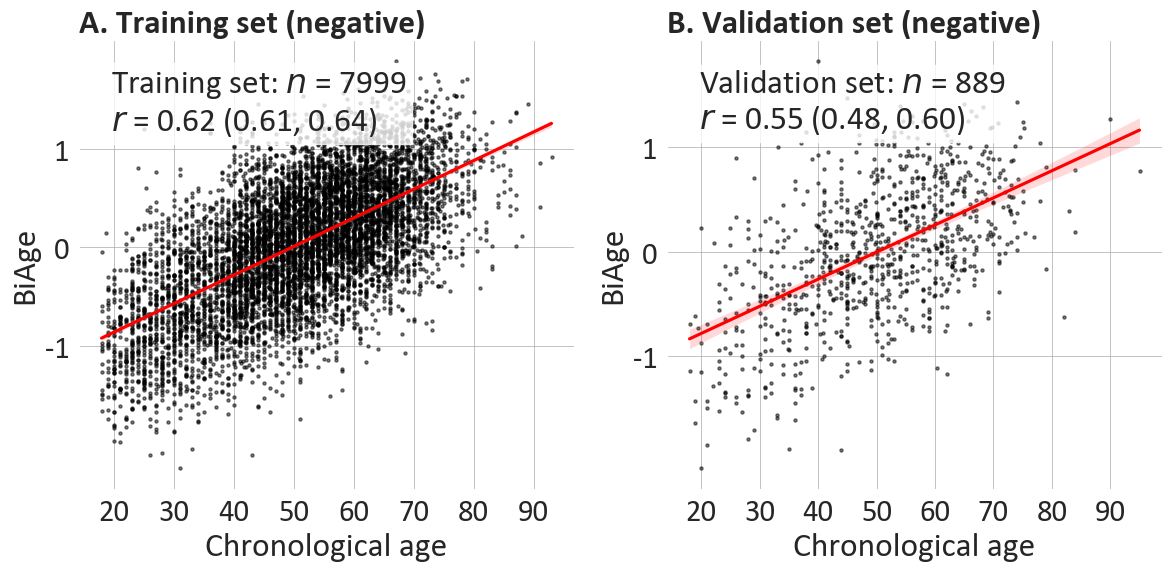

In [17]:
# plot correlation between gt and preds, on training and val sets
# compare predictions of BiAge for training set and validation set
plot_data = [[training_trues, training_preds, "A. Training set (negative)", "Training set"],
             [negative_trues, negative_preds, "B. Validation set (negative)", "Validation set"]]

plt.figure(figsize=(2 * pp_size, pp_size))
for i, (trues, preds, suptitle, group_name) in enumerate(plot_data):
    plt.subplot(1, 2, i + 1)
    plot_lm(x=trues, y=preds, group_name=group_name,
            xlabel=trues_label, ylabel=peak_method_2_label[PREDS_COLNAME],
            xticks=trues_ticks_full_length,
            yticks=peak_method_ticks,
            suptitle=suptitle,
            text_bbox_alpha=.8,
            scatter_kws_custom_alpha=.5,
            scatter_plot_custom_size=5,
            common_scale=False,
            confidence_level=.99)
plt.tight_layout()
plt.show()

Same, if we include a third figure with the patients from the validation set with monoclonal gammopathy

C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\_lib\_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\_lib\_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)


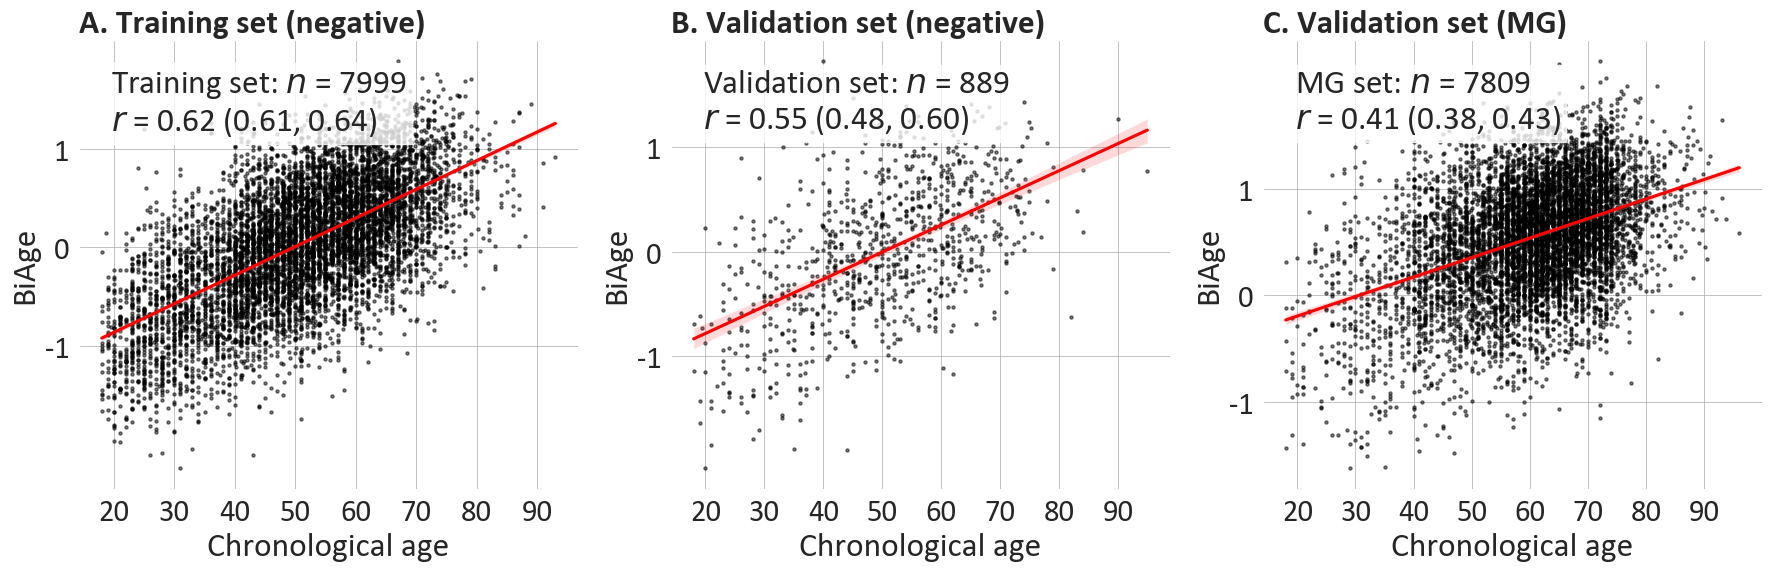

In [18]:
# compare predictions of BiAge for training set, validation set and non-negative samples (with MG)

plot_data = [[training_trues, training_preds, "A. Training set (negative)", "Training set"],
             [negative_trues, negative_preds, "B. Validation set (negative)", "Validation set"],
             [positive_trues, positive_preds, "C. Validation set (MG)", "MG set"]]

plt.figure(figsize=(3 * pp_size, pp_size))
for i, (trues, preds, suptitle, group_name) in enumerate(plot_data):
    plt.subplot(1, 3, i + 1)
    plot_lm(x=trues, y=preds, group_name=group_name,
            xlabel=trues_label, ylabel=peak_method_2_label[PREDS_COLNAME],
            xticks=trues_ticks_full_length,
            yticks=peak_method_ticks,
            suptitle=suptitle,
            text_bbox_alpha=.8,
            scatter_kws_custom_alpha=.5,
            scatter_plot_custom_size=5,
            common_scale=False,
            confidence_level=.99)
plt.tight_layout()
plt.show()

For those patients (MG positive), we can look more thoroughly after separating by exact MG status: MGIP-Low, MGIP-High, MGUS
The plot below depicting this is **Supplementary Figure S2** in the manuscript

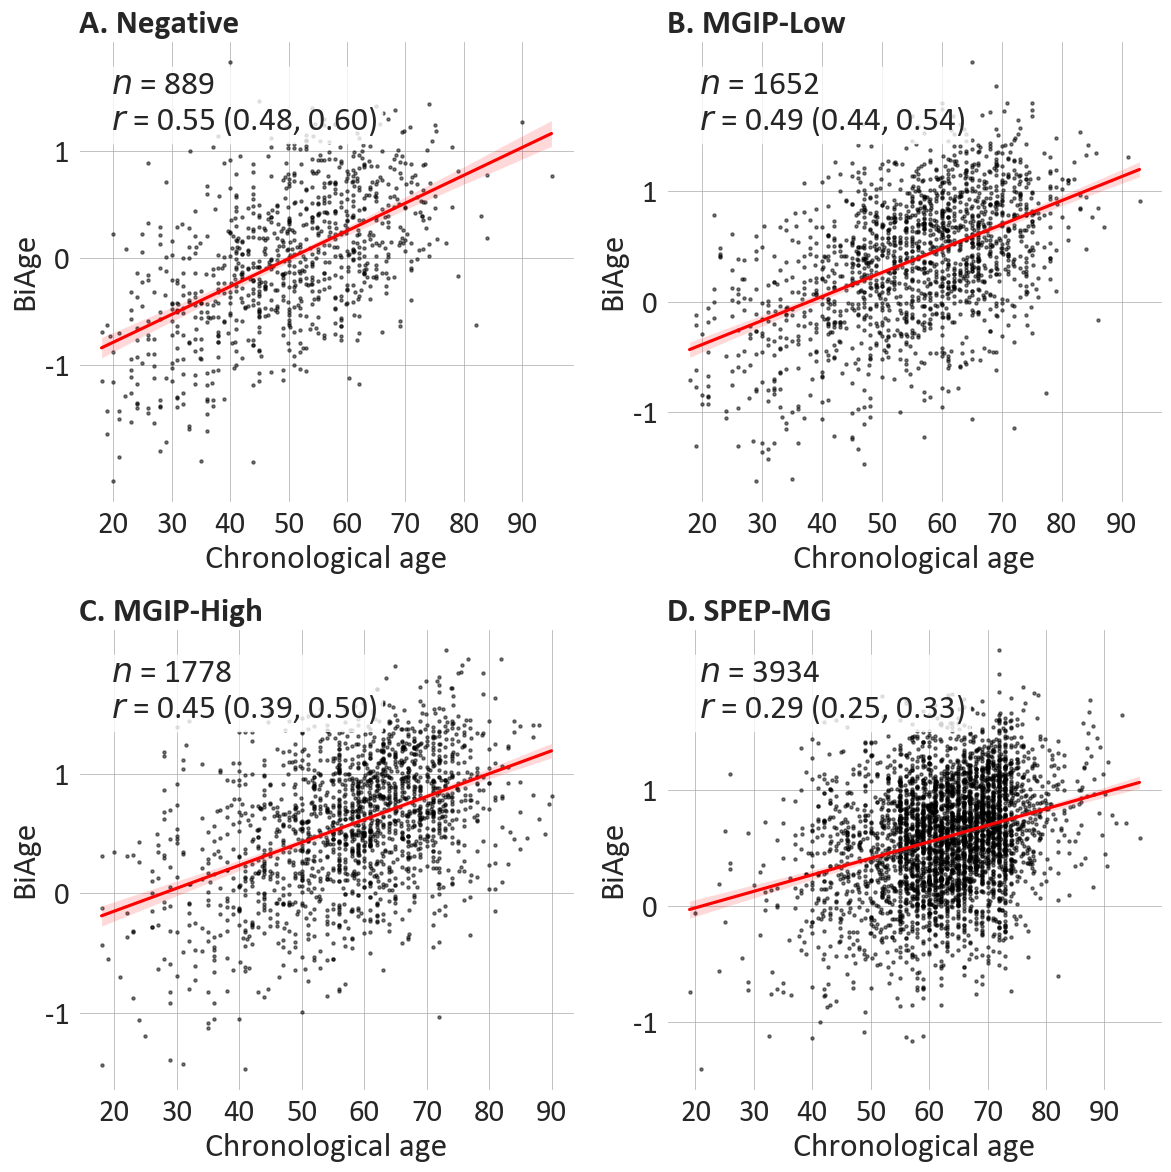

In [19]:
# compare predictions according to MG status for samles left out during training
# => Supplementary Figure S2
plot_data = [[negative_trues, negative_preds, "A. Negative", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"], "B. MGIP-Low", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"], "C. MGIP-High", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"], "D. SPEP-MG", ""]]

plt.figure(figsize=(2 * pp_size, 2 * pp_size))
for i, (trues, preds, suptitle, group_name) in enumerate(plot_data):
    plt.subplot(2, 2, i + 1)
    plot_lm(x=trues, y=preds, group_name=group_name,
            xlabel=trues_label, ylabel=peak_method_2_label[PREDS_COLNAME],
            xticks=trues_ticks_full_length,
            yticks=peak_method_ticks,
            suptitle=suptitle,
            text_bbox_alpha=.8,
            scatter_kws_custom_alpha=.5,
            scatter_plot_custom_size=5,
            common_scale=False,
            confidence_level=.99)
plt.tight_layout()
plt.show()

We can use the data we used for those plots to also compute partial correlations, which means compute the correlation coefficient after accounting for the correlation with batch, to check if there is a batch effect in our BiAge prediction

In [20]:
# do partial correlations to evaluate the impact of batch:

negative_batch_sbatch_df = pd.DataFrame(pd.Series(spectrum_files_test, name="ANON_ID")).merge(
    dataset[["ANON_ID", "COHORT", "Batch", "Simplified_Batch", "RACE", "SEX", ]], on="ANON_ID", how="inner")
assert len(negative_batch_sbatch_df) == len(spectrum_files_test)
assert (negative_batch_sbatch_df.ANON_ID == spectrum_files_test).all()

plot_data = [[negative_trues,
              negative_preds,
              negative_batch_sbatch_df.Batch.values,
              negative_batch_sbatch_df.Simplified_Batch.values,
              "A. Negative", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"],
              dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"].Batch.values,
              dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"].Simplified_Batch.values,
              "B. MGIP-Low",
              ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"],
              dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"].Batch.values,
              dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"].Simplified_Batch.values,
              "C. MGIP-High",
              ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"],
              dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"].Batch.values,
              dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"].Simplified_Batch.values,
              "D. MGUS",
              ""],
             ]

if pingouin_available:
    for i, (trues, preds, batches, sbatches, suptitle, _) in enumerate(plot_data):
        assert len(trues) == len(preds)
        assert len(batches) == len(sbatches)
        assert len(trues) == len(batches)
        tmp_data = pd.concat([pd.Series(trues, name="trues"),
                              pd.Series(preds, name="preds"),
                              pd.Series(batches, name="batch"),
                              pd.Series(sbatches, name="simplified_batch")], axis=1)
        print(f"For {suptitle} group:")
        print("By exact batch:")
        print(pg.partial_corr(data=tmp_data, x="trues", y="preds", covar="batch"))

    tmp_data = pd.concat([pd.Series(negative_trues, name="trues"),
                          pd.Series(negative_preds, name="preds"),
                          pd.Series(negative_batch_sbatch_df.Batch.values, name="batch"),
                          pd.Series(negative_batch_sbatch_df.RACE.map({"White": 0, "Black": 1}).values, name="race"),
                          pd.Series(negative_batch_sbatch_df.SEX.map({"M": 0, "F": 1}).values, name="sex")], axis=1)
    pg.partial_corr(data=tmp_data, x="trues", y="preds")  # 0.55, p=3.6e-70
    pg.partial_corr(data=tmp_data, x="trues", y="batch")  # -0.14, p=1.8e-5
    pg.partial_corr(data=tmp_data, x="trues", y="preds", covar=["batch"])  # 0.53  p=1.6e-66
    pg.partial_corr(data=tmp_data, x="trues", y="preds", covar=["race", "sex"])  # 0.50 p=4.3e-48
    pg.partial_corr(data=tmp_data, x="trues", y="preds", covar=["batch", "race", "sex"])  # 0.50 p=3.47e-48

    for i, (trues, preds, batches, sbatches, suptitle, _) in enumerate(plot_data):
        assert len(trues) == len(preds)
        assert len(batches) == len(sbatches)
        assert len(trues) == len(batches)
        tmp_data = pd.concat([pd.Series(trues, name="trues"),
                              pd.Series(preds, name="preds"),
                              pd.Series(batches, name="batch"),
                              pd.Series(sbatches, name="simplified_batch")], axis=1)
        print(f"For {suptitle} group:")
        print("By exact batch:")
        print(pg.partial_corr(data=tmp_data, x="trues", y="preds", covar="batch"))

For A. Negative group:
By exact batch:
           n         r         CI95%         p-val
pearson  889  0.533729  [0.48, 0.58]  1.559640e-66
For B. MGIP-Low group:
By exact batch:
            n         r         CI95%         p-val
pearson  1652  0.487522  [0.45, 0.52]  2.678166e-99
For C. MGIP-High group:
By exact batch:
            n         r         CI95%         p-val
pearson  1778  0.449391  [0.41, 0.49]  4.724330e-89
For D. MGUS group:
By exact batch:
            n         r         CI95%         p-val
pearson  3934  0.295986  [0.27, 0.32]  2.338973e-80
For A. Negative group:
By exact batch:
           n         r         CI95%         p-val
pearson  889  0.533729  [0.48, 0.58]  1.559640e-66
For B. MGIP-Low group:
By exact batch:
            n         r         CI95%         p-val
pearson  1652  0.487522  [0.45, 0.52]  2.678166e-99
For C. MGIP-High group:
By exact batch:
            n         r         CI95%         p-val
pearson  1778  0.449391  [0.41, 0.49]  4.724330e-89
For D

Furthermore, we can also compute the correlation between chronological age and batch in our sample, to check if we have a batch effect

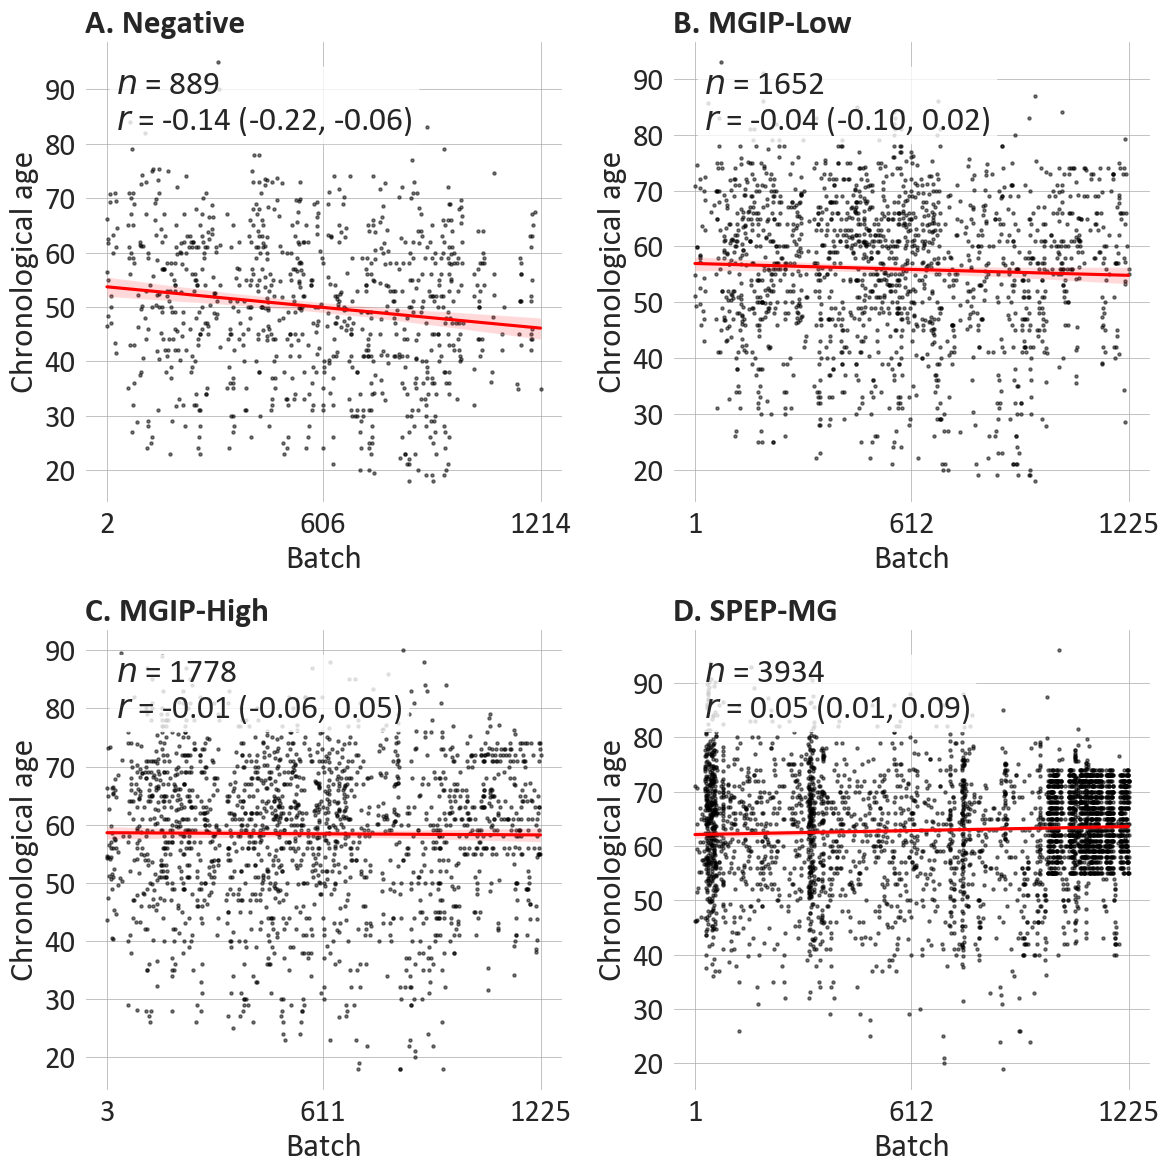

In [21]:
# is there any correlation between chrological age and batch number? => Supplementary Figure S3

negative_batch = pd.merge(pd.Series(negative_match_ids, name="ANON_ID"),
                          dataset_intraining[["ANON_ID", "Batch"]]).Batch.values
mgiplo_batch = dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"].Batch.values
mgiphi_batch = dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"].Batch.values
mgus_batch = dataset_outtraining[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"].Batch.values
plot_data = [[negative_trues, negative_preds, "A. Negative", "", negative_batch],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"], "B. MGIP-Low", "", mgiplo_batch],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"], "C. MGIP-High", "", mgiphi_batch],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"],
              positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"], "D. SPEP-MG", "", mgus_batch]]

plt.figure(figsize=(2 * pp_size, 2 * pp_size))
for i, (trues, _, suptitle, group_name, batches) in enumerate(plot_data):
    plt.subplot(2, 2, i + 1)
    plot_lm(x=batches, y=trues, group_name=group_name,
            xlabel="Batch", ylabel=trues_label,
            xticks=[min(batches), (max(batches) - min(batches)) // 2, max(batches)],
            yticks=trues_ticks_full_length,
            suptitle=suptitle,
            text_bbox_alpha=.8,
            scatter_kws_custom_alpha=.5,
            scatter_plot_custom_size=5,
            common_scale=False,
            confidence_level=.99)
plt.tight_layout()
plt.show()

Also, we can redo the same figure as **Supplementary Figure S2**, but this time using the BiAge predicting after masking the peaks from spectra, instead of using the original spectra

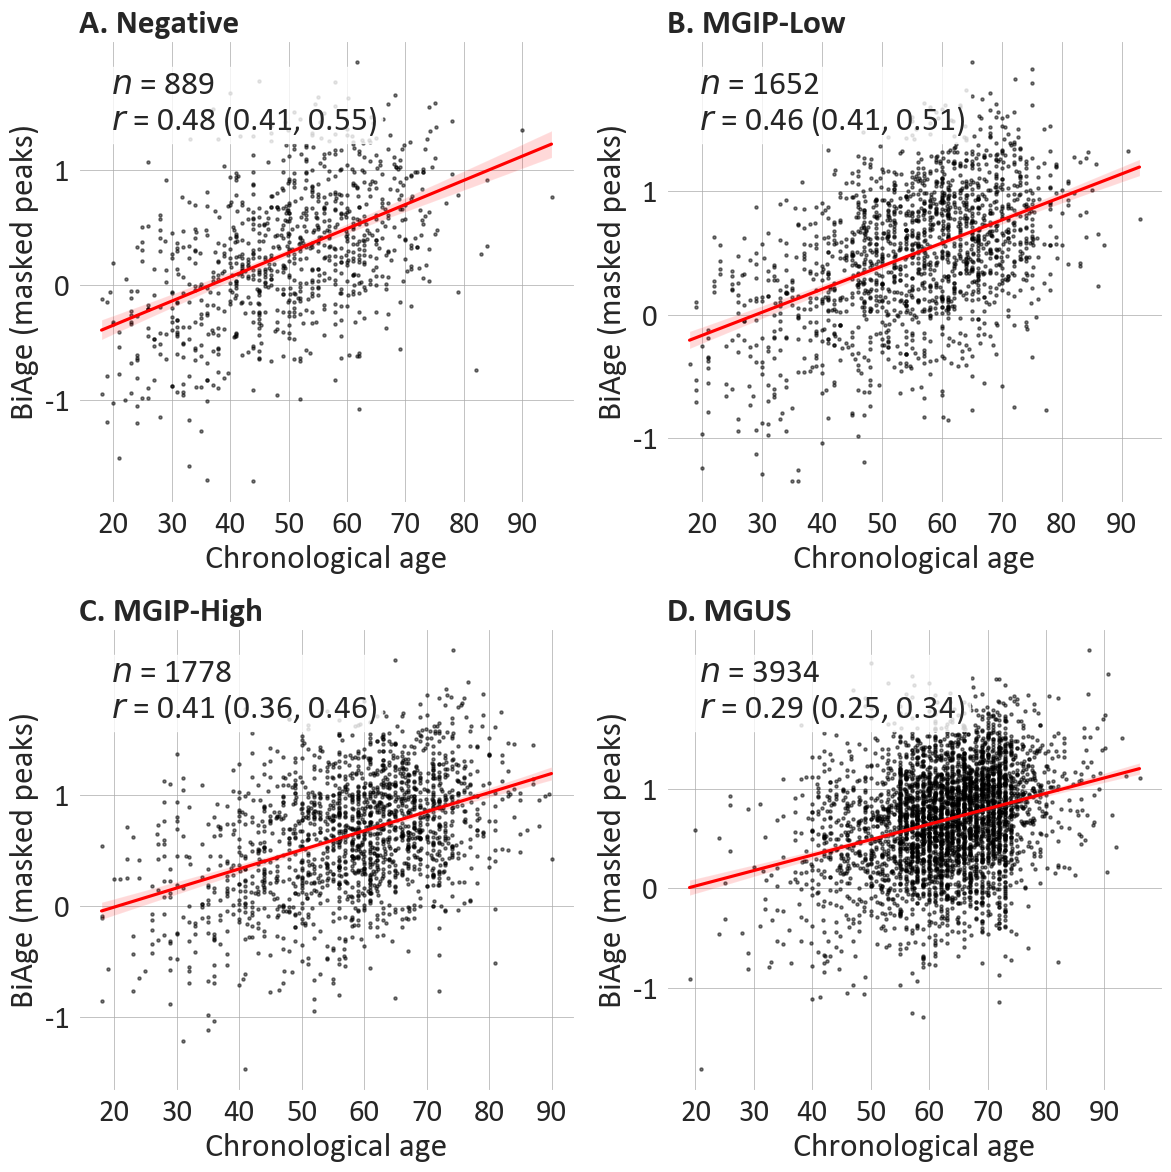

In [22]:
# same figure, but after masking peaks from the input data

plot_data = [[negative_trues, negative_preds_dropout, "A. Negative", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"],
              dropoutpeaks_positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-Low"], "B. MGIP-Low", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"],
              dropoutpeaks_positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGIP-High"], "C. MGIP-High", ""],
             [positive_trues[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"],
              dropoutpeaks_positive_preds[dataset_outtraining.GLOBAL_DIAGNOSIS == "MGUS"], "D. MGUS", ""]]

plt.figure(figsize=(2 * pp_size, 2 * pp_size))
for i, (trues, preds, suptitle, group_name) in enumerate(plot_data):
    plt.subplot(2, 2, i + 1)
    plot_lm(x=trues, y=preds, group_name=group_name,
            xlabel=trues_label, ylabel=peak_method_2_label[PREDS_COLNAME + " (peaks dropped out)"],
            xticks=trues_ticks_full_length,
            yticks=peak_method_ticks,
            suptitle=suptitle,
            text_bbox_alpha=.8,
            scatter_kws_custom_alpha=.5,
            scatter_plot_custom_size=5,
            common_scale=False,
            confidence_level=.99)
plt.tight_layout()
plt.show()

To evaluate the impact of the number of monoclonal peaks in spectra in BiAge prediction, we can also visualize the BiAge predicted for patients according to the nubmer of peaks using a box plot

Since the representation of p-values in boxplots is simple (using stars), we below define a small function to use the data used for creating the box plots to also compute actual p values using mann whitney test and display those p-values

In [23]:
def boxplot_mannwhitney_test(ax, box_pairs, **kwargs):
    if kwargs["hue"] is None:
        for pair in box_pairs:
            left_values = kwargs["data"].loc[kwargs["data"][kwargs["x"]] == pair[0], kwargs["y"]].values
            right_values = kwargs["data"].loc[kwargs["data"][kwargs["x"]] == pair[1], kwargs["y"]].values
            p = stats.mannwhitneyu(left_values, right_values).pvalue
            print(
                f"Comparing x={pair[0]} (n={len(left_values)}, mean y: {np.mean(left_values):.2g}) vs. x={pair[1]} (n={len(right_values)}, mean y: {np.mean(right_values):.2g}): {p=:.2g}")
    else:
        for pair in box_pairs:
            left_values = kwargs["data"].loc[(kwargs["data"][kwargs["x"]] == pair[0][0]) & (kwargs["data"][kwargs["hue"]] == pair[0][1]), kwargs["y"]].values
            right_values = kwargs["data"].loc[(kwargs["data"][kwargs["x"]] == pair[1][0]) & (kwargs["data"][kwargs["hue"]] == pair[1][1]), kwargs["y"]].values
            p = stats.mannwhitneyu(left_values, right_values).pvalue
            print(
                f"Comparing x={pair[0]} and hue={pair[1]} (n={len(left_values)}, mean y: {np.mean(left_values):.2g}) vs. x={pair[1]} (n={len(right_values)}, mean y: {np.mean(right_values):.2g}): {p=:.2g}")


Then we can assess the impact of the number of peaks in spectra in BiAge prediction. This is **Supplementary Figure S7** in the manuscript

C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.327e-74 U_stat=1.430e+06


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:4.314e-120 U_stat=5.730e+05


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:1.285e-120 U_stat=1.772e+05


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.636e-81 U_stat=6.085e+04


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 5+: Mann-Whitney-Wilcoxon test two-sided, P_val:1.314e-71 U_stat=4.136e+04


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


For peak_method='Age score'
Comparing x=0 (n=1099, mean y: 0.047) vs. x=1 (n=4058, mean y: 0.44): p=1.3e-74
Comparing x=0 (n=1099, mean y: 0.047) vs. x=2 (n=2091, mean y: 0.6): p=4.3e-120
Comparing x=0 (n=1099, mean y: 0.047) vs. x=3 (n=843, mean y: 0.73): p=1.3e-120
Comparing x=0 (n=1099, mean y: 0.047) vs. x=4 (n=346, mean y: 0.83): p=2.6e-81
Comparing x=0 (n=1099, mean y: 0.047) vs. x=5+ (n=261, mean y: 0.9): p=1.3e-71


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the m

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.121e-39 U_stat=1.653e+06


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 2: Mann-Whitney-Wilcoxon test two-sided, P_val:5.777e-73 U_stat=7.024e+05


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.362e-81 U_stat=2.298e+05


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.022e-56 U_stat=8.270e+04


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0 vs. 5+: Mann-Whitney-Wilcoxon test two-sided, P_val:4.058e-52 U_stat=5.677e+04


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


For peak_method='Age score (peaks dropped out)'
Comparing x=0 (n=1099, mean y: 0.29) vs. x=1 (n=4058, mean y: 0.54): p=1.1e-39
Comparing x=0 (n=1099, mean y: 0.29) vs. x=2 (n=2091, mean y: 0.68): p=5.8e-73
Comparing x=0 (n=1099, mean y: 0.29) vs. x=3 (n=843, mean y: 0.8): p=5.4e-81
Comparing x=0 (n=1099, mean y: 0.29) vs. x=4 (n=346, mean y: 0.88): p=1e-56
Comparing x=0 (n=1099, mean y: 0.29) vs. x=5+ (n=261, mean y: 0.93): p=4.1e-52


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


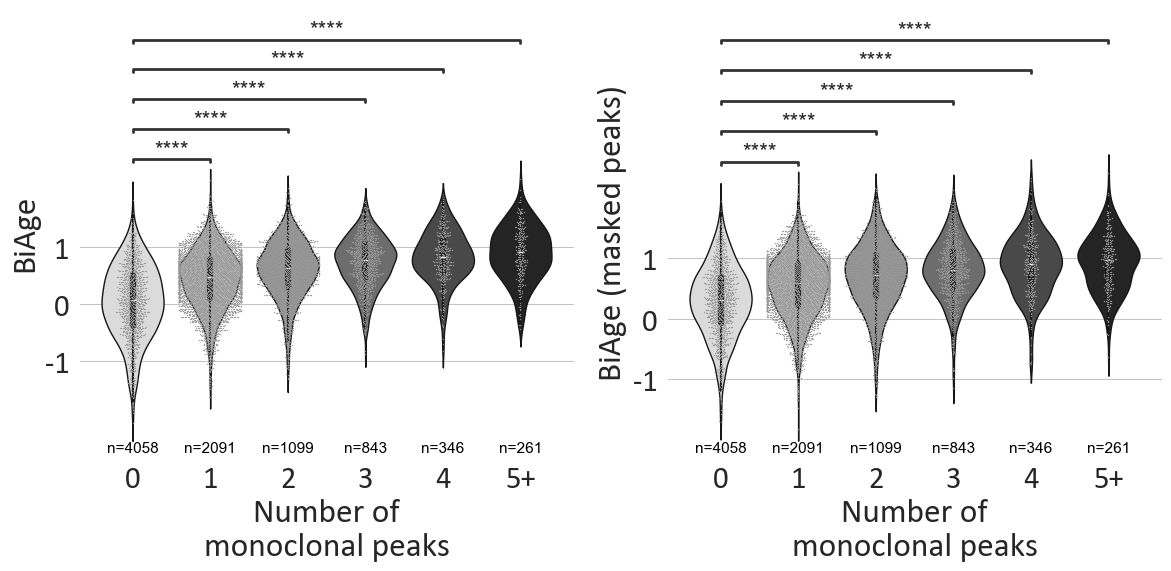

In [24]:
# Supplementary Figure S7
# check the impact of the number of monoclonal peaks on BiAge

biage_number_peaks_df = pd.concat([pd.Series(np.concatenate([np.array([0, ] * len(negative_trues)),
                                                             dataset_outtraining.N_Peaks_above_LLMI.values]), name="n_peaks"),
                                   pd.Series(np.concatenate([negative_preds,
                                                             positive_preds]), name="Age score"),
                                   pd.Series(np.concatenate([negative_trues,
                                                             positive_trues]), name="Age"),
                                   pd.Series(np.concatenate([negative_preds_dropout,
                                                             dropoutpeaks_positive_preds]), name="Age score (peaks dropped out)")], axis=1)
biage_number_peaks_df.n_peaks = biage_number_peaks_df.n_peaks.apply(lambda x: f"{x}" if x < 5 else "5+").astype("category").cat.set_categories(
    ["0", "1", "2", "3", "4", "5+"])
box_pairs = [
    ("0", "1"),
    ("0", "2"),
    ("0", "3"),
    ("0", "4"),
    ("0", "5+"),
]

plt.figure(figsize=(pp_size * 2, pp_size))
for i, peak_method in enumerate(["Age score", "Age score (peaks dropped out)"]):
    plt.subplot(1, 2, i + 1)
    boxplot_kwargs = {"data": biage_number_peaks_df, "x": "n_peaks", "y": peak_method, "hue": None}

    ax = plot_box(**boxplot_kwargs, xlabel="Number of\nmonoclonal peaks",
                  ylabel="Age" if peak_method == "Age" else peak_method_2_label[peak_method],
                  yticks=[20, 45, 70, 95] if peak_method == "Age" else peak_method_ticks,
                  legend_off=True,
                  palette="binary",
                  # subtype="precise_violinplot",
                  subtype="precise_violinplot+swarmplot",
                  swarmsize=1,
                  display_n_obs=True,
                  )

    if statannotations_available:
        annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
        annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside',
                             line_width=2.0, line_height=.01, text_offset=0)
        annotator2.apply_and_annotate()
    print(f"For {peak_method=}")
    boxplot_mannwhitney_test(ax, box_pairs, **boxplot_kwargs)
plt.tight_layout()
plt.show()

## BiAge predictions on subsets of patients

So far, we computed and observed how BiAge is predicted in all patients, regardless of chronological age, race, ethnicity and sex. We did not assess the impact of those demographic covariates which may impact BiAge. Below, we will try to create balanced subsets of patients, by matching 1:1 patients by chronological age and/or sex and/or race and/or ethnicity and/or monoclonal gammopathy status, and compare the BiAge predicted for those patients.

To perform this, we will first declare a `create_balanced_df` function that will allow us to create a balanced dataset after matching 1:1 patients according to the selected criteria

In [25]:
def create_balanced_df(full_df: pd.DataFrame,
                       group_column,
                       pair_columns):
    """
    creates a balanced df out of a full df

    :param full_df: the original DF
    :param group_column: which column will be used to make groups, i.e. groups we want to compare
    :param pair_columns: which columns will be used for pairing, i.e. we want to have the same distribution for all those pair columns for each group that exists in our final cohort
    :return:
    """
    # group_column = {"name": "Group", "values": ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]}
    # pair_columns = [{"name": "Simplified_Batch", "values": []},
    #                 {"name": "RACE", "values": ["Black", "White"]},
    #                 {"name": "SEX", "values": ["F", "M"]},
    #                 {"name": "ETHNIC_GROUP", "values": ["Not Hispanic or Latino", "Hispanic or Latino"]},
    #                 {"name": "Age_rounded", "values": []}]

    full_df = full_df.copy()

    for coldata in [group_column, *pair_columns]:
        if len(coldata["values"]) > 0:
            full_df = full_df[full_df[coldata["name"]].isin(coldata["values"])]

    # to make the code lighter
    group_colname = group_column["name"]
    groups = full_df[group_colname].unique().tolist()
    n_groups = len(groups)

    # create a "pair label", i.e. a patient can be "black_female_61yo"
    full_df["Pair_Label"] = full_df[[m["name"] for m in pair_columns]].apply(concat_cols, axis=1)

    # group by both group and pair label, i.e. how many "black_female_61yo" in the "negative" vs "mgip" vs "mgus" groups
    group_results = full_df.groupby([group_colname, "Pair_Label"])["ANON_ID"].count().reset_index()

    # now we can determine which labels may be productive, we want to keep only labels for which all groups are represented
    group_results = group_results[group_results.groupby("Pair_Label")["ANON_ID"].transform("count") == n_groups]
    # now we can know how many samples we'll keep for each label: the minimum per group
    # e.g. if we have for the same pair label: 1 MGUS, 3 negs, 18 MGIP, we want to keep 1 of each so the groups are balanced
    group_results = group_results.groupby("Pair_Label")["ANON_ID"].min().reset_index()

    # finally we can create our balanced df

    pre_balanced_df = []
    for group in groups:
        for label, n in zip(group_results.Pair_Label, group_results.ANON_ID):
            subset = full_df[(full_df.Pair_Label == label) & (full_df[group_colname] == group)]
            pre_balanced_df.append(subset.sample(n, replace=False, random_state=1))

    balanced_df = pd.concat(pre_balanced_df, axis=0)
    print(f"{len(balanced_df)=}")

    return balanced_df

To use this function defined above, we will first use to create a `full_df`, i.e. a dataset containing all samples that might be of interest, meaning they have non-NA data filled in for the variables we want to use as criteria to match 1:1 patients (e.g. age, race, sex, etc.)
We will also add some metadata, for instance rounded Age (to match patients by approximate age, i.e. 50.3 and 50.1 years are +/- the same age)

Below we decare the different functions that will be useful for creating those datasets and required metadata/annotations

In [26]:
def add_pre_df_columns(pre_df):
    pre_df["SEX_Binary"] = pre_df["SEX"].map({"F": 1, "M": 0})
    pre_df["RACE_Black_Binary"] = pre_df["RACE"].map({"Black": 1, "White": 0})
    simple_cohorts_dict = {"mgb1.0": "MGB1",
                           "PSCR_USA": "PROMISE USA",
                           "PRM_South_Africa": "PROMISE SA",
                           "PLCO_MM_NIH1.0": "PLCO",
                           "PRES": "PROMISE USA",
                           "mgb2.0": "MGB2",
                           "PFOL": "PROMISE USA",
                           "PSCR": "PROMISE USA",
                           "PROMISE_PRES": "PROMISE USA"}
    pre_df["COHORT2_Simple"] = pre_df.COHORT2.map(simple_cohorts_dict)
    return pre_df


def create_pre_df(match_ids: list, the_trues, the_preds, the_preds_dropout, the_groups,
                  trues_colname, preds_colname, safetycheck_colname):
    pre_df = pd.DataFrame({"ANON_ID": match_ids}).merge(
        dataset[["ANON_ID", "Batch", "Simplified_Batch", "COHORT2", "RACE", "ETHNIC_GROUP", "SEX",
                 "GLOBAL_DIAGNOSIS",
                 "AGE", "MS_peak_conc_1",
                 "N_Peaks_above_LLMI", "Total_Peaks_Percent"]], on="ANON_ID", how="left"
    )
    # add some few metadata
    pre_df = add_pre_df_columns(pre_df)

    pre_df = pd.concat([pre_df, pd.Series(data=the_trues, name=trues_colname)], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_preds, name=preds_colname)], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_preds_dropout, name=f"{preds_colname} (peaks dropped out)")], axis=1)
    pre_df = pd.concat([pre_df, pd.Series(data=the_groups, name="Group")], axis=1)

    assert len(the_trues) == len(pre_df)  # check lengths match
    assert (pre_df[safetycheck_colname] - the_trues < 1e-3).all()  # check ages match

    return pre_df

def create_full_df(trues_colname, preds_colname, safetycheck_colname):
    negative_pre_df = create_pre_df(match_ids=negative_match_ids,
                                    the_trues=negative_trues,
                                    the_preds=negative_preds,
                                    the_preds_dropout=negative_preds_dropout,
                                    the_groups=["Negative", ] * len(negative_trues),
                                    trues_colname=trues_colname,
                                    preds_colname=preds_colname,
                                    safetycheck_colname=safetycheck_colname)
    positive_pre_df = create_pre_df(match_ids=positive_match_ids,
                                    the_trues=positive_trues,
                                    the_preds=positive_preds,
                                    the_preds_dropout=dropoutpeaks_positive_preds,
                                    the_groups=dataset_outtraining.GLOBAL_DIAGNOSIS.tolist(),
                                    trues_colname=trues_colname,
                                    preds_colname=preds_colname,
                                    safetycheck_colname=safetycheck_colname)
    full_df = pd.concat([negative_pre_df, positive_pre_df], axis=0)
    # add age range
    full_df["Age_rounded"] = full_df["AGE"].round()
    full_df["Age range"] = pd.cut(full_df['AGE'], bins=[0, 50, 65, 999], right=False).astype(str).map(
        {"[0, 50)": "<50", "[50, 65)": "50-65", "[65, 999)": ">65"})
    full_df["AGE_CLASS"] = "Out"
    full_df.loc[full_df.AGE < 50, "AGE_CLASS"] = "<50"
    full_df.loc[full_df.AGE > 65, "AGE_CLASS"] = ">65"
    full_df["Self-declared race"] = full_df["RACE_Black_Binary"].map({1: "Black/African American", 0: "White/European"})

    # remove LC-MGUS -> we have too few, and they will just ruin the numbers when we balance
    full_df = full_df[full_df.Group != "LC-MGUS"].copy()

    return full_df


def quick_create_pair_columns(race, sex, ethnic_group, age, diag, sbatch, ebatch, only_neg):
    pair_columns = []
    if race:
        pair_columns.append({"name": "RACE", "values": ["Black", "White"]})
    if sbatch:
        pair_columns.append({"name": "Simplified_Batch", "values": []})
    if ebatch:
        pair_columns.append({"name": "Batch", "values": []})
    if sex:
        pair_columns.append({"name": "SEX", "values": ["F", "M"]})
    if ethnic_group:
        pair_columns.append({"name": "ETHNIC_GROUP", "values": ["Not Hispanic or Latino", "Hispanic or Latino"]})
    if diag:
        if only_neg:
            pair_columns.append({"name": "GLOBAL_DIAGNOSIS", "values": ["Negative", ]})
        else:
            pair_columns.append({"name": "GLOBAL_DIAGNOSIS", "values": ["Negative", "MGIP-Low", "MGIP-High", "MGUS", ]})
    if age:
        pair_columns.append({"name": "Age_rounded", "values": []})
    return pair_columns


def concat_cols(vals):
    concat_text = "_".join([v if type(v) is str else f"{v:.0f}" for v in vals])
    return concat_text



Now, we can create a balanced dataset by matching patients by race, sex, ehtnicity, chronological age, and simplified batch (i.e. the year the sample was processed). Meaning, in each group (negative vs. positive), patients will be matched 1:1 according to the criteria previously listed.

In [27]:
# PAIR_APPROACH = "AGE_RACE_ETHNICITY_SEX_SIMPBATCH"
ANALYSIS_BY = "Group"
PAIR_PARAMETERS = dict(race=True, sex=True, ethnic_group=True, age=True, diag=False, sbatch=True, ebatch=False, only_neg=False)
groups_ordered_values = ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]

balanced_df = create_balanced_df(full_df=create_full_df(trues_colname=TRUES_COLNAME,
                                                        preds_colname=PREDS_COLNAME,
                                                        safetycheck_colname=SAFETYCHECK_COLNAME),
                                 group_column={"name": ANALYSIS_BY, "values": groups_ordered_values},
                                 pair_columns=quick_create_pair_columns(**PAIR_PARAMETERS))

balanced_df.drop(columns="ANON_ID")

len(balanced_df)=1504


Batch  Simplified_Batch         COHORT2   RACE            ETHNIC_GROUP  \
145     357                 1          mgb1.0  Black  Not Hispanic or Latino   
629     184                 1          mgb1.0  Black  Not Hispanic or Latino   
56      568                 1          mgb1.0  Black  Not Hispanic or Latino   
671     606                 1          mgb1.0  Black  Not Hispanic or Latino   
872     471                 1          mgb1.0  Black  Not Hispanic or Latino   
...     ...               ...             ...    ...                     ...   
6296   1135                 3  PLCO_MM_NIH1.0  White  Not Hispanic or Latino   
2401    900                 3          mgb2.0  White  Not Hispanic or Latino   
6383   1087                 3  PLCO_MM_NIH1.0  White  Not Hispanic or Latino   
4180   1105                 3            PFOL  White  Not Hispanic or Latino   
4059    975                 3            PFOL  White  Not Hispanic or Latino   

     SEX GLOBAL_DIAGNOSIS        AGE  MS_peak_conc_1  N_Peaks_above_LLMI  ...  \
145    F         Negative  28.000000             NaN                   0  ...   
629    F         Negative  29.000000           0.005                   0  ...   
56     F         Negative  34.000000             NaN                   0  ...   
671    F         Negative  35.000000             NaN                   0  ...   
872    F         Negative  35.000000             NaN                   0  ...   
...   ..              ...        ...             ...                 ...  ...   
6296   F        MGIP-High  70.000000           0.164                   2  ...   
2401   F        MGIP-High  75.000000           0.065                   1  ...   
6383   M        MGIP-High  60.000000           0.170                   2  ...   
4180   M        MGIP-High  61.956164           0.130                   2  ...   
4059   M        MGIP-High  62.167123           0.047                   2  ...   

      COHORT2_Simple        Age  Age score Age score (peaks dropped out)  \
145             MGB1  28.000000   0.292444                      0.416100   
629             MGB1  29.000000   0.709473                      0.921634   
56              MGB1  34.000000   0.208061                      0.303888   
671             MGB1  35.000000  -0.305332                      0.010241   
872             MGB1  35.000000  -0.941498                     -0.614001   
...              ...        ...        ...                           ...   
6296            PLCO  70.000000   0.549511                      0.359536   
2401            MGB2  75.000000   1.005090                      1.018190   
6383            PLCO  60.000000   0.558472                     -0.017217   
4180     PROMISE USA  61.956164   0.858365                      0.251786   
4059     PROMISE USA  62.167123   0.531926                      0.336833   

          Group  Age_rounded  Age range AGE_CLASS      Self-declared race  \
145    Negative         28.0        <50       <50  Black/African American   
629    Negative         29.0        <50       <50  Black/African American   
56     Negative         34.0        <50       <50  Black/African American   
671    Negative         35.0        <50       <50  Black/African American   
872    Negative         35.0        <50       <50  Black/African American   
...         ...          ...        ...       ...                     ...   
6296  MGIP-High         70.0        >65       >65          White/European   
2401  MGIP-High         75.0        >65       >65          White/European   
6383  MGIP-High         60.0      50-65       Out          White/European   
4180  MGIP-High         62.0      50-65       Out          White/European   
4059  MGIP-High         62.0      50-65       Out          White/European   

                               Pair_Label  
145   Black_1_F_Not Hispanic or Latino_28  
629   Black_1_F_Not Hispanic or Latino_29  
56    Black_1_F_Not Hispanic or Latino_34  
671   Black_1_F_Not Hispanic or Latino_35  
872   Black_1_

In [28]:
if balanced_df["Total_Peaks_Percent"].max() < 1:
    balanced_df["Total_Peaks_Percent"] = balanced_df["Total_Peaks_Percent"] * 100  # convert 0-1 to 0-100% scale

For those patients, we can look at the correlation between BiAge predicted without or after masking peaks

C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\_lib\_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\scipy\_lib\_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  return fun(*args, **kwargs)
C:\Users\flo

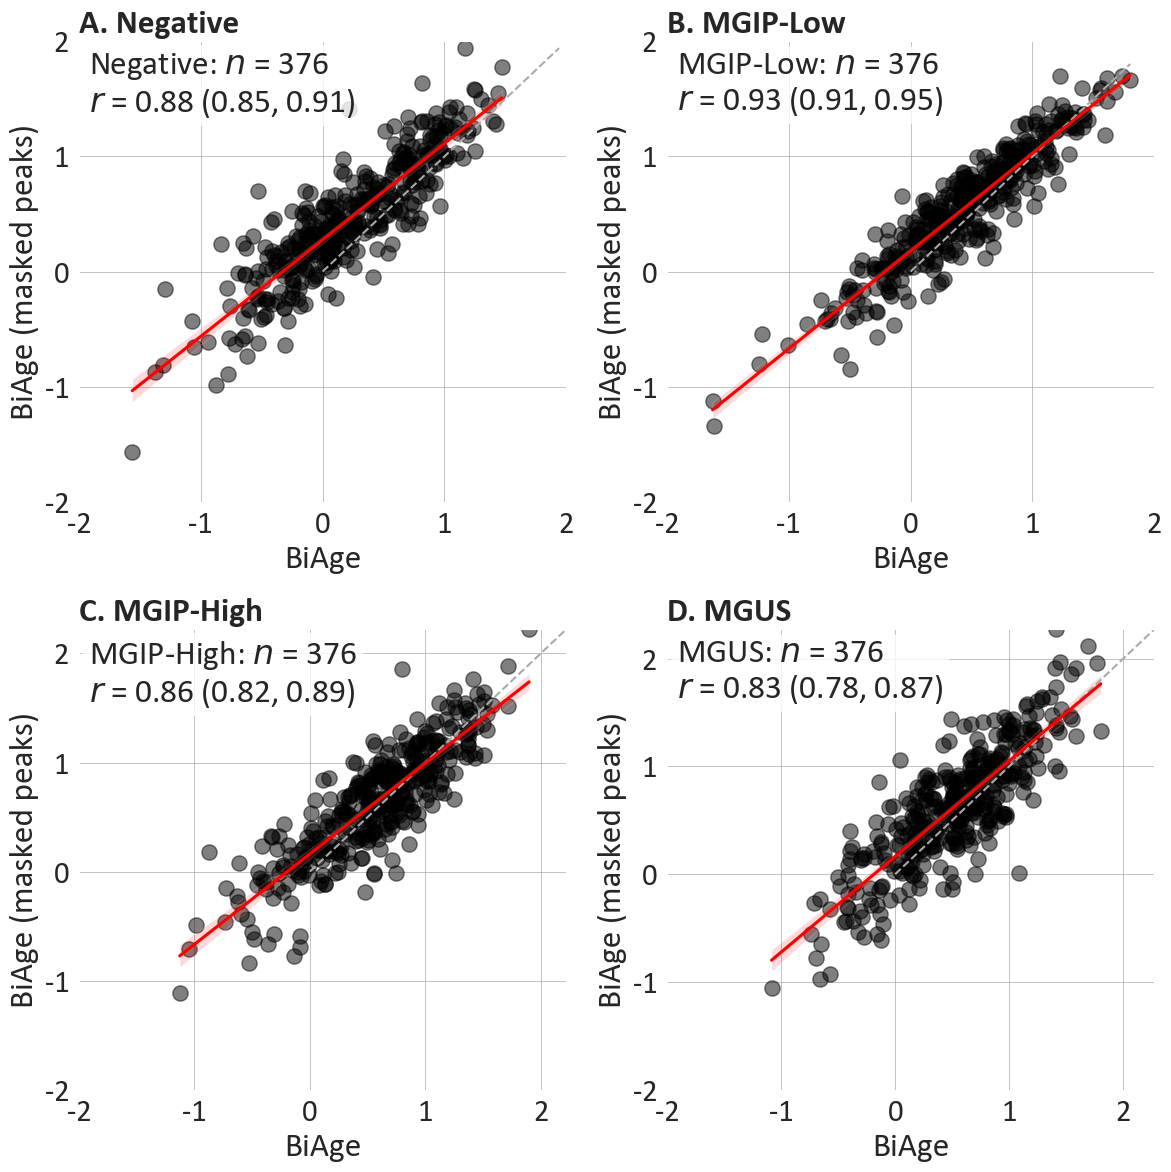

In [29]:
# correlation: biage vs biage when peaks are removed (not in the current manuscript figures but useful)

peak_method_base = "Age score"
peak_method_compare = "Age score (peaks dropped out)"
plt.figure(figsize=(pp_size * 2, pp_size * 2))
# gs = gridspec.GridSpec(1, 2)
for j, group in enumerate(["Negative", "MGIP-Low", "MGIP-High", "MGUS"]):
    # plt.subplot(gs[0,j])
    plt.subplot(2, 2, j + 1)
    x = balanced_df[balanced_df.Group == group][peak_method_base].to_numpy()
    y = balanced_df[balanced_df.Group == group][peak_method_compare].to_numpy()
    plot_lm(x=x, y=y, group_name=group, xlabel=peak_method_2_label["Age score"], ylabel=peak_method_2_label[peak_method_compare],
            xticks=[-2, -1, 0, 1, 2], yticks=[-2, -1, 0, 1, 2],
            suptitle="ABCD"[j] + ". " + group,
            common_scale=True,
            text_bbox_alpha=.8,
            confidence_level=.99)
plt.tight_layout()
plt.show()

Now that we have a balanced dataset, with negative and positive samples matched 1:1, we can compute the BiAge of patients according to their MG group
If MG has no impact on predicted BiAge, the BiAge distributions predicted for all groups should be similar, since patients in each group have the same characteristics (same age, race, sex, ethnicity distribution)

This is **Figure 2** in the manuscript

C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<50 years_Negative vs. <50 years_MGIP-Low: Mann-Whitney-Wilcoxon test two-sided, P_val:1.247e-03 U_stat=4.349e+03
>65 years_Negative vs. >65 years_MGIP-Low: Mann-Whitney-Wilcoxon test two-sided, P_val:2.689e-03 U_stat=2.649e+03
<50 years_Negative vs. <50 years_MGIP-High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.486e-06 U_stat=3.621e+03
>65 years_Negative vs. >65 years_MGIP-High: Mann-Whitney-Wilcoxon test two-sided, P_val:1.726e-05 U_stat=2.233e+03
<50 years_Negative vs. <50 years_MGUS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.745e-07 U_stat=3.432e+03
>65 years_Negative vs. >65 years_MGUS: Mann-Whitney-Wilcoxon test two-sided, P_val:3.383e-04 U_stat=2.462e+03
Comparing x=('<50 years', 'Negative') and hue=('<50 years', 'MGIP-Low') (n=108, mean y: -0.071) vs. x=('<50 years', 'MGIP-Low') (n

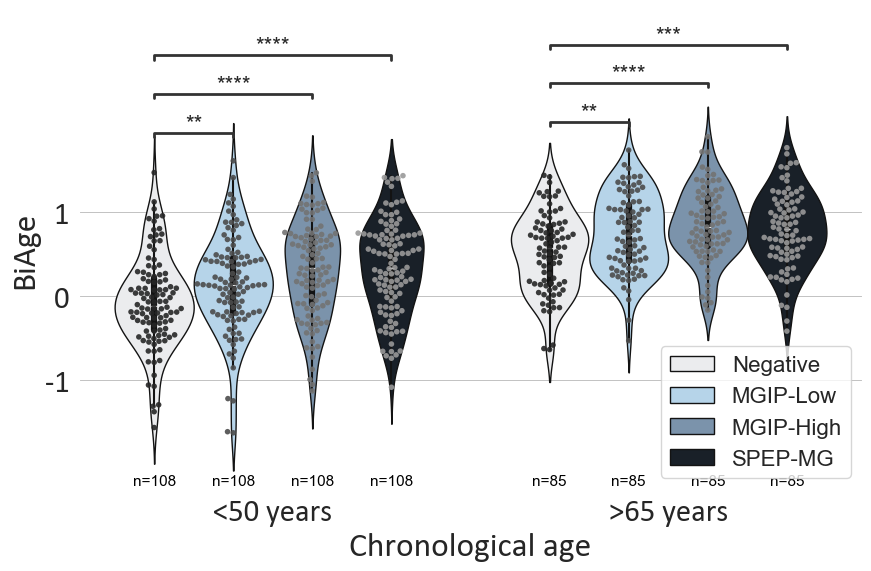

C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<50 years_Negative vs. <50 years_MGIP-Low: Mann-Whitney-Wilcoxon test two-sided, P_val:2.445e-01 U_stat=5.297e+03
>65 years_Negative vs. >65 years_MGIP-Low: Mann-Whitney-Wilcoxon test two-sided, P_val:2.740e-01 U_stat=3.261e+03
<50 years_Negative vs. <50 years_MGIP-High: Mann-Whitney-Wilcoxon test two-sided, P_val:6.304e-03 U_stat=4.577e+03
>65 years_Negative vs. >65 years_MGIP-High: Mann-Whitney-Wilcoxon test two-sided, P_val:2.857e-02 U_stat=2.910e+03
<50 years_Negative vs. <50 years_MGUS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.855e-03 U_stat=4.402e+03
>65 years_Negative vs. >65 years_MGUS: Mann-Whitney-Wilcoxon test two-sided, P_val:1.926e-02 U_stat=2.861e+03
Comparing x=('<50 years', 'Negative') and hue=('<50 years', 'MGIP-Low') (n=108, mean y: 0.24) vs. x=('<50 years', 'MGIP-Low') (n=1

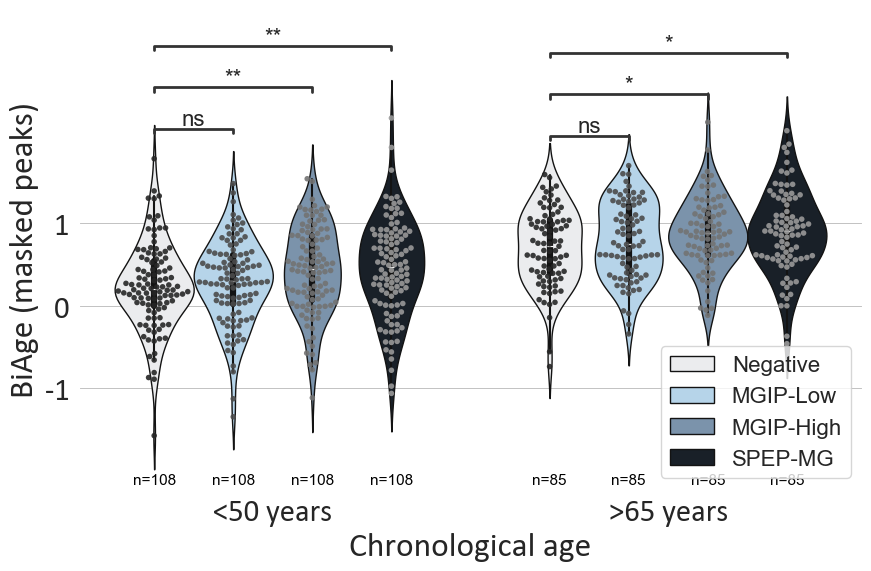

In [30]:
# FIGURE 2A AND 2D

for peak_method in ("Age score", "Age score (peaks dropped out)"):
    # check which patients are below 50 or above 65
    boxplot_data = balanced_df[(balanced_df.Age_rounded <= 50) | (balanced_df.Age_rounded >= 65)].copy()
    # reorder
    boxplot_data["Age range"].value_counts()
    format_age = lambda x: "<50 years" if x <= 50 else ">65 years" if x >= 65 else "err"

    boxplot_data["Age range"] = boxplot_data.Age_rounded.map(format_age)
    boxplot_data["Age range"] = boxplot_data["Age range"].astype("category").cat.set_categories(["<50 years", ">65 years"])
    boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["Negative", "MGIP-Low", "MGIP-High", "MGUS"])

    box_pairs = [
        (("<50 years", "Negative"), ("<50 years", "MGIP-Low")),
        (("<50 years", "Negative"), ("<50 years", "MGIP-High")),
        (("<50 years", "Negative"), ("<50 years", "MGUS")),
        ((">65 years", "Negative"), (">65 years", "MGIP-Low")),
        ((">65 years", "Negative"), (">65 years", "MGIP-High")),
        ((">65 years", "Negative"), (">65 years", "MGUS")),
    ]
    boxplot_kwargs = {"data": boxplot_data, "x": "Age range", "y": peak_method, "hue": "Group"}
    plt.figure(figsize=(pp_size * 1.5, pp_size))
    ax = plot_box(**boxplot_kwargs,
                  yticks=[-1, 0, 1],
                  xlabel=trues_label,
                  palette="mg_custom_cmap",  # 12.27 => replaced binary
                  ylabel=peak_method_2_label[peak_method],
                  legend_loc="outside",
                  # subtype="precise_violinplot",
                  subtype="precise_violinplot+swarmplot",
                  swarmsize=4,
                  )
    # manually change the "MGUS" legend
    handles, labels = ax.get_legend_handles_labels()
    labels = ["SPEP-MG" if l == "MGUS" else l for l in labels]
    ax.legend(handles, labels)

    if statannotations_available:
        annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
        annotator2.configure(test='Mann-Whitney', loc='inside', text_format='star',
                             line_width=2.0, line_height=.01, text_offset=0)
        annotator2.apply_and_annotate()
    boxplot_mannwhitney_test(ax, box_pairs, **boxplot_kwargs)

    plt.tight_layout()
    plt.show()

Next, we can recreate a new balanced dataset, this time matching patients with different race (i.e. a black and a white group, each group with the same distribution of the other characteristics)

In [31]:
# PAIR_APPROACH = "AGE_SEX_ETHNICITY_SIMPBATCH_MG_BY_RACE"

ANALYSIS_BY = "RACE"
groups_ordered_values = ["Black", "White"]
ANALYSIS_BY_PLACEHOLDER = "Self-declared race"
groups_ordered_values_placeholder = ["Black/AA", "White/Eur"]
placeholder_dict = {"Black": "Black/AA", "White": "White/Eur"}
PAIR_PARAMETERS = dict(race=False, sex=True, ethnic_group=True, age=True, diag=True, sbatch=True, ebatch=False, only_neg=False)

balanced_df = create_balanced_df(full_df=create_full_df(trues_colname=TRUES_COLNAME,
                                                        preds_colname=PREDS_COLNAME,
                                                        safetycheck_colname=SAFETYCHECK_COLNAME),
                                 group_column={"name": ANALYSIS_BY, "values": groups_ordered_values},
                                 pair_columns=quick_create_pair_columns(**PAIR_PARAMETERS))

balanced_df.drop(columns="ANON_ID")

len(balanced_df)=3350


Batch  Simplified_Batch           COHORT2   RACE  \
2593    534                 1          PSCR_USA  White   
3147    203                 1          PSCR_USA  White   
1928    122                 1            mgb1.0  White   
992     267                 1            mgb1.0  White   
1846    558                 1            mgb1.0  White   
...     ...               ...               ...    ...   
4823    971                 3  PRM_South_Africa  Black   
5858   1023                 3    PLCO_MM_NIH1.0  Black   
4226   1111                 3              PFOL  Black   
112     931                 3  PRM_South_Africa  Black   
149    1054                 3  PRM_South_Africa  Black   

                ETHNIC_GROUP SEX GLOBAL_DIAGNOSIS        AGE  MS_peak_conc_1  \
2593      Hispanic or Latino   F         MGIP-Low  50.937714           0.017   
3147      Hispanic or Latino   F         MGIP-Low  64.473648           0.035   
1928  Not Hispanic or Latino   F        MGIP-High  27.000000           0.056   
992   Not Hispanic or Latino   F        MGIP-High  28.000000           0.044   
1846  Not Hispanic or Latino   F        MGIP-High  29.000000           0.105   
...                      ...  ..              ...        ...             ...   
4823  Not Hispanic or Latino   M             MGUS  74.000000           0.950   
5858  Not Hispanic or Latino   M             MGUS  74.000000           0.538   
4226  Not Hispanic or Latino   M             MGUS  75.049180           5.350   
112   Not Hispanic or Latino   M         Negative  40.000000             NaN   
149   Not Hispanic or Latino   M         Negative  60.000000             NaN   

      N_Peaks_above_LLMI  ...  COHORT2_Simple        Age  Age score  \
2593                   1  ...     PROMISE USA  50.937714   0.855175   
3147                   1  ...     PROMISE USA  64.473648   0.174766   
1928                   2  ...            MGB1  27.000000  -0.267862   
992                    1  ...            MGB1  28.000000  -0.549703   
1846                   1  ...            MGB1  29.000000  -0.917734   
...                  ...  ...             ...        ...        ...   
4823                   1  ...      PROMISE SA  74.000000   0.340866   
5858                   6  ...            PLCO  74.000000   1.229542   
4226                   3  ...     PROMISE USA  75.049180   1.033108   
112                    0  ...      PROMISE SA  40.000000   0.242215   
149                    0  ...      PROMISE SA  60.000000   0.068289   

     Age score (peaks dropped out)      Group  Age_rounded  Age range  \
2593                      0.765782   MGIP-Low         51.0      50-65   
3147                      0.463332   MGIP-Low         64.0      50-65   
1928                     -0.306168  MGIP-High         27.0        <50   
992                      -0.259927  MGIP-High         28.0        <50   
1846                     -0.462382  MGIP-High         29.0        <50   
...                            ...        ...          ...        ...   
4823                      0.193582       MGUS         74.0        >65   
5858                      0.840462       MGUS         74.0        >65   
4226                      1.411067       MGUS         75.0        >65   
112                       0.316522   Negative         40.0        <50   
149                       0.409010   Negative         60.0      50-65   

     AGE_CLASS      Self-declared race  \
2593       Out          White/European   
3147       Out          White/European   
1928       <50          White/European   
992        <50          White/European   
1846       <50          White/European   
...        ...                     ...   
4823       >65  Black/African American   
5858       >65  Black/African American   
4226       >65  Black/African American   
112        <50  Black/African American   
149        Out  Black/African American   

                                   Pair_Label  
2593       1_F_Hispanic or Latino_MGIP-Low_51  
3147       1_F_Hi

So we can now plot the BiAge in participants according to race, without other characteristic/pathology interfering. This is **Supplementary Figure S5 A** in the manuscript

For convenience, we will design a function to perform the box plot, and re-use this function multiple time for different figures

In [32]:
def boxplot_predicted_quantative_versus_gt_class_subroutine(balanced_df, peak_method, peak_method_ticks,
                                                            ANALYSIS_BY, groups_ordered_values,
                                                            placeholder_dict,
                                                            ANALYSIS_BY_PLACEHOLDER, groups_ordered_values_placeholder,
                                                            peak_method_2_label,
                                                            separate_mgs_into_hue,
                                                            add_carreturn: bool = True,
                                                            swarmsize=None,
                                                            ax=None):
    boxplot_data = balanced_df[balanced_df[ANALYSIS_BY].isin(groups_ordered_values)].copy()
    # convert if needed
    if placeholder_dict is not None:
        boxplot_data[ANALYSIS_BY_PLACEHOLDER] = boxplot_data[ANALYSIS_BY].map(placeholder_dict)
    # reorder and convert our analysis by group to category
    boxplot_data[ANALYSIS_BY_PLACEHOLDER] = boxplot_data[ANALYSIS_BY_PLACEHOLDER].astype("category").cat.set_categories(
        groups_ordered_values_placeholder)
    if separate_mgs_into_hue:
        # which groups we will compare => also convert to category
        if "Negative" in boxplot_data.Group.unique():
            if add_carreturn:
                boxplot_data.Group = boxplot_data.Group.map(
                    {"Negative": "Negative", "MGIP-Low": "MGIP\nLow", "MGIP-High": "MGIP\nHigh", "MGUS": "MGUS"}
                ).astype("category").cat.set_categories(["Negative", "MGIP\nLow", "MGIP\nHigh", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["Negative", "MGIP\nLow", "MGIP\nHigh", "MGUS"]]
            else:
                boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["Negative", "MGIP-Low", "MGIP-High", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["Negative", "MGIP-Low", "MGIP-High", "MGUS"]]
        else:
            if add_carreturn:
                boxplot_data.Group = boxplot_data.Group.map(
                    {"MGIP-Low": "MGIP\nLow", "MGIP-High": "MGIP\nHigh", "MGUS": "MGUS"}
                ).astype("category").cat.set_categories(["MGIP\nLow", "MGIP\nHigh", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["MGIP\nLow", "MGIP\nHigh", "MGUS"]]
            else:
                boxplot_data.Group = boxplot_data.Group.astype("category").cat.set_categories(["MGIP-Low", "MGIP-High", "MGUS"])
                # create the dict for parameters used for plotting
                boxplot_kwargs = {"data": boxplot_data, "hue": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "x": "Group"}
                # how we will annotate (p values)
                box_pairs = [[(mg, grp,) for grp in groups_ordered_values_placeholder] for mg in
                             ["MGIP-Low", "MGIP-High", "MGUS"]]
        legend_off = False
        figname = f"boxplot_bymg_{peak_method}.png"
    else:
        # create the dict for parameters used for plotting
        boxplot_kwargs = {"data": boxplot_data, "x": ANALYSIS_BY_PLACEHOLDER, "y": peak_method, "hue": None}
        # how we will annotate (p values)
        box_pairs = [(*groups_ordered_values_placeholder,), ]
        legend_off = True  # no hue
        width = pp_size
        figname = f"boxplot_allmg_{peak_method}.png".replace("/", "_")

    # ax = sns.boxplot(**boxplot_kwargs)
    ax = plot_box(**boxplot_kwargs,
                  yticks=peak_method_ticks,
                  xlabel=boxplot_kwargs["x"],
                  ylabel=peak_method_2_label[peak_method],
                  palette="binary",
                  legend_off=legend_off,
                  legend_loc="outside",
                  # subtype="precise_violinplot",
                  subtype="precise_violinplot+swarmplot",
                  swarmsize=swarmsize,
                  ax=ax,
                  )
    # stars
    if statannotations_available:
        annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
        annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside',
                             line_width=2.0, line_height=.01, text_offset=0)
        annotator2.apply_and_annotate()

    return ax, figname

Supplementary Figures S5 A (BiAge according to race)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Black/AA vs. White/Eur: Mann-Whitney-Wilcoxon test two-sided, P_val:7.520e-01 U_stat=9.179e+03


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


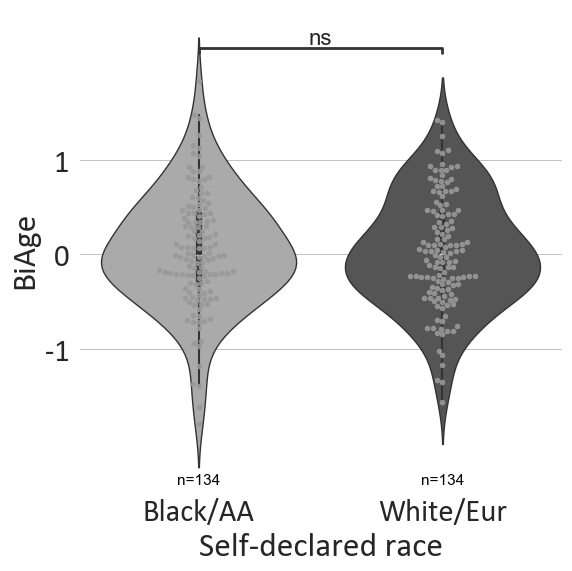

In [33]:
# SUPPLEMENTARY FIGURE S5 A

plt.figure(figsize=(pp_size, pp_size))
boxplot_predicted_quantative_versus_gt_class_subroutine(
    balanced_df=balanced_df[balanced_df.GLOBAL_DIAGNOSIS == "Negative"],
    peak_method="Age score",
    peak_method_ticks=peak_method_ticks,
    ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
    placeholder_dict=placeholder_dict,
    ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
    groups_ordered_values_placeholder=groups_ordered_values_placeholder,
    peak_method_2_label=peak_method_2_label,
    separate_mgs_into_hue=False,
    add_carreturn=False,
    swarmsize=4,
    ax=None)
plt.tight_layout()
plt.show()

If we do the same after grouping by sex, we obtain **Supplementary Figure S5 B** in the manuscript

In [34]:
# PAIR_APPROACH = "AGE_RACE_ETHNICITY_SIMPBATCH_MG_BY_SEX"
ANALYSIS_BY = "SEX"
groups_ordered_values = ["F", "M"]
PAIR_PARAMETERS = dict(race=True, sex=False, ethnic_group=True, age=True, diag=True, sbatch=True, ebatch=False, only_neg=False)
ANALYSIS_BY_PLACEHOLDER = "Sex"
groups_ordered_values_placeholder = ["Female", "Male"]
placeholder_dict = {"F": "Female", "M": "Male"}

balanced_df = create_balanced_df(full_df=create_full_df(trues_colname=TRUES_COLNAME,
                                                        preds_colname=PREDS_COLNAME,
                                                        safetycheck_colname=SAFETYCHECK_COLNAME),
                                 group_column={"name": ANALYSIS_BY, "values": groups_ordered_values},
                                 pair_columns=quick_create_pair_columns(**PAIR_PARAMETERS))

balanced_df.drop(columns="ANON_ID")

len(balanced_df)=4352


Batch  Simplified_Batch   COHORT2   RACE            ETHNIC_GROUP SEX  \
235     494                 1    mgb1.0  Black  Not Hispanic or Latino   M   
851     343                 1    mgb1.0  Black  Not Hispanic or Latino   M   
211     497                 1    mgb1.0  Black  Not Hispanic or Latino   M   
516     500                 1    mgb1.0  Black  Not Hispanic or Latino   M   
1362    395                 1    mgb1.0  Black  Not Hispanic or Latino   M   
...     ...               ...       ...    ...                     ...  ..   
4306   1112                 3      PFOL  White  Not Hispanic or Latino   F   
2377    960                 3    mgb2.0  White  Not Hispanic or Latino   F   
3759    994                 3  PSCR_USA  White  Not Hispanic or Latino   F   
477    1029                 3      PSCR  White  Not Hispanic or Latino   F   
734     884                 3  PSCR_USA  White  Not Hispanic or Latino   F   

     GLOBAL_DIAGNOSIS        AGE  MS_peak_conc_1  N_Peaks_above_LLMI  ...  \
235         MGIP-High  27.000000           0.067                   1  ...   
851         MGIP-High  27.000000           0.067                   1  ...   
211         MGIP-High  28.000000           0.099                   3  ...   
516         MGIP-High  30.000000           0.141                   1  ...   
1362        MGIP-High  30.000000           0.055                   3  ...   
...               ...        ...             ...                 ...  ...   
4306             MGUS  78.336066           1.010                   2  ...   
2377             MGUS  79.000000           5.520                   2  ...   
3759             MGUS  79.887748           0.305                   2  ...   
477          Negative  31.890710             NaN                   1  ...   
734          Negative  40.000000             NaN                   0  ...   

      COHORT2_Simple        Age  Age score Age score (peaks dropped out)  \
235             MGB1  27.000000   0.405913                      0.560496   
851             MGB1  27.000000   0.343044                      0.729687   
211             MGB1  28.000000   1.182357                      1.131228   
516             MGB1  30.000000   0.455656                      0.700906   
1362            MGB1  30.000000   1.394692                      1.373360   
...              ...        ...        ...                           ...   
4306     PROMISE USA  78.336066   0.704167                      0.876499   
2377            MGB2  79.000000   0.583202                      0.972288   
3759     PROMISE USA  79.887748   1.438484                      1.362078   
477      PROMISE USA  31.890710  -0.138731                     -0.066213   
734      PROMISE USA  40.000000  -0.356665                     -0.131551   

          Group  Age_rounded  Age range AGE_CLASS      Self-declared race  \
235   MGIP-High         27.0        <50       <50  Black/African American   
851   MGIP-High         27.0        <50       <50  Black/African American   
211   MGIP-High         28.0        <50       <50  Black/African American   
516   MGIP-High         30.0        <50       <50  Black/African American   
1362  MGIP-High         30.0        <50       <50  Black/African American   
...         ...          ...        ...       ...                     ...   
4306       MGUS         78.0        >65       >65          White/European   
2377       MGUS         79.0        >65       >65          White/European   
3759       MGUS         80.0        >65       >65          White/European   
477    Negative         32.0        <50       <50          White/European   
734    Negative         40.0        <50       <50          White/European   

                                       Pair_Label  
235   Black_1_Not Hispanic or Latino_MGIP-High_27  
851   Black_1_Not Hispanic or Latino_MGIP-High_27  
211   Black_1_Not Hispanic or Latino_MGIP-High_28  
516   Black_1_Not Hispanic or Latino_MGIP-High_30  
1362  Black_1_Not Hispanic or Latino_MGIP-High

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Female vs. Male: Mann-Whitney-Wilcoxon test two-sided, P_val:7.789e-01 U_stat=1.161e+04


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


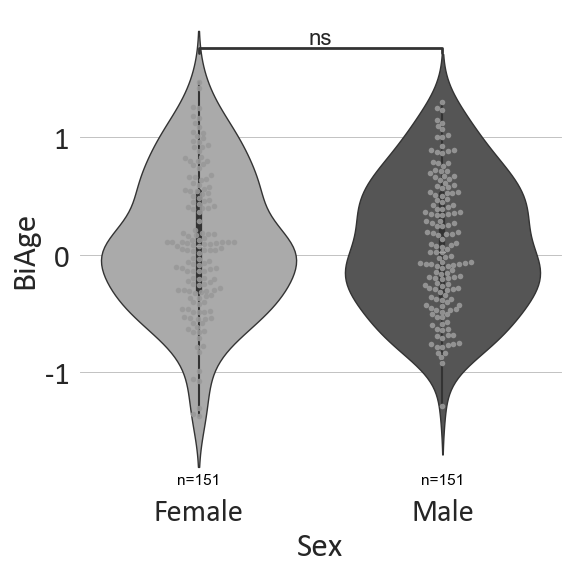

In [35]:
# SUPPLEMENTARY FIGURE S5 B

plt.figure(figsize=(pp_size, pp_size))
boxplot_predicted_quantative_versus_gt_class_subroutine(
    balanced_df=balanced_df[balanced_df.GLOBAL_DIAGNOSIS == "Negative"],
    peak_method="Age score",
    peak_method_ticks=peak_method_ticks,
    ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
    placeholder_dict=placeholder_dict,
    ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
    groups_ordered_values_placeholder=groups_ordered_values_placeholder,
    peak_method_2_label=peak_method_2_label,
    separate_mgs_into_hue=False,
    add_carreturn=False,
    swarmsize=4,
    ax=None)
plt.tight_layout()
plt.show()

Finally, we can match the patients into two groups by age class, to see if older patients are predicted a higher BiAge, without interference from other demographic characteristics/MG status

In [36]:
# PAIR_APPROACH = "RACE_SEX_ETHNICITY_SIMPBATCH_MG_BY_AGECLASS"
ANALYSIS_BY = "AGE_CLASS"
groups_ordered_values = ["<50", ">65"]
PAIR_PARAMETERS = dict(race=True, sex=True, ethnic_group=True, age=False, diag=True, sbatch=True, ebatch=False, only_neg=False)
ANALYSIS_BY_PLACEHOLDER = "Chronological age"
# groups_ordered_values_placeholder = groups_ordered_values
groups_ordered_values_placeholder = [l + " years" for l in groups_ordered_values]
placeholder_dict = {a: b for a, b in zip(groups_ordered_values, groups_ordered_values_placeholder)}

balanced_df = create_balanced_df(full_df=create_full_df(trues_colname=TRUES_COLNAME,
                                                        preds_colname=PREDS_COLNAME,
                                                        safetycheck_colname=SAFETYCHECK_COLNAME),
                                 group_column={"name": ANALYSIS_BY, "values": groups_ordered_values},
                                 pair_columns=quick_create_pair_columns(**PAIR_PARAMETERS))

balanced_df.drop(columns="ANON_ID")

len(balanced_df)=1854


Batch  Simplified_Batch   COHORT2   RACE            ETHNIC_GROUP SEX  \
2026    706                 1    mgb2.0  Black      Hispanic or Latino   F   
170     609                 1    mgb1.0  Black  Not Hispanic or Latino   F   
49      386                 1    mgb1.0  Black  Not Hispanic or Latino   F   
1054    313                 1    mgb1.0  Black  Not Hispanic or Latino   F   
3150    205                 1  PSCR_USA  Black  Not Hispanic or Latino   F   
...     ...               ...       ...    ...                     ...  ..   
4257   1106                 3      PFOL  White  Not Hispanic or Latino   M   
4128   1077                 3      PFOL  White  Not Hispanic or Latino   M   
3858   1027                 3      PSCR  White  Not Hispanic or Latino   M   
4055   1074                 3      PFOL  White  Not Hispanic or Latino   M   
355     894                 3    mgb2.0  White  Not Hispanic or Latino   M   

     GLOBAL_DIAGNOSIS        AGE  MS_peak_conc_1  N_Peaks_above_LLMI  ...  \
2026             MGUS  70.000000           0.248                   2  ...   
170         MGIP-High  71.000000           0.094                   2  ...   
49          MGIP-High  70.000000           0.156                   1  ...   
1054        MGIP-High  66.000000           0.128                   1  ...   
3150        MGIP-High  81.021218           0.118                   4  ...   
...               ...        ...             ...                 ...  ...   
4257             MGUS  43.049315           0.459                   2  ...   
4128             MGUS  49.605479           0.902                   6  ...   
3858             MGUS  39.901639           0.207                   1  ...   
4055             MGUS  48.076712           0.632                   1  ...   
355          Negative  32.000000             NaN                   1  ...   

      COHORT2_Simple        Age  Age score Age score (peaks dropped out)  \
2026            MGB2  70.000000  -0.003376                     -0.031269   
170             MGB1  71.000000   0.768134                      1.266915   
49              MGB1  70.000000   1.245225                      1.522775   
1054            MGB1  66.000000   0.910585                      0.936066   
3150     PROMISE USA  81.021218   1.631879                      1.619827   
...              ...        ...        ...                           ...   
4257     PROMISE USA  43.049315   0.910227                      1.348777   
4128     PROMISE USA  49.605479   1.135056                      0.556865   
3858     PROMISE USA  39.901639   0.654831                      0.769280   
4055     PROMISE USA  48.076712   0.412908                      0.357282   
355             MGB2  32.000000  -0.345793                      0.334832   

          Group  Age_rounded  Age range AGE_CLASS      Self-declared race  \
2026       MGUS         70.0        >65       >65  Black/African American   
170   MGIP-High         71.0        >65       >65  Black/African American   
49    MGIP-High         70.0        >65       >65  Black/African American   
1054  MGIP-High         66.0        >65       >65  Black/African American   
3150  MGIP-High         81.0        >65       >65  Black/African American   
...         ...          ...        ...       ...                     ...   
4257       MGUS         43.0        <50       <50          White/European   
4128       MGUS         50.0        <50       <50          White/European   
3858       MGUS         40.0        <50       <50          White/European   
4055       MGUS         48.0        <50       <50          White/European   
355    Negative         32.0        <50       <50          White/European   

                                      Pair_Label  
2026           Black_1_F_Hispanic or Latino_MGUS  
170   Black_1_F_Not Hispanic or Latino_MGIP-High  
49    Black_1_F_Not Hispanic or Latino_MGIP-High  
1054  Black_1_F_Not Hispanic or Latino_MGIP-High  
3150  Black_1_F_Not Hispanic or Latino_MGIP-High  


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

<50 years vs. >65 years: Mann-Whitney-Wilcoxon test two-sided, P_val:7.869e-13 U_stat=1.797e+03


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


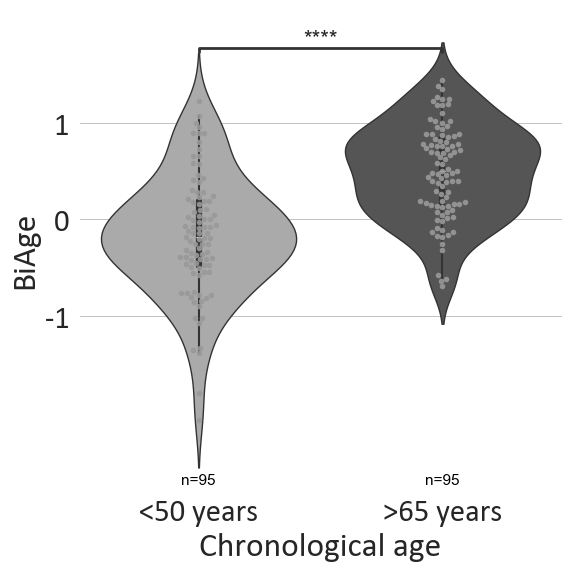

In [37]:
# SUPPLEMENTARY FIGURE S4 A

plt.figure(figsize=(pp_size, pp_size))
boxplot_predicted_quantative_versus_gt_class_subroutine(
    balanced_df=balanced_df[balanced_df.GLOBAL_DIAGNOSIS == "Negative"],
    peak_method="Age score",
    peak_method_ticks=peak_method_ticks,
    ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
    placeholder_dict=placeholder_dict,
    ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
    groups_ordered_values_placeholder=groups_ordered_values_placeholder,
    peak_method_2_label=peak_method_2_label,
    separate_mgs_into_hue=False,
    add_carreturn=False,
    swarmsize=4,
    ax=None)
plt.tight_layout()
plt.show()

And similarly for patients with different MG status (MGIP, MGUS):

C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:226: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#999999'` for the same effect.

  sns.swarmplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MGIP-High_<50 years vs. MGIP-High_>65 years: Mann-Whitney-Wilcoxon test two-sided, P_val:1.937e-26 U_stat=1.334e+04
MGIP-Low_<50 years vs. MGIP-Low_>65 years: Mann-Whitney-Wilcoxon test two-sided, P_val:2.365e-33 U_stat=1.760e+04
MGUS_<50 years vs. MGUS_>65 years: Mann-Whitney-Wilcoxon test two-sided, P_val:1.620e-17 U_stat=2.650e+04


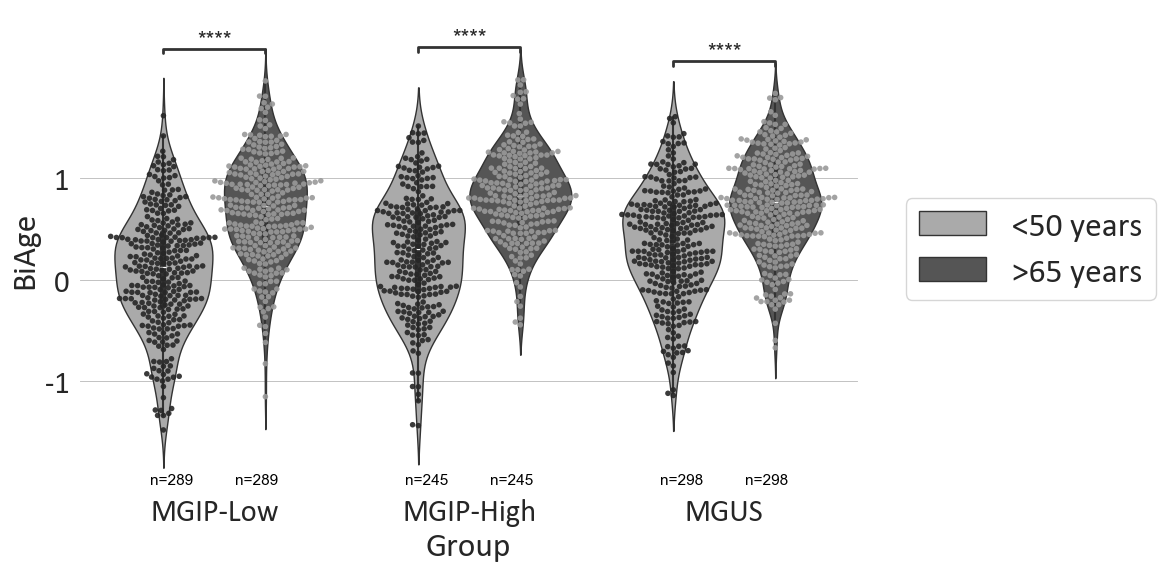

In [38]:
# SUPPLEMENTARY FIGURE S4 B

plt.figure(figsize=(pp_size * 2, pp_size))
boxplot_predicted_quantative_versus_gt_class_subroutine(
    balanced_df=balanced_df[balanced_df.GLOBAL_DIAGNOSIS != "Negative"],
    peak_method="Age score",
    peak_method_ticks=peak_method_ticks,
    ANALYSIS_BY=ANALYSIS_BY, groups_ordered_values=groups_ordered_values,
    placeholder_dict=placeholder_dict,
    ANALYSIS_BY_PLACEHOLDER=ANALYSIS_BY_PLACEHOLDER,
    groups_ordered_values_placeholder=groups_ordered_values_placeholder,
    peak_method_2_label=peak_method_2_label,
    separate_mgs_into_hue=True,
    add_carreturn=False,
    swarmsize=4,
    ax=None)
plt.tight_layout()
plt.show()

# Serial samples and BiAge

Prepare the data with predict BiAge

In [39]:
# keep only promise
promise_serial_dataset = dataset[~dataset.PROMISE_ID.astype(float).isna()].copy()
len(promise_serial_dataset)  # 4728

# reformat promise ID
promise_serial_dataset.PROMISE_ID = promise_serial_dataset.PROMISE_ID.astype(float).astype(int)
# and date
promise_serial_dataset.SAMPLE_DATE = pd.to_datetime(promise_serial_dataset.SAMPLE_DATE, format="%Y-%m-%d")

# keep only patients with 2+ entries, sort them
promise_serial_dataset["n_promise_serial_entries"] = promise_serial_dataset.groupby("PROMISE_ID")["PROMISE_ID"].transform(
    "count")
promise_serial_dataset = promise_serial_dataset[promise_serial_dataset.n_promise_serial_entries > 1].copy()
promise_serial_dataset = promise_serial_dataset.sort_values(["PROMISE_ID", "SAMPLE_DATE"], ascending=[True, True])

len(promise_serial_dataset)  # 1027 entries
# we were initially supposed to have like 1600+; we probably lost a lot when filtering out samples without raw MS data

# let's now create two datasets: one for the first sample and one for the last sample
promise_serial_dataset = promise_serial_dataset.sort_values(["PROMISE_ID", "SAMPLE_DATE"], ascending=[True, True])
prsa_first = promise_serial_dataset[~promise_serial_dataset.PROMISE_ID.duplicated()].copy().reset_index(drop=True)
promise_serial_dataset = promise_serial_dataset.sort_values(["PROMISE_ID", "SAMPLE_DATE"], ascending=[True, False])
prsa_last = promise_serial_dataset[~promise_serial_dataset.PROMISE_ID.duplicated()].copy().reset_index(drop=True)

# now compute the age of patients
assert (prsa_first.PROMISE_ID == prsa_last.PROMISE_ID).all()
prsa_timedelta = (prsa_last.SAMPLE_DATE - prsa_first.SAMPLE_DATE) / datetime.timedelta(days=365.25)

prsa_first = prsa_first[prsa_timedelta > 3].copy()
prsa_last = prsa_last[prsa_timedelta > 3].copy()
prsa_timedelta = prsa_timedelta[prsa_timedelta > 3].copy()

# let's compute the humoral age for our two subsets

prsa_first_preds, dropoutpeaks_prsa_first_preds = supervised_inference(sample_match_ids=prsa_first.ANON_ID.tolist(),
                                                                       sample_annotations=prsa_first["AGE"].values,
                                                                       output_column_loc=OUTPUT_COLUMN_LOC,
                                                                       negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                           target_match_ids=prsa_first.ANON_ID.tolist(),
                                                                           positive_match_ids_to_pair=positive_match_ids,
                                                                           take_original_for_non_negatives_targets=True),
                                                                       unstandardize=UNSTANDARDIZE_PREDICTIONS)

prsa_last_preds, dropoutpeaks_prsa_last_preds = supervised_inference(sample_match_ids=prsa_last.ANON_ID.tolist(),
                                                                     sample_annotations=prsa_last["AGE"].values,
                                                                     output_column_loc=OUTPUT_COLUMN_LOC,
                                                                     negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                         target_match_ids=prsa_last.ANON_ID.tolist(),
                                                                         positive_match_ids_to_pair=positive_match_ids,
                                                                         take_original_for_non_negatives_targets=True),
                                                                     unstandardize=UNSTANDARDIZE_PREDICTIONS)

boxplot_df = pd.concat([pd.Series(np.concatenate([prsa_first_preds, prsa_last_preds]), name="Humoral age"),
                        pd.Series(np.concatenate([prsa_first_preds, prsa_last_preds]), name="Humoral age (peaks dropout)"),
                        pd.Series(np.concatenate([prsa_first.PROMISE_ID, prsa_last.PROMISE_ID]), name="PROMISE_ID"),
                        pd.Series(np.concatenate([prsa_first.GLOBAL_DIAGNOSIS, prsa_last.GLOBAL_DIAGNOSIS]),
                                  name="Ghobrial Lab Diagnosis"),
                        pd.Series([*(["First sample", ] * len(prsa_first_preds)), *(["Last sample", ] * len(prsa_first_preds))],
                                  name="Sample")],
                       axis=1)

# keep only both negatives
((prsa_first.GLOBAL_DIAGNOSIS == "Negative") & (
        prsa_last.GLOBAL_DIAGNOSIS == "Negative")).value_counts()  # 73 True
list_negative_initially = prsa_first[prsa_first.GLOBAL_DIAGNOSIS == "Negative"].PROMISE_ID.tolist()
list_negative_atrescreen = prsa_first[prsa_last.GLOBAL_DIAGNOSIS == "Negative"].PROMISE_ID.tolist()
list_always_negative = np.intersect1d(list_negative_initially, list_negative_atrescreen)

boxplot_df.PROMISE_ID.isin(list_always_negative).value_counts()  # 146
boxplot_df = boxplot_df[boxplot_df.PROMISE_ID.isin(list_always_negative)]

prsa_all_preds, dropoutpeaks_prsa_all_preds = supervised_inference(sample_match_ids=promise_serial_dataset.ANON_ID.tolist(),
                                                                   sample_annotations=promise_serial_dataset["AGE"].values,
                                                                   output_column_loc=OUTPUT_COLUMN_LOC,
                                                                   negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                       target_match_ids=promise_serial_dataset.ANON_ID.tolist(),
                                                                       positive_match_ids_to_pair=positive_match_ids,
                                                                       take_original_for_non_negatives_targets=True),
                                                                   unstandardize=UNSTANDARDIZE_PREDICTIONS)

promise_serial_dataset["Age score"] = prsa_all_preds
promise_serial_dataset["Age score (peaks dropped out)"] = dropoutpeaks_prsa_all_preds

# how many "negative" patients do we have?
promise_serial_dataset.GLOBAL_DIAGNOSIS.value_counts()
# MOST are MGUS, but some are Negative (286)
# Let's select only those:

# plot_data = promise_serial_dataset.iloc[:20].copy()
plot_data = promise_serial_dataset[promise_serial_dataset.GLOBAL_DIAGNOSIS == "Negative"]
promise_ids_with_2plus_samples = plot_data.PROMISE_ID[plot_data.PROMISE_ID.duplicated()]
plot_data = plot_data[plot_data.PROMISE_ID.isin(promise_ids_with_2plus_samples)].copy()

# keep only the paricipants for which at least 2 years between first and last sample
plot_data["Age_delta"] = plot_data.groupby("PROMISE_ID")["AGE"].transform("max") - plot_data.groupby("PROMISE_ID")[
    "AGE"].transform("min")
plot_data = plot_data[plot_data["Age_delta"] > 2]

len(plot_data)  # 158 (2x79)

100%|██████████| 179/179 [00:00<00:00, 938.53it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 11.86it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 23.74it/s] 


100%|██████████| 179/179 [00:00<00:00, 930.09it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 16.65it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 23.56it/s] 


100%|██████████| 1027/1027 [00:01<00:00, 919.58it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 33/33 [00:01<00:00, 22.45it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 33/33 [00:00<00:00, 41.26it/s]


158

We can plot do a scatter plot of BiAge according to chronological age for patients who had multiple serial samples; and connect the dots for serial samples of the same patients

This is **Figure 4B**

100%|██████████| 78/78 [00:00<00:00, 1994.26it/s]


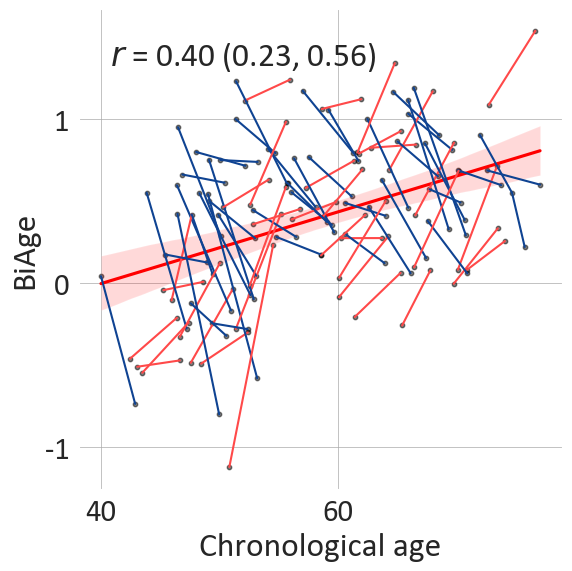

In [40]:
# FIGURE 4 B

plt.figure(figsize=(pp_size * 1, pp_size))
plt.subplot(1, 1, 1)
ax = plot_lm(x=plot_data["AGE"],
             y=plot_data["Age score"],
             group_name="Serial samples",
             text_show_sample_size=False,
             xticks=[40, 60, 80],
             yticks=[-1, .0, 1],
             xlabel="Chronological age",
             ylabel="BiAge",
             scatter_plot_custom_size=10,
             confidence_level=.99)
for promise_id in tqdm(plot_data.PROMISE_ID.unique()):
    # get this patient's data
    patient_subset = plot_data[plot_data.PROMISE_ID == promise_id]
    if len(patient_subset) < 2:
        continue  # only 1 entry for this patient
    # get c-Age and h-Age
    cages = patient_subset["AGE"].values
    hages = patient_subset["Age score"].values
    # order both by c-Age (ascending)
    ageso = np.argsort(cages)
    cages, hages = cages[ageso], hages[ageso]
    # draw a line for each of those
    # sns.lineplot(x=cages, y=hages, hue=None, legend=False, ax=ax)
    for prev_cage, prev_hage, cur_cage, cur_hage in zip(cages[:-1], hages[:-1], cages[1:], hages[1:]):
        plot_color = "#ff4949" if cur_hage > prev_hage else "#0f4392"
        plt.plot([prev_cage, cur_cage, ],
                 [prev_hage, cur_hage, ],
                 c=plot_color)
plt.tight_layout()
plt.show()

We can also compute the "average BiAge" according to average chronological age, by averaging between BiAge computed from all serial samples, per patient

This is **Figure 4C**

  0%|          | 0/78 [00:00<?, ?it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2762217492.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  patient_subset = avg_plot_data[plot_data.PROMISE_ID == promise_id]
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2762217492.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  patient_subset = avg_plot_data[plot_data.PROMISE_ID == promise_id]
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2762217492.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  patient_subset = avg_plot_data[plot_data.PROMISE_ID == promise_id]
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2762217492.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  patient_subset = avg_plot_data[plot_data.PROMISE_ID == promise_id]
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2762217492.py:37: UserWarning: Boolean Series key will be re

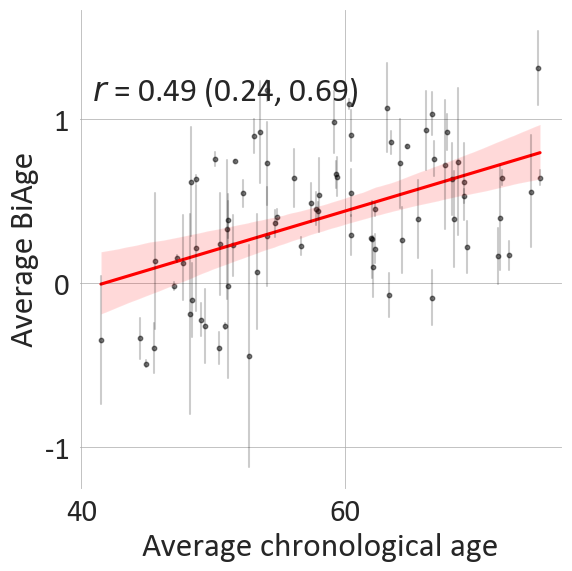

In [41]:
# FIGURE 4 C

avg_plot_data = plot_data.copy()
# make sure it is sorted
avg_plot_data = avg_plot_data.sort_values(["PROMISE_ID", "AGE"])
# get some stats
avg_plot_data["Average age"] = avg_plot_data.groupby("PROMISE_ID")["AGE"].transform("mean")
avg_plot_data["Min Age"] = avg_plot_data.groupby("PROMISE_ID")["AGE"].transform("min")
avg_plot_data["Max Age"] = avg_plot_data.groupby("PROMISE_ID")["AGE"].transform("max")
avg_plot_data["Age delta"] = (avg_plot_data.groupby("PROMISE_ID")["AGE"].transform("last") -
                              avg_plot_data.groupby("PROMISE_ID")["AGE"].transform("first"))
# limit_to_bm_and_pb_the_same_day for humoral age
avg_plot_data["Average Age score"] = avg_plot_data.groupby("PROMISE_ID")["Age score"].transform("mean")
avg_plot_data["Min Age score"] = avg_plot_data.groupby("PROMISE_ID")["Age score"].transform("min")
avg_plot_data["Max Age score"] = avg_plot_data.groupby("PROMISE_ID")["Age score"].transform("max")
avg_plot_data["Age score delta"] = (avg_plot_data.groupby("PROMISE_ID")["Age score"].transform("last") -
                                    avg_plot_data.groupby("PROMISE_ID")["Age score"].transform("first"))
# just keep 1 entry per patient for plotting
avg_plot_data = avg_plot_data[~avg_plot_data.PROMISE_ID.duplicated()]
# keep only if enough time between 2 samples
avg_plot_data = avg_plot_data[avg_plot_data["Age delta"] > 2]

plt.figure(figsize=(pp_size * 1, pp_size))
plt.subplot(1, 1, 1)
ax = plot_lm(x=avg_plot_data["Average age"],
             y=avg_plot_data["Average Age score"],
             group_name="Serial samples",
             text_show_sample_size=False,
             xticks=[40, 60, 80],
             yticks=[-1, .0, 1],
             xlabel="Average chronological age",
             ylabel="Average BiAge",
             scatter_plot_custom_size=10,
             confidence_level=.99)
for promise_id in tqdm(avg_plot_data.PROMISE_ID.unique()):
    # get this patient's data
    patient_subset = avg_plot_data[plot_data.PROMISE_ID == promise_id]
    # get c-Age and h-Age
    average_cage = patient_subset["Average age"].values[0]
    # average_hage = patient_subset["Average Age score"].values[0]
    min_hage = patient_subset["Min Age score"].values[0]
    max_hage = patient_subset["Max Age score"].values[0]
    # draw a line for each of those
    # sns.lineplot(x=cages, y=hages, hue=None, legend=False, ax=ax)
    plt.plot([average_cage, average_cage, ],
             [min_hage, max_hage, ],
             c="#000000", alpha=.2)
plt.tight_layout()
plt.show()

Finally, we can plot the average BiAge variation between two samples, normalized by the delay (years) between those two samples

This is **Figure 4A**

C:\Users\flori\AppData\Local\Temp\ipykernel_16944\506202490.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=ticks_font_params)


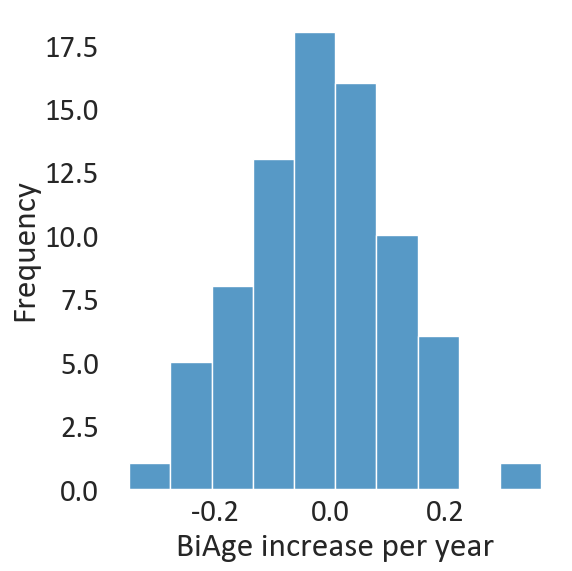

In [42]:
# FIGURE 4 A

# normalizing by c-age difference
plt.figure(figsize=(pp_size, pp_size))
ax = sns.histplot(avg_plot_data["Age score delta"] / avg_plot_data["Age delta"])
plt.ylabel("Frequency", **labels_font_params)
plt.xlabel("BiAge increase per year", **labels_font_params)
# ax.set_xticklabels(np.round(ax.get_xticks(), 1), fontdict=ticks_font_params)
plt.xticks(np.array([-.2, .0, .2]))
ax.set_xticklabels(ax.get_xticks(), fontdict=ticks_font_params)
ax.set_yticklabels(ax.get_yticks(), fontdict=ticks_font_params)
plt.tight_layout()
plt.show()

We can also compute some statistics concerning BiAge variation for serial samples

In [43]:
# some stats (useful?)

print("Average BiAge delta")
print(avg_plot_data["Age score delta"].mean())

print("BiAge delta median and quartiles")
print(avg_plot_data["Age score delta"].quantile([.5, .25, .75]))

print("Average BiAge delta/year")
print((avg_plot_data["Age score delta"] / avg_plot_data["Age delta"]).mean())

print("BiAge delta/year median and quartiles")
print((avg_plot_data["Age score delta"] / avg_plot_data["Age delta"]).quantile([.5, .25, .75]))

print("Percentage of patients with positive BiAge delta")
print(((avg_plot_data["Age score delta"] / avg_plot_data["Age delta"]) > 0).sum())
print("Percentage of patients with negative BiAge delta")
print(((avg_plot_data["Age score delta"] / avg_plot_data["Age delta"]) < 0).sum())

print("Average BiAge delta/year")
print(stats.bootstrap(((avg_plot_data["Age score delta"] / avg_plot_data["Age delta"]).values,), np.mean, n_resamples=9999, confidence_level=.99,
                random_state=1))

print("Average chronological age delta")
print(avg_plot_data["Age delta"].mean())  # 3.6 chronological years avg
print("Chronological age delta median and quartiles")
print(avg_plot_data["Age delta"].quantile([.5, .25, .75]))  # 3.6 years median [3.4-3.8 years]


Average BiAge delta
-0.06926368
BiAge delta median and quartiles
0.50   -0.064052
0.25   -0.346700
0.75    0.249289
Name: Age score delta, dtype: float64
Average BiAge delta/year
-0.017615015664210823
BiAge delta/year median and quartiles
0.50   -0.016758
0.25   -0.094279
0.75    0.065534
dtype: float64
Percentage of patients with positive BiAge delta
35
Percentage of patients with negative BiAge delta
43
Average BiAge delta/year
BootstrapResult(confidence_interval=ConfidenceInterval(low=np.float64(-0.05493380557149905), high=np.float64(0.020046209659590926)), bootstrap_distribution=array([-0.02128531, -0.01066135, -0.02341377, ..., -0.02232192,
       -0.05018048, -0.01216879]), standard_error=np.float64(0.014385748463380896))
Average chronological age delta
3.5933851109451713
Chronological age delta median and quartiles
0.50    3.594884
0.25    3.354416
0.75    3.845847
Name: Age delta, dtype: float64


# Autoimmune disease

Compare BiAge of patients with/without autoimmune diseases

Since we want to test multiple settings (All AIDs, Ab+ AIDs, AB- AIDs, on negative samples, in all samples, in MG-positive samples, etc.) we will design a function that we can call and that will perform the dataset creation and then the analysis

In [44]:
def print_mgb_figure(MGB_ANNOT_DATASET, MGB_PAIR_BY=["AGE_RACE_ETHNICITY_SEX_SIMPBATCH", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_MG", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_HEALTHYONLY"][0]):
    mgb_annotations_path = None
    GROUP_TYPE = None
    posneg_names = None
    # define the parameters of the analysis depending on whether we want to analyze all AIDs, Ab+ or Ab-
    if MGB_ANNOT_DATASET == "AID":
        mgb_annotations_path = r"C:\Users\flori\Dropbox (Partners HealthCare)\Floris\SPECTR-MS\data\MGB\datasets\aid_mgb_dict_v2oct2.h5"
        GROUP_TYPE = "Autoimmune disease"
        posneg_names = {"positive": "AID", "negative": "No AID"}
    if MGB_ANNOT_DATASET == "AID-Ab+":
        mgb_annotations_path = r"C:\Users\flori\Dropbox (Partners HealthCare)\Floris\SPECTR-MS\data\MGB\datasets\aid_mgb_dict_v2oct2.h5"
        GROUP_TYPE = "Ab+ autoimmune disease"
        posneg_names = {"positive": "Ab+ AID", "negative": "No Ab+ AID"}
    if MGB_ANNOT_DATASET == "AID-Ab-":
        mgb_annotations_path = r"C:\Users\flori\Dropbox (Partners HealthCare)\Floris\SPECTR-MS\data\MGB\datasets\aid_mgb_dict_v2oct2.h5"
        GROUP_TYPE = "Ab- autoimmune disease"
        posneg_names = {"positive": "Ab- AID", "negative": "No Ab- AID"}

    # now, let's match this "full_df" with our actual romano's diversity data
    mgb_dict = pd.DataFrame(pd.read_hdf(mgb_annotations_path))
    print("Size of the dictionary")
    print(len(mgb_dict))
    assert not mgb_dict.MERGE_Match_ID.duplicated().any()  # 0 => no duplicates

    # some stats!
    do_stats = True
    if do_stats and (MGB_ANNOT_DATASET == "AID"):
        positive_table = mgb_dict[[disease_column for disease_column in mgb_dict.columns.tolist() if disease_column[-8:] == "positive"]]
        positive_stats = positive_table.sum(axis=0)
        positive_stats = positive_stats.reset_index(drop=False).rename(columns={"index": "Disease", 0: "Positive"})
        positive_stats.Disease = positive_stats.Disease.str[:-8]
        negative_table = mgb_dict[[disease_column for disease_column in mgb_dict.columns.tolist() if disease_column[-8:] == "negative"]]
        negative_stats = negative_table.sum(axis=0)
        negative_stats = negative_stats.reset_index(drop=False).rename(columns={"index": "Disease", 0: "Negative"})
        negative_stats.Disease = negative_stats.Disease.str[:-8]
        all_stats = positive_stats.merge(negative_stats, on="Disease", how="outer")
        all_stats = all_stats.sort_values("Positive", ascending=False)
        print(all_stats)

    # now merge MS data + ICD annotations
    mgb_dataset = dataset.merge(mgb_dict, left_on="ANON_ID", right_on="MERGE_Match_ID", how="inner")

    mgb_dataset["Group"] = "Excluded"
    mgb_dataset.loc[mgb_dataset[f"{GROUP_TYPE} positive"], "Group"] = posneg_names["positive"]
    mgb_dataset.loc[mgb_dataset[f"{GROUP_TYPE} negative"], "Group"] = posneg_names["negative"]
    # filter out excluded
    mgb_dataset = mgb_dataset[mgb_dataset.Group.isin([posneg_names["positive"], posneg_names["negative"]])].copy()

    mgb_dataset["Age_rounded"] = mgb_dataset["AGE"].round()

    if MGB_PAIR_BY == "AGE_RACE_ETHNICITY_SEX_SIMPBATCH":
        aid_figures_prefix = "base_group"
        mgba_data = create_balanced_df(full_df=mgb_dataset,
                                       group_column={"name": "Group",
                                                     "values": [posneg_names["positive"], posneg_names["negative"]]},
                                       pair_columns=quick_create_pair_columns(race=True, sex=True, ethnic_group=True, age=True,
                                                                              diag=False, sbatch=True, ebatch=False,
                                                                              only_neg=False))
    elif MGB_PAIR_BY == "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_MG":
        aid_figures_prefix = "base_mg_group"
        mgba_data = create_balanced_df(full_df=mgb_dataset,
                                       group_column={"name": "Group",
                                                     "values": [posneg_names["positive"], posneg_names["negative"]]},
                                       pair_columns=quick_create_pair_columns(race=True, sex=True, ethnic_group=True, age=True,
                                                                              diag=True, sbatch=True, ebatch=False, only_neg=False))
    elif MGB_PAIR_BY == "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_HEALTHYONLY":
        aid_figures_prefix = "base_group_healthyonly"
        mgba_data = create_balanced_df(full_df=mgb_dataset,
                                       group_column={"name": "Group",
                                                     "values": [posneg_names["positive"], posneg_names["negative"]]},
                                       pair_columns=quick_create_pair_columns(race=True, sex=True, ethnic_group=True, age=True,
                                                                              diag=True, sbatch=True, ebatch=False, only_neg=True))

    mgb_preds, dropoutpeaks_mgb_preds = supervised_inference(sample_match_ids=mgba_data.ANON_ID.tolist(),
                                                             sample_annotations=mgba_data["AGE"].values,
                                                             output_column_loc=OUTPUT_COLUMN_LOC,
                                                             negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                 target_match_ids=mgba_data.ANON_ID.tolist(),
                                                                 positive_match_ids_to_pair=positive_match_ids,
                                                                 take_original_for_non_negatives_targets=True),
                                                             unstandardize=UNSTANDARDIZE_PREDICTIONS)

    mgba_data["Chronological age"] = mgba_data["AGE"].values
    mgba_data["Age score"] = mgb_preds
    mgba_data["Age score (peaks dropped out)"] = dropoutpeaks_mgb_preds
    # new: also add immune vs chronological age delta
    mgba_data["Expected chronological age"] = mgba_data["Age score"] * y_intraining_std[0][0] + y_intraining_mean[0][0]
    mgba_data["Expected-real chronological age"] = mgba_data["Expected chronological age"] - mgba_data["Chronological age"]
    mgba_data["Expected over real chronological age"] = mgba_data["Expected chronological age"] / mgba_data["Chronological age"]

    # do a small summary of the dataset
    mgba_data = add_pre_df_columns(pre_df=mgba_data)

    palette_dict = {posneg_names["positive"]: "#cccccc", posneg_names["negative"]: "#444444"}
    points_palette_dict = {posneg_names["positive"]: "#000000", posneg_names["negative"]: "#000000"}

    # pending question: is it only due to the prevalence of MG?
    # answer => also group by MG status! (done, successful)
    # other answer => only take negative patients (also done)

    # NEW
    peak_method = "Age score"
    # peak_method = "Age score (peaks dropped out)"

    boxplot_data = mgba_data.copy()
    # reorder
    boxplot_data["Group"] = boxplot_data["Group"].astype("category").cat.set_categories([posneg_names["negative"],
                                                                                         posneg_names["positive"]])

    boxplot_kwargs = {"data": boxplot_data, "x": "Group", "y": peak_method}
    box_pairs = [
        (posneg_names["negative"], posneg_names["positive"],),
    ]
    plt.figure(figsize=(pp_size, pp_size))
    # ax = sns.boxplot(**boxplot_kwargs)
    ax = plot_box(**boxplot_kwargs,
                  yticks=trues_ticks if peak_method == "Chronological age" else [-20, 0,
                                                                                 20] if peak_method == "Expected-real chronological age" else [
                      0, 1, 2] if peak_method == "Expected over real chronological age" else [-2, -1, 0, 1, 2],
                  xlabel="Clinical annotation",
                  hue=None,
                  ylabel=peak_method_2_label[peak_method] if peak_method in peak_method_2_label.keys() else peak_method,
                  palette=palette_dict,
                  legend_off=True,
                  legend_loc="outside",
                  # subtype="precise_violinplot",
                  subtype="precise_violinplot+swarmplot",
                  swarmsize=3,
                  )
    # stars
    if statannotations_available:
        annotator2 = Annotator(ax, box_pairs, **boxplot_kwargs)
        annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside',
                             line_width=2.0, line_height=.01, text_offset=0)
        annotator2.apply_and_annotate()
    plt.tight_layout()
    plt.show()

First, we can analyze BiAge of patients affected by any autoimmune disease vs. not affected by any immune disease, matched 1:1 by age, race, ethnicity and sex

Size of the dictionary
7979
                                         Disease  Positive  Negative
5                            Autoimmune disease       1981      5192
0                        Ab+ autoimmune disease       1519      5779
1                        Ab- autoimmune disease        706      6853
39                         Rheumatoid arthritis        457      7336
12                     Diabetes mellitus type 1        241      7600
42           Systemic lupus erythematosus (SLE)        198      7726
35                                    Psoriasis        185      7672
10             Chronic rheumatic heart diseases        177      7514
19                      Hashimoto's thyroiditis        135      7759
3                        Ankylosing spondylitis        121      7699
11                              Crohn´s disease        120      7807
25              Mixed connective tissue disease        114      7780
17                              Graves’ disease        113      7833
40    

100%|██████████| 2456/2456 [00:02<00:00, 911.66it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 77/77 [00:04<00:00, 17.13it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 77/77 [00:02<00:00, 38.24it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No AID vs. AID: Mann-Whitney-Wilcoxon test two-sided, P_val:5.287e-08 U_stat=6.584e+05


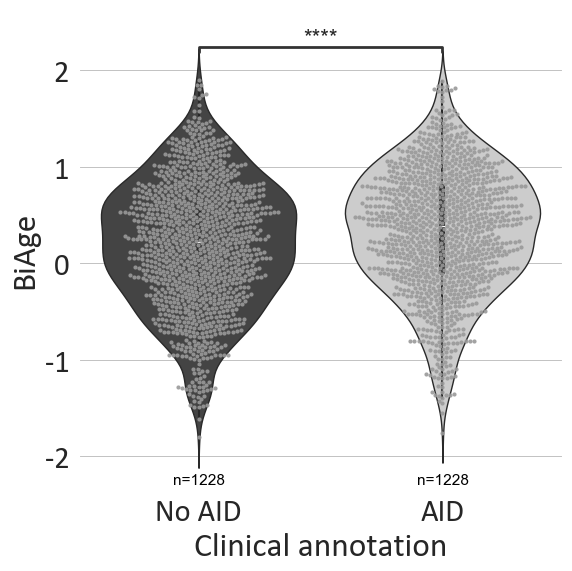

In [45]:
print_mgb_figure("AID", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH")

Next, same analysis but we will also match by monoclonal gammopathy to see if patients with the same MG status are predicted a different BiAge

Size of the dictionary
7979
                                         Disease  Positive  Negative
5                            Autoimmune disease       1981      5192
0                        Ab+ autoimmune disease       1519      5779
1                        Ab- autoimmune disease        706      6853
39                         Rheumatoid arthritis        457      7336
12                     Diabetes mellitus type 1        241      7600
42           Systemic lupus erythematosus (SLE)        198      7726
35                                    Psoriasis        185      7672
10             Chronic rheumatic heart diseases        177      7514
19                      Hashimoto's thyroiditis        135      7759
3                        Ankylosing spondylitis        121      7699
11                              Crohn´s disease        120      7807
25              Mixed connective tissue disease        114      7780
17                              Graves’ disease        113      7833
40    

100%|██████████| 2114/2114 [00:02<00:00, 911.15it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 67/67 [00:02<00:00, 32.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 67/67 [00:01<00:00, 38.80it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No AID vs. AID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.540e-04 U_stat=5.055e+05


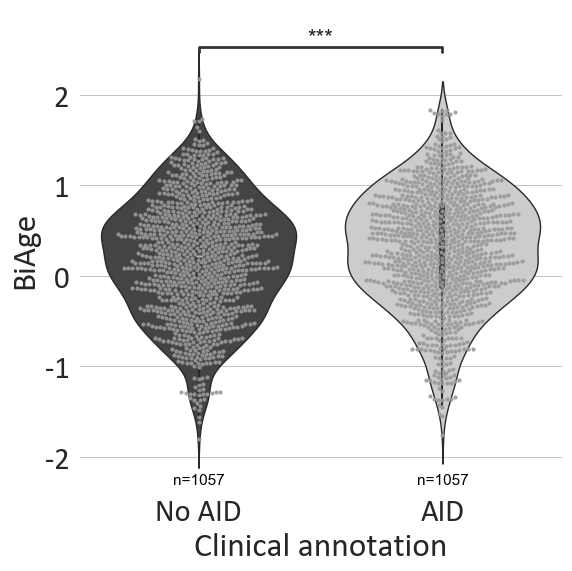

In [46]:
print_mgb_figure("AID", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_MG")

Finally, we can compare the BiAge of patients affected vs. not affected by AID when comparing only negative samples, i.e. patients without monoclonal gammopathy

Size of the dictionary
7979
                                         Disease  Positive  Negative
5                            Autoimmune disease       1981      5192
0                        Ab+ autoimmune disease       1519      5779
1                        Ab- autoimmune disease        706      6853
39                         Rheumatoid arthritis        457      7336
12                     Diabetes mellitus type 1        241      7600
42           Systemic lupus erythematosus (SLE)        198      7726
35                                    Psoriasis        185      7672
10             Chronic rheumatic heart diseases        177      7514
19                      Hashimoto's thyroiditis        135      7759
3                        Ankylosing spondylitis        121      7699
11                              Crohn´s disease        120      7807
25              Mixed connective tissue disease        114      7780
17                              Graves’ disease        113      7833
40    

100%|██████████| 1486/1486 [00:01<00:00, 888.32it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 47/47 [00:01<00:00, 28.04it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 47/47 [00:01<00:00, 39.47it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No AID vs. AID: Mann-Whitney-Wilcoxon test two-sided, P_val:5.740e-04 U_stat=2.475e+05


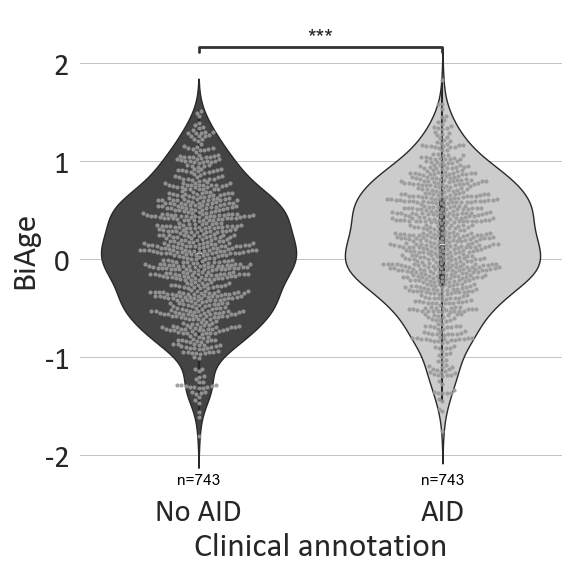

In [47]:
print_mgb_figure("AID", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_HEALTHYONLY")

We will repeat the same analyses after limiting to antibody-positive autoimmune-diseases; first, by matching 1:1 only according to age, race, ethnicity and sex

Size of the dictionary
7979
len(balanced_df)=1882


100%|██████████| 1882/1882 [00:02<00:00, 900.24it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 59/59 [00:01<00:00, 33.69it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 59/59 [00:01<00:00, 39.48it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No Ab+ AID vs. Ab+ AID: Mann-Whitney-Wilcoxon test two-sided, P_val:2.137e-06 U_stat=3.869e+05


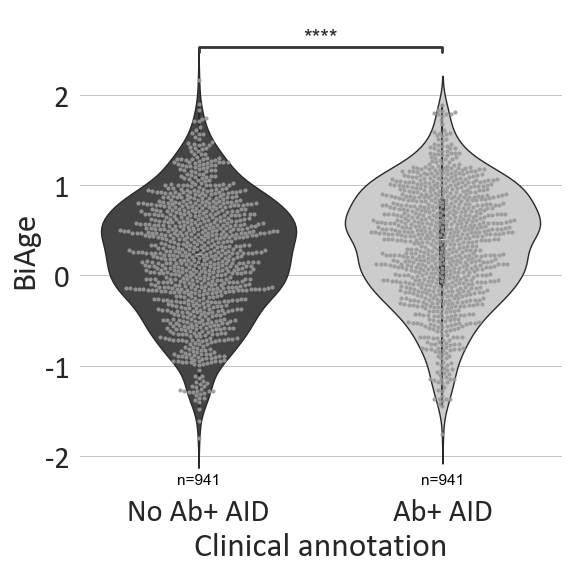

In [48]:
print_mgb_figure("AID-Ab+", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH")

Then after matching also by MG status

Size of the dictionary
7979
len(balanced_df)=1642


100%|██████████| 1642/1642 [00:01<00:00, 895.35it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 52/52 [00:01<00:00, 37.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 52/52 [00:01<00:00, 40.09it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No Ab+ AID vs. Ab+ AID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.092e-03 U_stat=3.056e+05


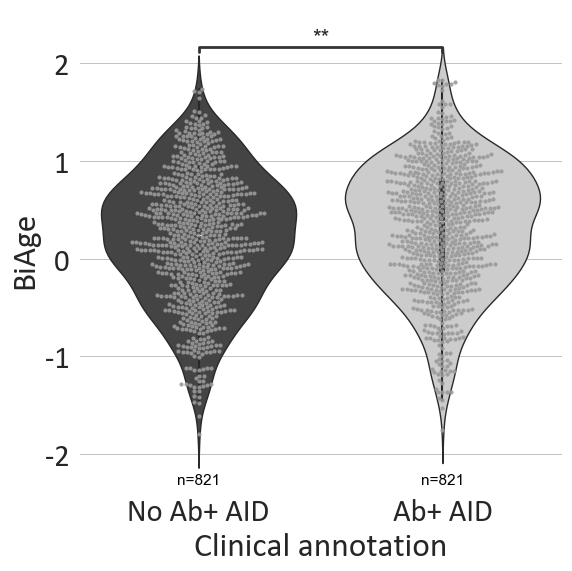

In [49]:
print_mgb_figure("AID-Ab+", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_MG")

And finally when comparing only negative samples

Size of the dictionary
7979
len(balanced_df)=1130


100%|██████████| 1130/1130 [00:01<00:00, 915.08it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 36/36 [00:01<00:00, 27.28it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 41.41it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No Ab+ AID vs. Ab+ AID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.311e-02 U_stat=1.460e+05


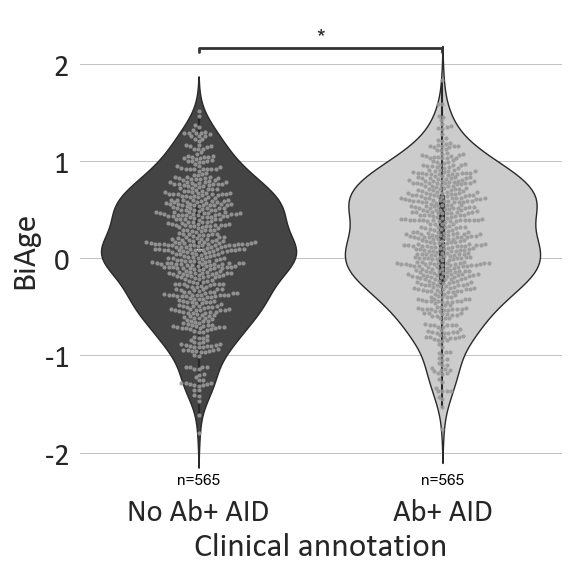

In [50]:
print_mgb_figure("AID-Ab+", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_HEALTHYONLY")

Last, we can compare Ab- AID patients vs. no disease, without taking into account MG status first:

Size of the dictionary
7979
len(balanced_df)=934


100%|██████████| 934/934 [00:01<00:00, 904.94it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 30/30 [00:01<00:00, 23.12it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 30/30 [00:00<00:00, 42.17it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No Ab- AID vs. Ab- AID: Mann-Whitney-Wilcoxon test two-sided, P_val:8.078e-03 U_stat=9.812e+04


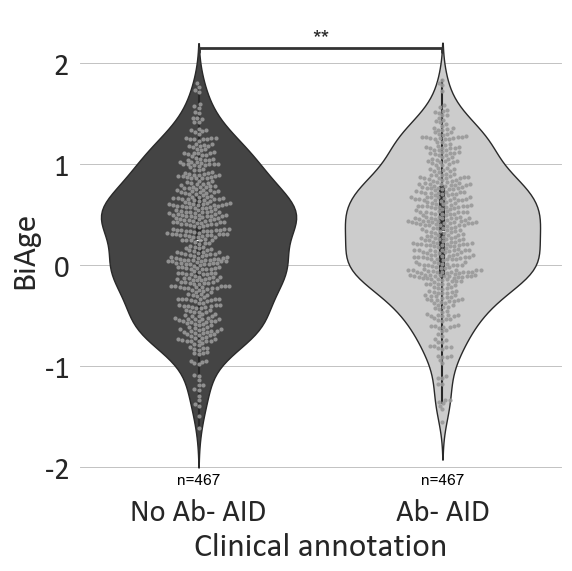

In [51]:
print_mgb_figure("AID-Ab-", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH")

When taking MG status into account during matching 1:1

Size of the dictionary
7979
len(balanced_df)=822


100%|██████████| 822/822 [00:00<00:00, 887.11it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 26/26 [00:01<00:00, 23.44it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 39.67it/s]


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No Ab- AID vs. Ab- AID: Mann-Whitney-Wilcoxon test two-sided, P_val:1.773e-01 U_stat=7.987e+04


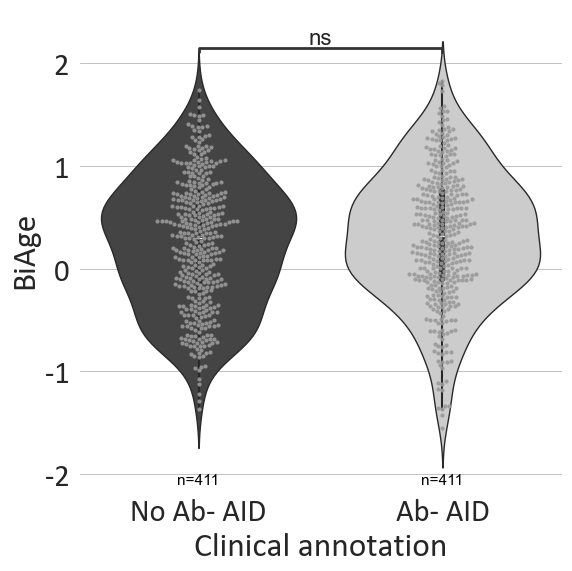

In [52]:
print_mgb_figure("AID-Ab-", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_MG")

And when considering only negative samples:

Size of the dictionary
7979
len(balanced_df)=560


100%|██████████| 560/560 [00:00<00:00, 816.86it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 22.18it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 33.88it/s]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No Ab- AID vs. Ab- AID: Mann-Whitney-Wilcoxon test two-sided, P_val:9.142e-02 U_stat=3.597e+04


C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=data, x=x, y=y, hue=hue,
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\3410833817.py:274: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)


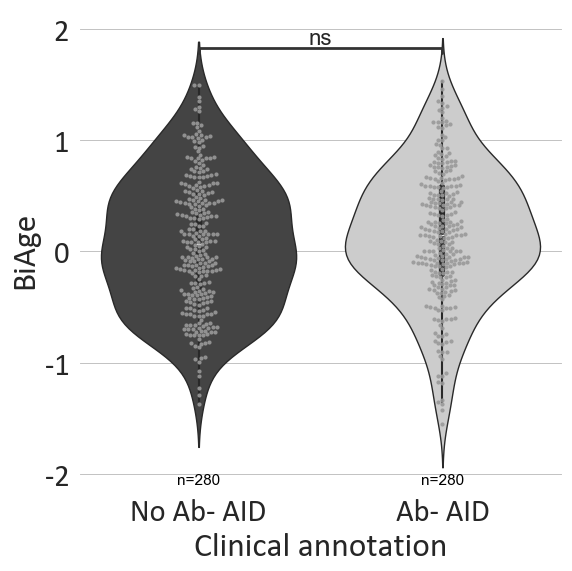

In [53]:
print_mgb_figure("AID-Ab-", "AGE_RACE_ETHNICITY_SEX_SIMPBATCH_HEALTHYONLY")

# Plasma cell single-cell BCR diversity

First we will load our scBCR annotations and match with the MS data

In [54]:
# SCBCR_MATCH_FILE = None
SCBCR_MATCH_FILE = r"C:\Users\flori\Dropbox (Partners HealthCare)\Floris\SPECTR-MS\data\Romanos\romanos_ms_dataset_merge_v1_August_12_2024\romliz_merge_table_v1.xlsx"

# now, let's match this "full_df" with our actual romano's diversity data
repertoire_diversity_filename = r"C:\Users\flori\Dropbox (Partners HealthCare)\Floris\SPECTR-MS\data\Romanos\romanos_results_repeated\Diversity_Means.csv"

repertoire_diversity_data = pd.read_csv(repertoire_diversity_filename)

# load our match file
romanos_match = pd.read_excel(SCBCR_MATCH_FILE)

# merge
len(repertoire_diversity_data)  # 131 without TC, 176 with
len(romanos_match)  # 153
diversity_data = repertoire_diversity_data.merge(romanos_match[["seq_group.1",
                                                                'seq_bm_date', 'seq_bm_sex', 'seq_bm_race', 'seq_bm_age',
                                                                'ms_race', 'ms_sex', 'ms_age', 'ms_date',
                                                                'bm_pb_timedelta_years',
                                                                'manual_check',
                                                                "ms_match_id"]], left_on="Group.1", right_on="seq_group.1", how="inner")
assert len(repertoire_diversity_data) == len(diversity_data)  # 153
# now filter out patients without ms match id available
diversity_data = diversity_data[~diversity_data.ms_match_id.isna()]
len(diversity_data)  # 95 patients, 106 with TC

# Note: we cannot match this directly with our MS "dataset"
# because some had missing age/race/sex and were removed from the dataset
# so we have to instead reload the untouched dataset and merge it with them
scbcrwork_dataset = dataset_backup.copy()
# re-apply QCs
scbcrwork_dataset = scbcrwork_dataset.loc[scbcrwork_dataset.QC_MSRAW_Data_Available, :]
scbcrwork_dataset = scbcrwork_dataset.loc[~scbcrwork_dataset.QC_MS_Noise_Filter_Triggered, :]
# if config.drop_samples_with_inconsistent_mz_start:
#     scbcrwork_dataset = scbcrwork_dataset.loc[~scbcrwork_dataset.QC_MS_Inconsistent_mz_Start, :]
scbcrwork_dataset["MS_peak_conc_Total"] = scbcrwork_dataset[[f"MS_peak_conc_{j}" for j in range(1, 15)]].sum(axis=1)
diversity_data_clinical = diversity_data.merge(scbcrwork_dataset[["ANON_ID", "AGE", "SEX", "RACE",
                                                                  "MS_peak_conc_Total", "FLCRATIO"]],
                                               left_on="ms_match_id", right_on="ANON_ID", how="inner")
len(diversity_data_clinical)  # 91

# let's now eliminate samples with BM/PB too far away
# basically that menas keeping only "manual_check" == "OK" in our romanos match list
diversity_data_clinical = diversity_data_clinical[diversity_data_clinical.manual_check == "OK"].copy()
len(diversity_data_clinical)  # 86

# for race and sex, we will take romanos' annotations because it was like double checked by him
# for age, we will take also romanos' age (at bm)
# but to take into account we have age at pb instead, we will add the delay between pb and bm to the age at bm
diversity_data_clinical["final_race"] = diversity_data_clinical.seq_bm_race
diversity_data_clinical["final_sex"] = diversity_data_clinical.seq_bm_sex
diversity_data_clinical["final_age"] = diversity_data_clinical.seq_bm_age + diversity_data_clinical.bm_pb_timedelta_years

chao_metric = "Chao"

# create our final dataset
scbcr_finaldata = diversity_data_clinical[['Group.1', 'Richness', 'Shannon', chao_metric, 'Dx',
                                             'ANON_ID', 'MS_peak_conc_Total', "FLCRATIO", "bm_pb_timedelta_years",
                                             'final_race', 'final_sex', 'final_age']].rename(columns={chao_metric: 'Chao',
                                                                                                      'final_race': "Race",
                                                                                                      'final_sex': "Sex",
                                                                                                      'final_age': "Age",
                                                                                                      'MS_peak_conc_Total': "MProtein",
                                                                                                      "FLCRATIO": "FLCRatio"})

scbcr_match_ids = scbcr_finaldata.ANON_ID.tolist()

diversity_preds, dropoutpeaks_diversity_preds = supervised_inference(sample_match_ids=scbcr_match_ids,
                                                                     sample_annotations=scbcr_finaldata.Age.values,
                                                                     output_column_loc=OUTPUT_COLUMN_LOC,
                                                                     negative_dropout_preprocess_data=find_paired_dropout_data(
                                                                         target_match_ids=scbcr_match_ids,
                                                                         positive_match_ids_to_pair=positive_match_ids,
                                                                         take_original_for_non_negatives_targets=True),
                                                                     unstandardize=UNSTANDARDIZE_PREDICTIONS)

scbcr_finaldata["Age score"] = diversity_preds
scbcr_finaldata["Age score (peaks dropped out)"] = dropoutpeaks_diversity_preds
scbcr_finaldata["logFLCRatio"] = np.log10(scbcr_finaldata["FLCRatio"])

scbcr_finaldata["Diagnosis"] = scbcr_finaldata.Dx.map({"Untreated_SMM": "SMM",
                                                           "MGUS": "MGUS",
                                                           "HD": "Healthy",
                                                           "NDMM": "NDMM"})

scbcr_finaldata.Diagnosis.value_counts()

# before going into the analyses, let's check the timedelta between pb and bm
# scbcr_finaldata["Diagnosis"] = scbcr_finaldata["Diagnosis"].astype("category").cat.set_categories(["MGUS", "SMM", "NDMM"])

(365.25 * scbcr_finaldata.bm_pb_timedelta_years).quantile([.25, .5, .75])  # 0, 0, 0 days
(365.25 * scbcr_finaldata.bm_pb_timedelta_years).abs().mean()  # 13 days
(365.25 * scbcr_finaldata.bm_pb_timedelta_years).abs().max()  # 132 days

# adapt if including tumor cells
chao_ticks = [0, 1000, 2000, 3000, 4000]
div_metric = "Chao"

metric_name = "Chao1 index"
confidence_level = .99

100%|██████████| 86/86 [00:00<00:00, 893.68it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 30.93it/s] 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 55.61it/s] 


Then we can plot BiAge according to BM plasma cell BCR diversity

This is **Figure 3B**

C:\Users\flori\AppData\Local\Temp\ipykernel_16944\4290987724.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)


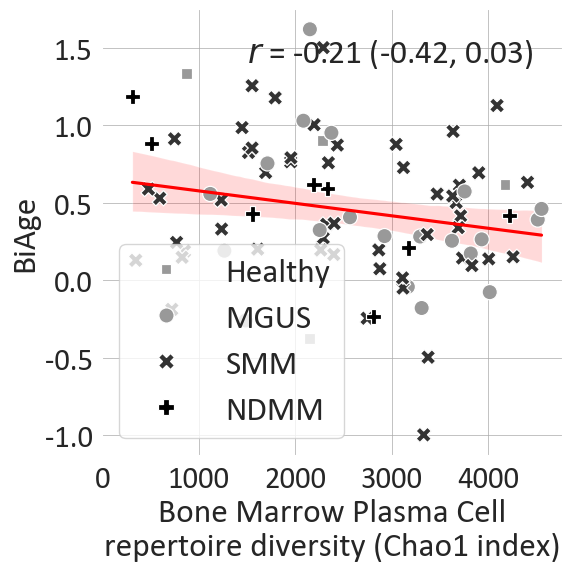

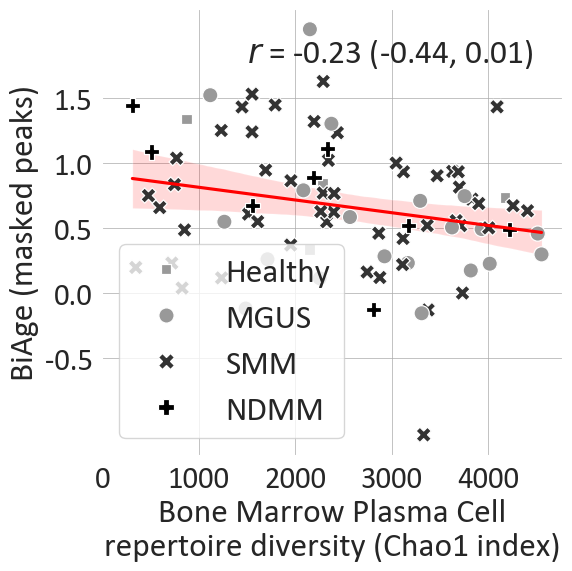

In [55]:
# FIGURE 3 B

c_yticks = [0, 25, 50, 75, 100] if div_metric == "Richness" else chao_ticks
for j, peak_method in enumerate(["Age score", "Age score (peaks dropped out)"]):  # , "Age score (peaks dropped out)"
    palette_dict = {"Healthy": "#999999", "MGUS": "#999999", "SMM": "#333333", "NDMM": "#000000"}

    plt.figure(figsize=(pp_size, pp_size))
    x, y = scbcr_finaldata[div_metric], scbcr_finaldata[peak_method]
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    xymin, xymax = min(x.min(), y.min()), max(x.max(), y.max())
    xyrange = xymax - xymin
    xrange, yrange = xmax - xmin, ymax - ymin
    r, p = scipy.stats.pearsonr(x=x, y=y)
    if confidence_level is not None:
        assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
        bts_results = stats.bootstrap((x, y), scipy.stats.pearsonr, paired=True, n_resamples=9999,
                                      confidence_level=confidence_level, random_state=1)
        r_lo = bts_results.confidence_interval[0][0]
        r_hi = bts_results.confidence_interval[1][0]
    else:
        r_lo, r_hi = None, None
    # plot points and line
    ax = sns.regplot(x=x, y=y, scatter_kws={"color": "black", "alpha": 0.0}, line_kws={"color": "red"})
    sns.scatterplot(x=x, y=y, hue=scbcr_finaldata["Diagnosis"], style=scbcr_finaldata["Diagnosis"], s=scatter_plot_size,
                    palette=palette_dict, ax=ax)
    # text
    if j < 2:
        (lxpos, lypos) = (xmax - xrange * .02, ymin + yrange * .98)
        va, ha = "top", "right"
    else:
        (lxpos, lypos) = (xmin + xrange * .02, ymin + yrange * .02)
        va, ha = "bottom", "left"
    lm_text = "UNDEFINED"
    if confidence_level is not None:
        lm_text = r"$\mathit{r}$" + f' = {r:.2f} ({r_lo:.2f}, {r_hi:.2f})'
    else:
        lm_text = r"$\mathit{r}$" + f' = {r:.2f}' + f"\np = {p:.3g}"
    plt.text(lxpos, lypos, lm_text, verticalalignment=va, horizontalalignment=ha,
             font=legend_font_params)
    # labels
    plt.xlabel(f"Bone Marrow Plasma Cell\nrepertoire diversity ({metric_name})", **labels_font_params)
    plt.ylabel("Chronological age" if peak_method == "Age" else peak_method_2_label[peak_method], **labels_font_params)
    # a = plt.gca()
    plt.xticks(c_yticks)
    ax.set_xticklabels(ax.get_xticks().astype(int), fontdict=ticks_font_params)
    if j == 1:
        plt.yticks([-.5, 0, .5, 1., 1.5])
    yticks = ax.get_yticks()
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    # legend
    handles, labels = ax.get_legend_handles_labels()
    order = [np.where(np.array(labels) == v)[0][0] for v in ["Healthy", "MGUS", "SMM", "NDMM"]]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop=legend_font_params)
    # ax.legend(prop=legend_font_params)
    # gid
    plt.grid(color='#aaaaaa', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Wen can also compare predicted BiAge vs. chronological age for those patients
    
This is **Figure 3A** 

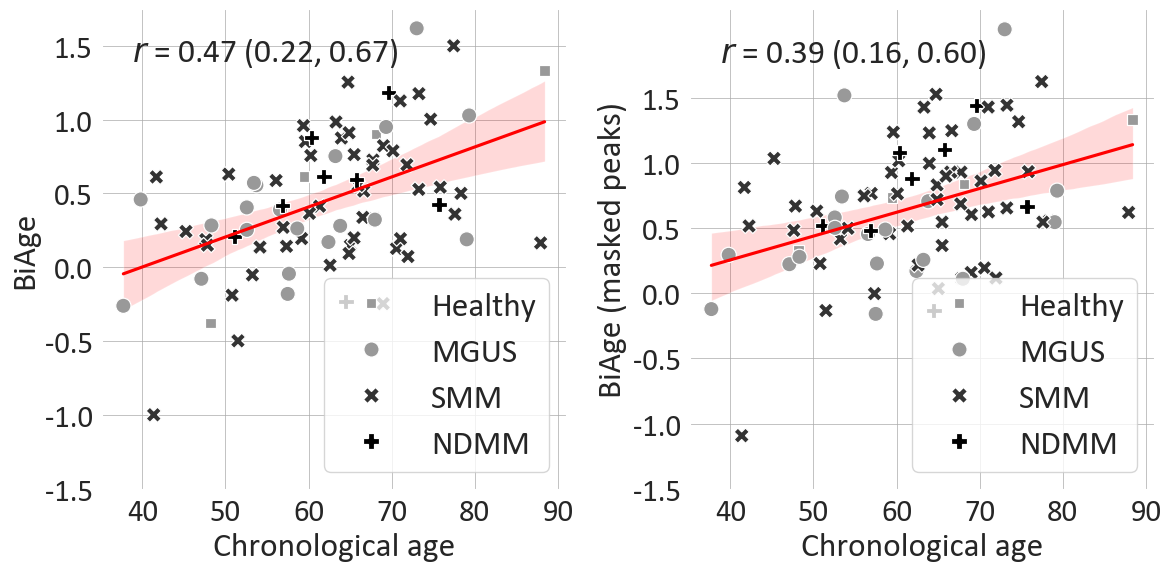

In [56]:
# FIGURE 3 A

palette_dict = {"Healthy": "#999999", "MGUS": "#999999", "SMM": "#333333", "NDMM": "#000000"}
plt.figure(figsize=(pp_size * 2, pp_size))
for j, peak_method in enumerate(["Age score", "Age score (peaks dropped out)", ]):  # , "Age score (peaks dropped out)"
    plt.subplot(1, 2, j + 1)
    x, y = scbcr_finaldata["Age"], scbcr_finaldata[peak_method]
    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    xymin, xymax = min(x.min(), y.min()), max(x.max(), y.max())
    xyrange = xymax - xymin
    xrange, yrange = xmax - xmin, ymax - ymin
    r, p = scipy.stats.pearsonr(x=x, y=y)
    if confidence_level is not None:
        assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
        bts_results = stats.bootstrap((x, y), scipy.stats.pearsonr, paired=True, n_resamples=9999, confidence_level=confidence_level,
                                      random_state=1)
        r_lo = bts_results.confidence_interval[0][0]
        r_hi = bts_results.confidence_interval[1][0]
    else:
        r_lo, r_hi = None, None
    # plot points and line
    ax = sns.regplot(x=x, y=y, scatter_kws={"color": "black", "alpha": 0.0}, line_kws={"color": "red"})
    # for i in range(len(scbcr_finaldata)):
    #     plt.plot((scbcr_finaldata["Age score"].iloc[i], scbcr_finaldata["Age score"].iloc[i]),
    #              (scbcr_finaldata["Chao_lo"].iloc[i], scbcr_finaldata["Chao_hi"].iloc[i]),
    #              color="black")
    sns.scatterplot(x=x, y=y, hue=scbcr_finaldata["Diagnosis"], style=scbcr_finaldata["Diagnosis"], s=scatter_plot_size,
                    palette=palette_dict, ax=ax)
    # text
    if j >= 0:
        (lxpos, lypos) = (xmin + xrange * .02, ymin + yrange * .98)
        va, ha = "top", "left"
    else:
        (lxpos, lypos) = (xmin + xrange * .02, ymin + yrange * .02)
        va, ha = "bottom", "left"
    lm_text = "UNDEFINED"
    if confidence_level is not None:
        lm_text = r"$\mathit{r}$" + f' = {r:.2f} ({r_lo:.2f}, {r_hi:.2f})'
    else:
        lm_text = r"$\mathit{r}$" + f' = {r:.2f}' + f"\np = {p:.3g}"
    plt.text(lxpos, lypos, lm_text, verticalalignment=va, horizontalalignment=ha,
             font=legend_font_params)
    # labels
    plt.xlabel("Chronological age", **labels_font_params)
    plt.ylabel(peak_method_2_label[peak_method], **labels_font_params)
    # a = plt.gca()
    plt.xticks([40, 50, 60, 70, 80, 90])
    ax.set_xticklabels(ax.get_xticks().astype(int), fontdict=ticks_font_params)
    plt.yticks([-1.5, -1., -0.5, 0, .5, 1., 1.5])
    yticks = ax.get_yticks()
    ax.set_yticklabels(yticks, fontdict=ticks_font_params)
    # legend
    handles, labels = ax.get_legend_handles_labels()
    order = [np.where(np.array(labels) == v)[0][0] for v in ["Healthy", "MGUS", "SMM", "NDMM"]]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop=legend_font_params)
    # ax.legend(prop=legend_font_params)
    # grid
    plt.grid(color='#aaaaaa', linewidth=0.5)
plt.tight_layout()
plt.show()

We can add a first dimension to our plots, and compare BiAge to BMPC diversity while also displaying chronological age of patients
    
This is **Figure 3D** 

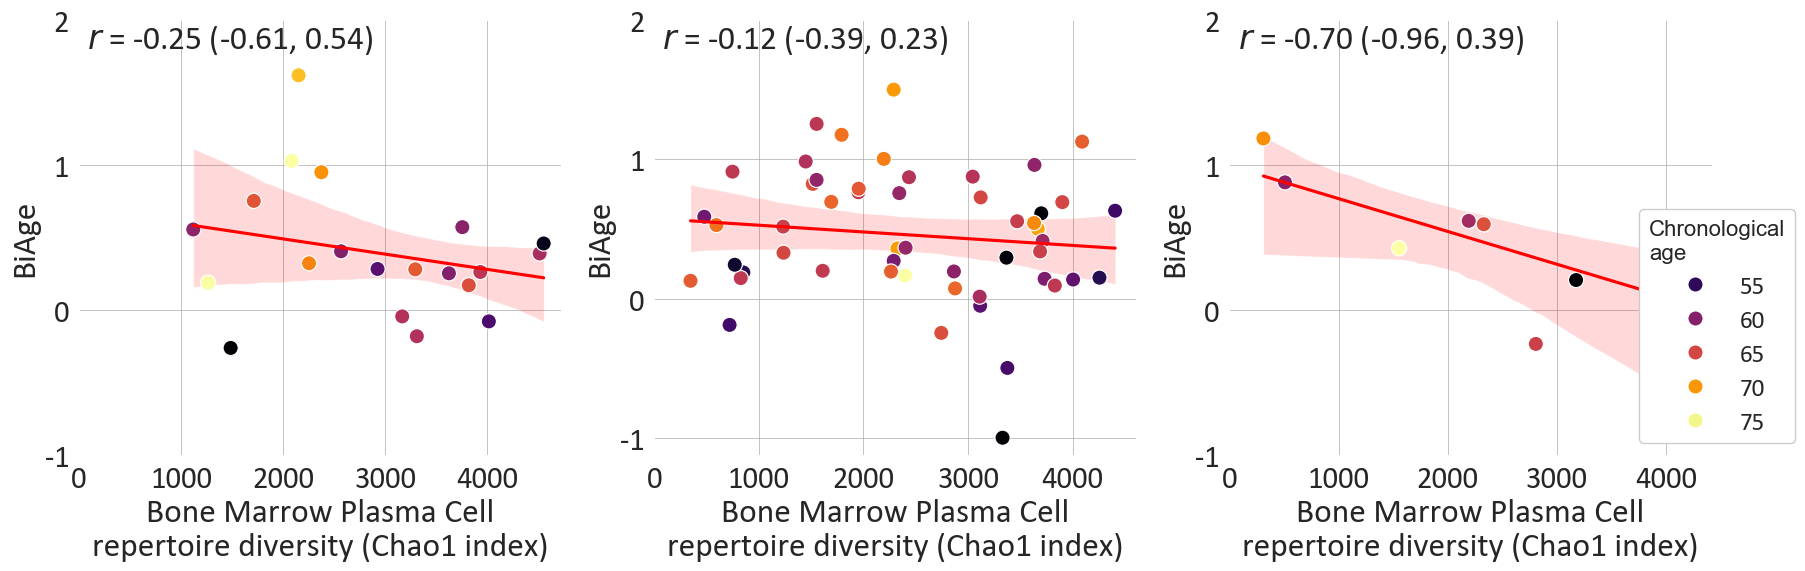

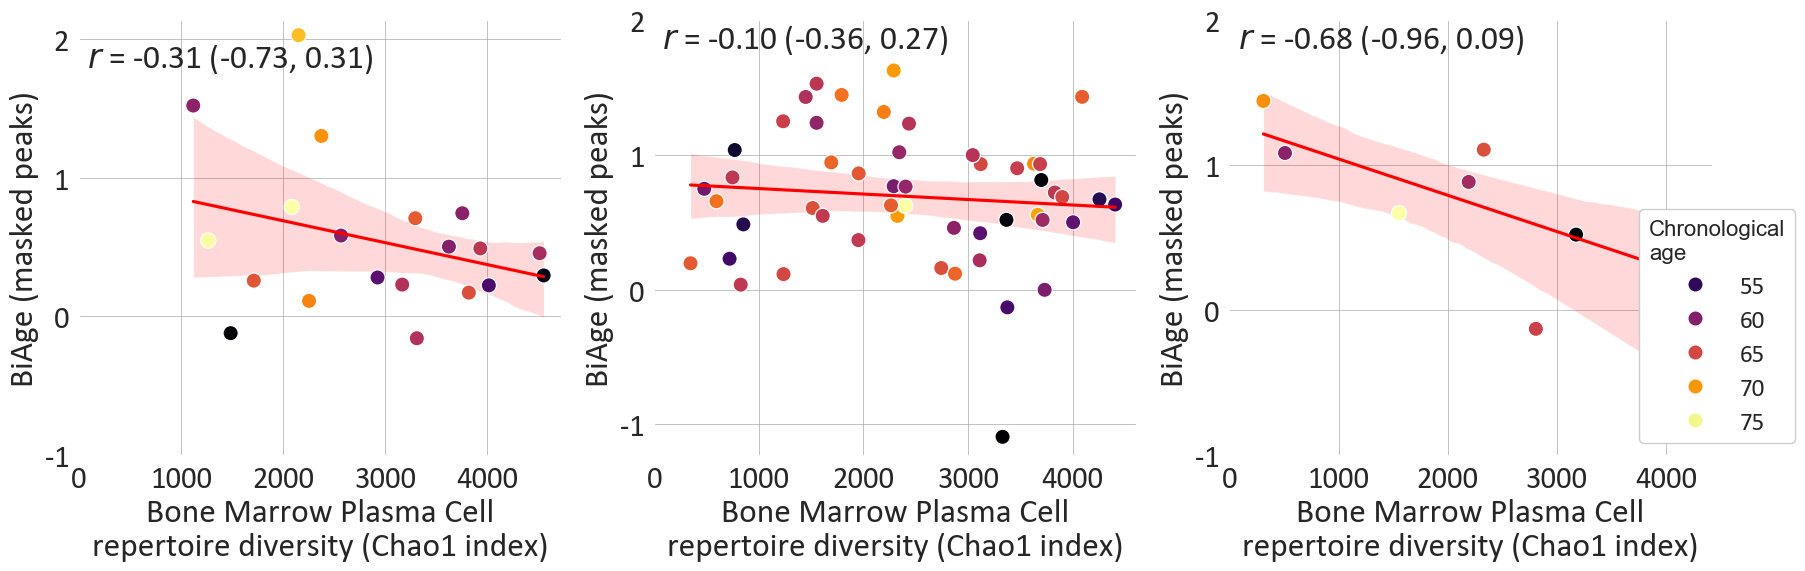

In [57]:
# FIGURE 3 D

# also do 1 per diagnosis
col3d_name = "Age"
for j, peak_method in enumerate(["Age score", "Age score (peaks dropped out)", ]):  # "Age score (peaks dropped out)"
    plt.figure(figsize=(pp_size * 3 + 0.2, pp_size))
    for jj, diag in enumerate(["MGUS", "SMM", "NDMM"]):  # not enough patients for healthy
        show_legend = jj == 2
        plt.subplot(1, 3, jj + 1)
        tmp_plot_data = scbcr_finaldata[scbcr_finaldata.Diagnosis == diag].copy()
        x, y = tmp_plot_data["Chao"], tmp_plot_data[peak_method]
        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        xrange, yrange = xmax - xmin, ymax - ymin
        r, p = scipy.stats.pearsonr(x=x, y=y)
        if confidence_level is not None:
            assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
            bts_results = stats.bootstrap((x, y), scipy.stats.pearsonr, paired=True, n_resamples=9999,
                                          confidence_level=confidence_level, random_state=1)
            r_lo = bts_results.confidence_interval[0][0]
            r_hi = bts_results.confidence_interval[1][0]
        else:
            r_lo, r_hi = None, None
        # plot points and line
        ax = sns.regplot(x=x, y=y, scatter_kws={"color": "black", "alpha": 0.0}, line_kws={"color": "red"})
        # for i in range(len(tmp_plot_data)):
        #     plt.plot((tmp_plot_data["Age score"].iloc[i], tmp_plot_data["Age score"].iloc[i]),
        #              (tmp_plot_data["Chao_lo"].iloc[i], tmp_plot_data["Chao_hi"].iloc[i]),
        #              color="black")
        sns.scatterplot(x=x, y=y, hue=tmp_plot_data[col3d_name], s=scatter_plot_size, ax=ax,
                        palette="inferno", legend=show_legend)
        # text
        if j >= 0:
            (lxpos, lypos) = (75, 1.98)
            (lxpos, lypos) = (75, 1.98)
            va, ha = "top", "left"
            # (lxpos, lypos) = (xmax - xrange * .02, ymin + yrange * .98)
            # va, ha = "top", "right"
        else:
            (lxpos, lypos) = (xmin + xrange * .02, ymin + yrange * .02)
            va, ha = "bottom", "left"
        # plt.text(lxpos, lypos, r"$\mathit{r}$" + f' = {r:.2f}', verticalalignment=va, horizontalalignment=ha, font=legend_font_params)
        lm_text = "UNDEFINED"
        if confidence_level is not None:
            lm_text = r"$\mathit{r}$" + f' = {r:.2f} ({r_lo:.2f}, {r_hi:.2f})'
        else:
            lm_text = r"$\mathit{r}$" + f' = {r:.2f}' + f"\np = {p:.3g}"
        plt.text(lxpos, lypos, lm_text, verticalalignment=va, horizontalalignment=ha,
                 font=legend_font_params)
        # labels
        plt.xlabel("Bone Marrow Plasma Cell\nrepertoire diversity (Chao1 index)", **labels_font_params)
        plt.ylabel("Chronological age" if peak_method == "Age" else peak_method_2_label[peak_method], **labels_font_params)
        # a = plt.gca()
        plt.xticks(chao_ticks)
        ax.set_xticklabels(ax.get_xticks().astype(int), fontdict=ticks_font_params)
        if peak_method == "Age":
            plt.yticks([40, 50, 60, 70, 80, 90])
        else:
            plt.yticks([-1, 0, 1, 2])
        yticks = ax.get_yticks()
        ax.set_yticklabels(yticks, fontdict=ticks_font_params)
        # legend
        # handles, labels = ax.get_legend_handles_labels()
        # order = [np.where(np.array(labels) == v)[0][0] for v in ["MGUS", "SMM", "NDMM"]]
        # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop=legend_font_params)
        if show_legend:
            legend2_font_params = font_manager.FontProperties(family='Calibri',
                                                              weight='normal',
                                                              style='normal',
                                                              size=18)
            legend_title = "Chronological\nage" if col3d_name == "Age" else "[M-protein]" if col3d_name == "MProtein" else col3d_name
            legend = plt.legend(title=legend_title, prop=legend2_font_params,
                                bbox_to_anchor=(1.2, 0), loc='lower right')
            legend.get_frame().set_alpha(None)
        # gid
        plt.grid(color='#aaaaaa', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Partial correlations will allow assessing the partial impact of diversity (Chao) and chronological age in explaining BiAge, in all patients and according to the MG

In [58]:
# let's do a partial correlation
if pingouin_available:
    print("All patients")
    print(pg.corr(x=scbcr_finaldata["Chao"], y=scbcr_finaldata["Age score"]))  # n.s. 0.06
    print(pg.corr(x=scbcr_finaldata["Age"], y=scbcr_finaldata["Age score"]))  # n.s. 0.06
    print("")

    print("Healhty")
    print(pg.corr(x=scbcr_finaldata[scbcr_finaldata.Diagnosis == "Healthy"]["Age"],
                  y=scbcr_finaldata[scbcr_finaldata.Diagnosis == "Healthy"]["Age score"]))  # n.s. 0.07
    print("")

    print("MGUS")
    print(pg.corr(x=scbcr_finaldata[scbcr_finaldata.Diagnosis == "MGUS"]["Age"],
                  y=scbcr_finaldata[scbcr_finaldata.Diagnosis == "MGUS"]["Age score"]))  # n.s. 0.02
    print("")
    
    print("SMM")
    print(pg.corr(x=scbcr_finaldata[scbcr_finaldata.Diagnosis == "SMM"]["Age"],
                  y=scbcr_finaldata[scbcr_finaldata.Diagnosis == "SMM"]["Age score"]))  # n.s. 0.004
    print("")

    print("NDMM")
    print(pg.corr(x=scbcr_finaldata[scbcr_finaldata.Diagnosis == "NDMM"]["Age"],
                  y=scbcr_finaldata[scbcr_finaldata.Diagnosis == "NDMM"]["Age score"]))  # n.s. 0.55
    print("")
    

All patients
          n        r        CI95%    p-val   BF10     power
pearson  86 -0.20727  [-0.4, 0.0]  0.05551  0.817  0.486345
          n         r         CI95%     p-val      BF10    power
pearson  86  0.473347  [0.29, 0.62]  0.000004  4483.012  0.99702

Healhty
         n         r         CI95%     p-val  BF10  power
pearson  4  0.927423  [-0.31, 1.0]  0.072577  1.98    NaN

MGUS
          n         r         CI95%    p-val   BF10     power
pearson  20  0.533079  [0.12, 0.79]  0.01551  4.267  0.706241

SMM
          n         r        CI95%     p-val    BF10     power
pearson  52  0.397694  [0.14, 0.6]  0.003505  10.921  0.844012

NDMM
         n         r          CI95%     p-val   BF10     power
pearson  8  0.247483  [-0.55, 0.81]  0.554568  0.501  0.091235


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\pingouin\power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")


We can also compare the average BCR diversity (Chao) according to whether patients were seen with an accelerating BiAging or deccelerated BiAging

In [59]:
# check if patients predicted accelerated biageing have a decreased diversity
for subgroup in ["Healthy", "MGUS", "SMM", "NDMM"]:
    their_age = scbcr_finaldata[scbcr_finaldata.Diagnosis == subgroup]["Age"].values
    their_biage = scbcr_finaldata[scbcr_finaldata.Diagnosis == subgroup]["Age score"].values
    their_chao = scbcr_finaldata[scbcr_finaldata.Diagnosis == subgroup]["Chao"].values
    lm_model = linear_model.LinearRegression()
    lm_model.fit(their_age.reshape(-1, 1), their_biage.reshape(-1, 1))
    their_expected_biage = lm_model.predict(their_age.reshape(-1, 1)).reshape(-1)
    # get accelerated/decelerated chao values
    chao_accelerated_biage = their_chao[their_biage >= their_expected_biage]
    chao_decelerated_biage = their_chao[their_biage < their_expected_biage]
    # compute p values
    _, p = stats.mannwhitneyu(chao_accelerated_biage, chao_decelerated_biage)
    # compute cis
    abi_lo_ci, abi_hi_ci = stats.bootstrap((chao_accelerated_biage,), np.mean, n_resamples=9999, confidence_level=.99,
                                           random_state=1).confidence_interval
    dbi_lo_ci, dbi_hi_ci = stats.bootstrap((chao_decelerated_biage,), np.mean, n_resamples=9999, confidence_level=.99,
                                           random_state=1).confidence_interval
    print(f"For {subgroup=}")
    print(f"    Mean Chao in accelerated BiAging group: {chao_accelerated_biage.mean():.0f} ({abi_lo_ci:.0f}-{abi_hi_ci:.0f})")
    print(f"    Mean Chao in decelerated BiAging group: {chao_decelerated_biage.mean():.0f} ({dbi_lo_ci:.0f}-{dbi_hi_ci:.0f})")
    print(f"    p-value: {p:.2g}")

For subgroup='Healthy'
    Mean Chao in accelerated BiAging group: 3227 (2281-4174)
    Mean Chao in decelerated BiAging group: 1513 (875-2150)
    p-value: 0.33
For subgroup='MGUS'
    Mean Chao in accelerated BiAging group: 2775 (1988-3752)
    Mean Chao in decelerated BiAging group: 3016 (2071-3622)
    p-value: 0.57
For subgroup='SMM'
    Mean Chao in accelerated BiAging group: 2332 (1767-2909)
    Mean Chao in decelerated BiAging group: 2600 (1965-3107)
    p-value: 0.38
For subgroup='NDMM'
    Mean Chao in accelerated BiAging group: 1336 (361-2297)
    Mean Chao in decelerated BiAging group: 2941 (1555-3961)
    p-value: 0.11


We can check the correlations between chronological age, BiAge and diversity

In [60]:
if pingouin_available:
    print(">>> Correlation between BiAge and diversity")
    for grp in ["Healthy", "MGUS", "SMM", "NDMM"]:
        print(grp)
        print(pg.corr(x=scbcr_finaldata[scbcr_finaldata.Diagnosis == grp]["Chao"],
                      y=scbcr_finaldata[scbcr_finaldata.Diagnosis == grp]["Age score"]))
        print("")

    print(">>> Partial correlation between BiAge and diversity, adjusting for chronological age")
    print("All")
    print(pg.partial_corr(data=scbcr_finaldata, x="Chao", y="Age score", covar="Age"))
    print("")
    
    for grp in ["Healthy", "MGUS", "SMM", "NDMM"]:
        print(grp)
        print(pg.partial_corr(data=scbcr_finaldata[scbcr_finaldata.Diagnosis == grp], x="Chao", y="Age score", covar="Age"))
        print("")

    print("All, pair-wise correlations between diversity, BiAge and chronological age")
    print(pg.pairwise_corr(data=scbcr_finaldata, columns=["Chao", "Age score",
                                                            "Age"]).to_string())
    print("")

>>> Correlation between BiAge and diversity
Healthy
         n         r          CI95%     p-val   BF10  power
pearson  4 -0.295853  [-0.98, 0.93]  0.704147  0.631    NaN

MGUS
          n         r          CI95%     p-val   BF10     power
pearson  20 -0.251679  [-0.62, 0.21]  0.284431  0.473  0.190951

SMM
          n         r          CI95%     p-val   BF10     power
pearson  52 -0.121303  [-0.38, 0.16]  0.391646  0.247  0.137838

NDMM
         n         r         CI95%     p-val   BF10     power
pearson  8 -0.702619  [-0.94, 0.0]  0.051955  2.184  0.537451

>>> Partial correlation between BiAge and diversity, adjusting for chronological age
All
          n         r          CI95%     p-val
pearson  86 -0.084835  [-0.29, 0.13]  0.440144

Healthy
         n         r        CI95%     p-val
pearson  4  0.871682  [-1.0, 1.0]  0.326058

MGUS
          n         r         CI95%     p-val
pearson  20 -0.057489  [-0.5, 0.41]  0.815165

SMM
          n         r          CI95%     p-val


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\pingouin\power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\pingouin\effsize.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(nx - 3)


Below we observe the correlation between BiAge and chronlogical age, with diversity displayed as a 3rd dimension

This is **Figure 3C**

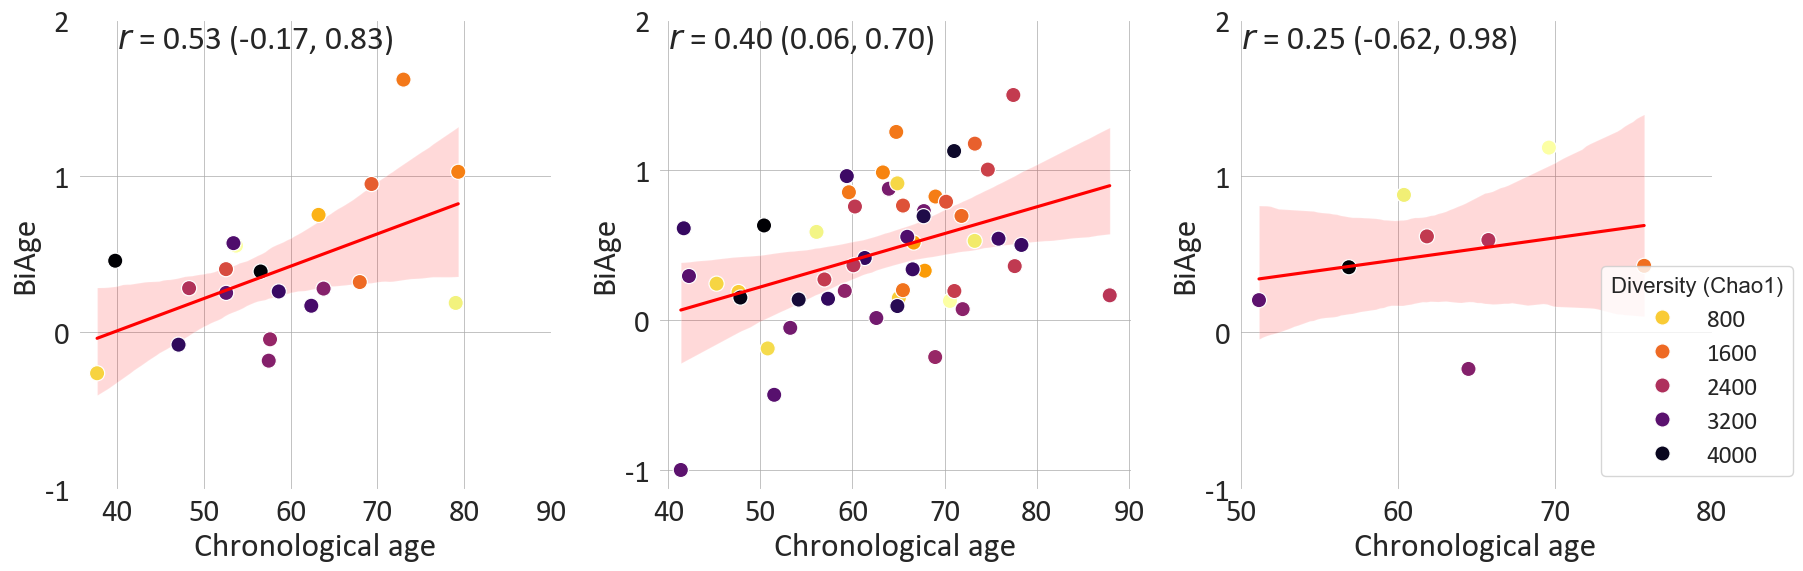

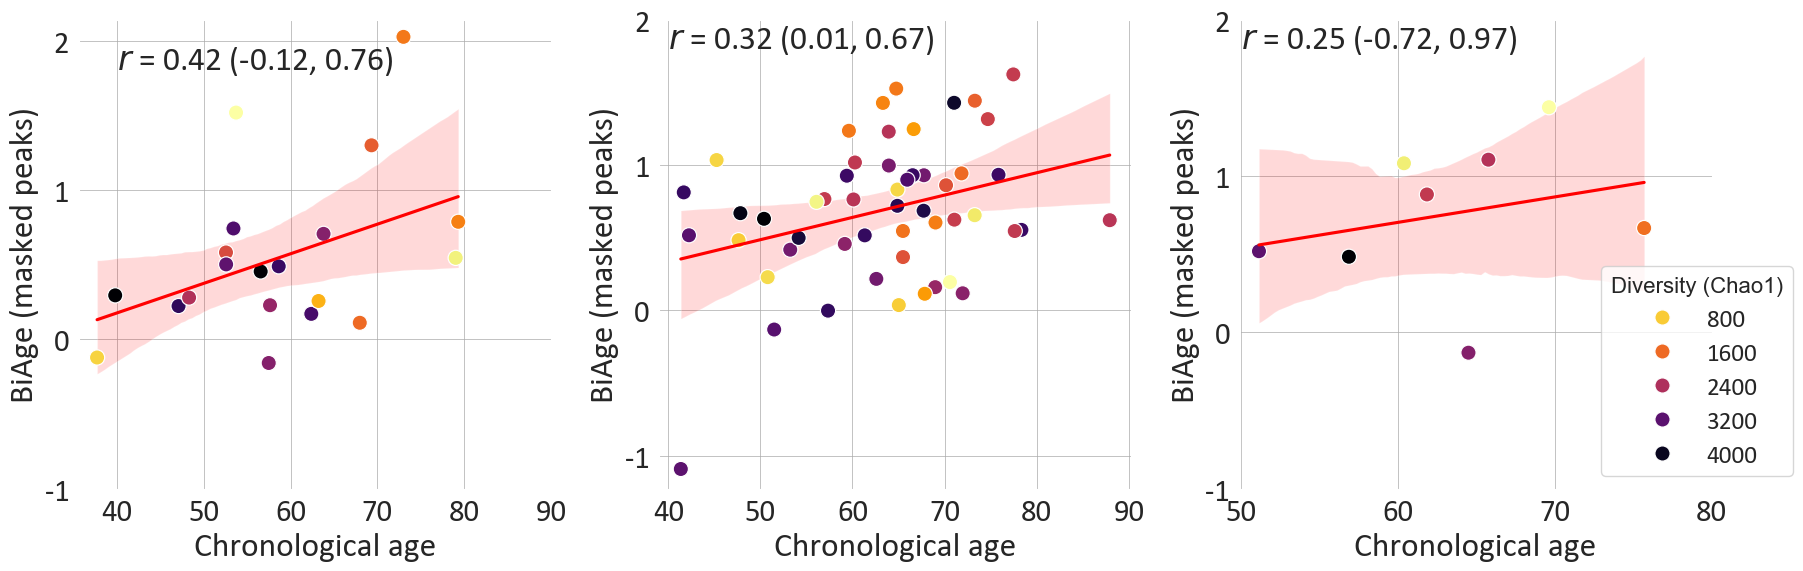

In [61]:
confidence_level = .99

# another type of correlation: h-age = f(chronological age), but with a 3d: diversity
col3d_name = "Chao"

# FIGURE 3 C

for j, peak_method in enumerate(["Age score", "Age score (peaks dropped out)", ]):  # "Age score (peaks dropped out)"
    plt.figure(figsize=(pp_size * 3 + 0.2, pp_size))
    for jj, diag in enumerate(["MGUS", "SMM", "NDMM"]):  # not enough patients for healthy
        show_legend = jj == 2
        plt.subplot(1, 3, jj + 1)
        tmp_plot_data = scbcr_finaldata[scbcr_finaldata.Diagnosis == diag].copy()
        x, y = tmp_plot_data["Age"], tmp_plot_data[peak_method]
        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        xrange, yrange = xmax - xmin, ymax - ymin
        r, p = scipy.stats.pearsonr(x=x, y=y)
        if confidence_level is not None:
            assert (confidence_level > .5) and (confidence_level < 1), f"Unexpected {confidence_level=}"
            bts_results = stats.bootstrap((x, y), scipy.stats.pearsonr, paired=True, n_resamples=9999,
                                          confidence_level=confidence_level, random_state=1)
            r_lo = bts_results.confidence_interval[0][0]
            r_hi = bts_results.confidence_interval[1][0]
        else:
            r_lo, r_hi = None, None
        # plot points and line
        ax = sns.regplot(x=x, y=y, scatter_kws={"color": "black", "alpha": 0.0}, line_kws={"color": "red"})
        # for i in range(len(tmp_plot_data)):
        #     plt.plot((tmp_plot_data["Age score"].iloc[i], tmp_plot_data["Age score"].iloc[i]),
        #              (tmp_plot_data["Chao_lo"].iloc[i], tmp_plot_data["Chao_hi"].iloc[i]),
        #              color="black")
        palette = "inferno_r" if col3d_name == "Chao" else "inferno"
        sns.scatterplot(x=x, y=y, hue=tmp_plot_data[col3d_name], s=scatter_plot_size, ax=ax,
                        palette=palette, legend=show_legend)
        # text
        if jj < 2:
            (lxpos, lypos) = (40, 1.98)
            va, ha = "top", "left"
        else:
            (lxpos, lypos) = (50, 1.98)
            va, ha = "top", "left"
        # plt.text(lxpos, lypos, r"$\mathit{r}$" + f' = {r:.2f}', verticalalignment=va, horizontalalignment=ha, font=legend_font_params)
        lm_text = "UNDEFINED"
        if confidence_level is not None:
            lm_text = r"$\mathit{r}$" + f' = {r:.2f} ({r_lo:.2f}, {r_hi:.2f})'
        else:
            lm_text = r"$\mathit{r}$" + f' = {r:.2f}' + f"\np = {p:.3g}"
        plt.text(lxpos, lypos, lm_text, verticalalignment=va, horizontalalignment=ha,
                 font=legend_font_params)
        # labels
        plt.xlabel("Chronological age", **labels_font_params)
        plt.ylabel(peak_method_2_label[peak_method], **labels_font_params)
        # a = plt.gca()
        if jj < 2:
            plt.xticks([40, 50, 60, 70, 80, 90])
        else:
            plt.xticks([50, 60, 70, 80])
        ax.set_xticklabels(ax.get_xticks().astype(int), fontdict=ticks_font_params)
        plt.yticks([-1, 0, 1, 2])
        yticks = ax.get_yticks()
        ax.set_yticklabels(yticks.astype(int), fontdict=ticks_font_params)
        # legend
        # handles, labels = ax.get_legend_handles_labels()
        # order = [np.where(np.array(labels) == v)[0][0] for v in ["MGUS", "SMM", "NDMM"]]
        # plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop=legend_font_params)
        if show_legend:
            legend2_font_params = font_manager.FontProperties(family='Calibri',
                                                              weight='normal',
                                                              style='normal',
                                                              size=18)
            legend_title = "Diversity (Chao1)" if col3d_name == "Chao" else "[M-Protein]" if col3d_name == "MProtein" else "?"
            legend = plt.legend(title=legend_title, prop=legend2_font_params,
                                bbox_to_anchor=(1.2, 0), loc='lower right')
            # legend.get_frame().set_alpha(None)
        # gid
        plt.grid(color='#aaaaaa', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Next we can calculate the partial correlation between BiAge and chronological age, after adjusting for diversity

In [62]:
if pingouin_available:
    print("All")
    print(pg.partial_corr(data=scbcr_finaldata, x="Age", y="Age score", covar="Chao"))
    print("")
    
    for grp in ["Healthy", "MGUS", "SMM", "NDMM"]:
        print(grp)
        print(pg.partial_corr(data=scbcr_finaldata[scbcr_finaldata.Diagnosis == grp], x="Age", y="Age score", covar="Chao"))
        print("")

All
          n         r        CI95%     p-val
pearson  86  0.441658  [0.25, 0.6]  0.000023

Healthy
         n         r        CI95%     p-val
pearson  4  0.981418  [-1.0, 1.0]  0.122919

MGUS
          n        r         CI95%     p-val
pearson  20  0.48815  [0.04, 0.77]  0.033969

SMM
          n         r        CI95%     p-val
pearson  52  0.387048  [0.12, 0.6]  0.005019

NDMM
         n         r          CI95%     p-val
pearson  8 -0.240384  [-0.84, 0.63]  0.603599


C:\Users\flori\anaconda3\envs\py311_torch21gpu_feb25\Lib\site-packages\pingouin\effsize.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(nx - 3)


# Feature exploration

First, we will declare all functions that will be used to extract the features from raw spectra

The code below will be responsible of converting a raw spectrum trace into gaussians representing the different sub populations (lambda 1, kappa 1, lambda 2, kappa 2, etc.)

In [63]:
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
from pybaselines import Baseline

# default parameters
DEFAULT_GAUSSIANS = ["ll", "lk", "hl", "hk", "c1q"]
DEFAULT_GAUSSIAN_NAMES = [["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"],
                          ["λ1", "κ1", "λ2", "κ2", "C1q"], ]
DEFAULT_ISOTYPES = "GAMKL"
DEFAULT_HARDCODED_PARAMS = {'ll_mz': 11414, 'll_width': 150.,
                            'lk_mz': 11701, 'lk_width': 150.,
                            'hl_mz': 11752, 'hl_width': 200.,
                            'hk_mz': 12060, 'hk_width': 200.,
                            'c1q_mz': 12018, 'c1q_width': 15.,
                            }
DEFAULT_INIT_GLOBAL_PARAMS = {
    "ll_mz_mod": 0, "lk_mz_mod": 0, "hl_mz_mod": 0, "hk_mz_mod": 0, "c1q_mz_mod": 0,
    "iso0_mz_mod": 0, "iso1_mz_mod": 0, "iso2_mz_mod": 0, "iso3_mz_mod": 0, "iso4_mz_mod": 0,
    "ll_width_mod": 0, "lk_width_mod": 0, "hl_width_mod": 0, "hk_width_mod": 0, "c1q_width_mod": 0,
    "iso0_width_mod": 0, "iso1_width_mod": 0, "iso2_width_mod": 0, "iso3_width_mod": 0, "iso4_width_mod": 0,
    "ll_iso0_weight": 0.6, "lk_iso0_weight": 0.9, "hl_iso0_weight": 0.05, "hk_iso0_weight": 0.15, "c1q_iso0_weight": 0.005,
    "ll_iso1_weight": 0.85, "lk_iso1_weight": 0.85, "hl_iso1_weight": 0.05, "hk_iso1_weight": 0.15, "c1q_iso1_weight": 0.005,
    "ll_iso2_weight": 0.77, "lk_iso2_weight": 0.9, "hl_iso2_weight": 0.02, "hk_iso2_weight": 0.4, "c1q_iso2_weight": 0.005,
    "ll_iso3_weight": 0.01, "lk_iso3_weight": 0.9, "hl_iso3_weight": 0.001, "hk_iso3_weight": 0.15, "c1q_iso3_weight": 0.005,
    "ll_iso4_weight": 0.95, "lk_iso4_weight": 0.01, "hl_iso4_weight": 0.06, "hk_iso4_weight": 0.001, "c1q_iso4_weight": 0.1,
}
INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX = 5  # we won't tolerate much offset for any specific gaussian (either all gaussians are shifted or none, basically)
INDIVIDUAL_ISOTYPE_MZ_MOD_MAX = 50  # we tolerate a specific track to be offset to some extent
INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX = 5  # we won't tolerate much offset for any specific gaussian (either all gaussians are narrower or none, basically)
INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX = 50  # we tolerate a specific track to be offset to some extent: in particular we noticed that IgMs tend to be narrower
DEFAULT_GLOBAL_PARAMS_LBOUNDS = {
    "ll_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "lk_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "hl_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "hk_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "c1q_mz_mod": -INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "iso0_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso1_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso2_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "iso3_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso4_mz_mod": -INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "ll_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "lk_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX,
    "hl_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "hk_width_mod": -INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "c1q_width_mod": -5,
    "iso0_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso1_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso2_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso3_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso4_width_mod": -INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "ll_iso0_weight": 0., "lk_iso0_weight": 0., "hl_iso0_weight": 0., "hk_iso0_weight": 0., "c1q_iso0_weight": 0.,
    "ll_iso1_weight": 0., "lk_iso1_weight": 0., "hl_iso1_weight": 0., "hk_iso1_weight": 0., "c1q_iso1_weight": 0.,
    "ll_iso2_weight": 0., "lk_iso2_weight": 0., "hl_iso2_weight": 0., "hk_iso2_weight": 0., "c1q_iso2_weight": 0.,
    "ll_iso3_weight": 0., "lk_iso3_weight": 0., "hl_iso3_weight": 0., "hk_iso3_weight": 0., "c1q_iso3_weight": 0.,
    "ll_iso4_weight": 0., "lk_iso4_weight": 0., "hl_iso4_weight": 0., "hk_iso4_weight": 0., "c1q_iso4_weight": 0.,
}
DEFAULT_GLOBAL_PARAMS_UBOUNDS = {
    "ll_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "lk_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "hl_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "hk_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX, "c1q_mz_mod": INDIVIDUAL_GAUSSIAN_MZ_MOD_MAX,
    "iso0_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso1_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso2_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "iso3_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX, "iso4_mz_mod": INDIVIDUAL_ISOTYPE_MZ_MOD_MAX,
    "ll_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "lk_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "hl_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX,
    "hk_width_mod": INDIVIDUAL_GAUSSIAN_WIDTH_MOD_MAX, "c1q_width_mod": 5,
    "iso0_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso1_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso2_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX, "iso3_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "iso4_width_mod": INDIVIDUAL_ISOTYPE_WIDTH_MOD_MAX,
    "ll_iso0_weight": 1., "lk_iso0_weight": 1., "hl_iso0_weight": .1, "hk_iso0_weight": .5, "c1q_iso0_weight": 0.01,
    "ll_iso1_weight": 1., "lk_iso1_weight": 1., "hl_iso1_weight": .1, "hk_iso1_weight": .5, "c1q_iso1_weight": 0.01,
    "ll_iso2_weight": 1., "lk_iso2_weight": 1., "hl_iso2_weight": .1, "hk_iso2_weight": .5, "c1q_iso2_weight": 0.01,
    "ll_iso3_weight": .1, "lk_iso3_weight": 1., "hl_iso3_weight": .01, "hk_iso3_weight": .5, "c1q_iso3_weight": 0.01,
    "ll_iso4_weight": 1., "lk_iso4_weight": .1, "hl_iso4_weight": 2., "hk_iso4_weight": .01, "c1q_iso4_weight": 0.15,
}
DEFAULT_GLOBAL_PARAMS_BOUNDS = (DEFAULT_GLOBAL_PARAMS_LBOUNDS, DEFAULT_GLOBAL_PARAMS_UBOUNDS)
P_KEYS = ['ll_mz_mod', 'lk_mz_mod', 'hl_mz_mod', 'hk_mz_mod', 'c1q_mz_mod', 'iso0_mz_mod', 'iso1_mz_mod', 'iso2_mz_mod', 'iso3_mz_mod', 'iso4_mz_mod',
          'll_width_mod', 'lk_width_mod', 'hl_width_mod', 'hk_width_mod', 'c1q_width_mod', 'iso0_width_mod', 'iso1_width_mod', 'iso2_width_mod',
          'iso3_width_mod', 'iso4_width_mod', 'll_iso0_weight', 'lk_iso0_weight', 'hl_iso0_weight', 'hk_iso0_weight', 'c1q_iso0_weight', 'll_iso1_weight',
          'lk_iso1_weight', 'hl_iso1_weight', 'hk_iso1_weight', 'c1q_iso1_weight', 'll_iso2_weight', 'lk_iso2_weight', 'hl_iso2_weight', 'hk_iso2_weight',
          'c1q_iso2_weight', 'll_iso3_weight', 'lk_iso3_weight', 'hl_iso3_weight', 'hk_iso3_weight', 'c1q_iso3_weight', 'll_iso4_weight', 'lk_iso4_weight',
          'hl_iso4_weight', 'hk_iso4_weight', 'c1q_iso4_weight']
# default colors
# DEFAULT_LKCOLOR = "#D1E9F6"  # light blue
# DEFAULT_HKCOLOR = "#55679C"  # dark blue
# DEFAULT_LLCOLOR = "#D5ED9F"  # light green
# DEFAULT_HLCOLOR = "#0D7C66"  # dark green
DEFAULT_LLCOLOR = "#D1E9F6"  # light blue
DEFAULT_HLCOLOR = "#55679C"  # dark blue
DEFAULT_LKCOLOR = "#FFCD90"  # light orange
DEFAULT_HKCOLOR = "#FF8D21"  # dark orange
DEFAULT_C1QCOLOR = "#0D7C66"  # dark green

DEFAULT_PARAM_COLORS = [[DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR],
                        [DEFAULT_LLCOLOR, DEFAULT_LKCOLOR, DEFAULT_HLCOLOR, DEFAULT_HKCOLOR, DEFAULT_C1QCOLOR]]

def load_sample_ms_data_for_deconvolution(dataset_path: str, match_id: str, remove_background_noise: bool = True, normalization: str = ["auc", "01"][1]):
    """
    Same as python.pyms_assets.dl_ms_data_manager.load_sample_ms_data, but with an extra step of cleaning/normalizing the sample

    :param dataset_path: str, the path to the MS dataset
    :param match_id: str, the Match ID of the sample
    :return: np.array, the MS raw data for this sample
    """

    x = load_sample_ms_data(dataset_path, match_id)
    if remove_background_noise:
        x[1, ...] = x[1, ...] - x[1, ...].min(axis=1, keepdims=True)
    if normalization == "auc":
        x[1, ...] = x[1, ...] / (np.trapz(x[1, ...], x[0, ...])[:, None])
    elif normalization == "01":
        x[1, ...] = x[1, ...] / x[1, ...].max(axis=1, keepdims=True)
    else:
        assert False, f"Unknown {normalization=}"
    return x


def digitize_msdata(x: np.array, isotype: int):
    """
    Prepare MS data for modelling
    # basically for one isotype (G, A, M, K, L) we take the list of m/z and corresponding counts
    # and turn that into a pd.DataFrame with two columns: m/z and count

    :param x: np.array of shape (2,5,n) with n a variable length for the MS trace
    :param isotype: int, the index of the isotype we want to select
    :return: pd.DataFrame
    """
    ms_digitized_data = pd.DataFrame(np.stack([x[0, isotype, :], x[1, isotype, :]], axis=1))
    return ms_digitized_data


def global_gaussian_func_maker_v2(harcoded_params: dict, p_keys: list, n_isotypes: int, gaussians: list):
    """
    reconstructs (models) the count based on m/z and parameters of the underlying gaussians

    :param harcoded_params: harcoded params, i.e. parameters that cannot be changed (such as m/z center of gaussians)
    :param p_keys: keys used for converting the list of parameters to a dict of parameters
    :param n_isotypes: number of isotypes, usually 5
    :param gaussians: number and names of gaussians, usually ["ll", "lk", "hl", "hk", "c1q"]
    :return:
    """

    # create a new function modifying the hardcoded params by the p0 parameters
    def temp_global_gaussian_func(x_raw: np.array, *p):
        named_p = dict(zip(p_keys, p))

        xy_size = len(x_raw) // n_isotypes
        y_pred = np.zeros_like(x_raw)
        for iso in range(n_isotypes):
            for gaussn in gaussians:
                ctr = harcoded_params[f"{gaussn}_mz"] + named_p[f"{gaussn}_mz_mod"] + named_p[f"iso{iso}_mz_mod"]
                width = harcoded_params[gaussn + "_width"] + named_p[f"{gaussn}_width_mod"] + named_p[f"iso{iso}_width_mod"]
                amp = named_p[f"{gaussn}_iso{iso}_weight"]

                y_pred[(iso * xy_size):((iso + 1) * xy_size)] += amp * np.exp(
                    -((x_raw[(iso * xy_size):((iso + 1) * xy_size)] - ctr) / width) ** 2)
        return y_pred

    return temp_global_gaussian_func


def optimize_global_params(x: np.array, p_keys: list, gaussians: list, n_isotypes: int, harcoded_params: dict, init_global_params: dict,
                           global_params_bounds: tuple):
    """
    optimize initial gaussian parameters to make them fit a y=f(x) count=f(m/z) full ms spectra; does optimization for all tracks (isotypes) at the same time

    :param x: array of ms data
    :param p_keys: names of the gaussian parameters used in init_global_params
    :param gaussians: number and names of gaussians
    :param n_isotypes: number of isotypes, usually 5
    :param harcoded_params: harcoded parameters for the gaussians, such as m/z center of the gaussians
    :param init_global_params: initial (unoptimized) gaussian parameters
    :param global_params_bounds: boundaries for the gaussian parameters (min anx max)
    :return:
    """

    from scipy.optimize import curve_fit

    # convert ms digitized data (pd.DataFrame) to np.arrays
    x_raw = np.concatenate([x[0, iso, :] for iso in range(n_isotypes)])
    y_raw = np.concatenate([x[1, iso, :] for iso in range(n_isotypes)])

    p0 = [init_global_params[k] for k in p_keys]
    p_bounds = ([global_params_bounds[0][k] for k in p_keys],
                [global_params_bounds[1][k] for k in p_keys])

    # returns the fitting parameters, accepts the function,data and init_para
    # noinspection PyTupleAssignmentBalance
    popt_gauss, pcov_gauss = curve_fit(
        f=global_gaussian_func_maker_v2(harcoded_params=harcoded_params, p_keys=p_keys, n_isotypes=n_isotypes, gaussians=gaussians),
        xdata=x_raw, ydata=y_raw, p0=p0, bounds=p_bounds, maxfev=50000)

    # convert back to the params format
    optim_global_params = dict(zip(p_keys, popt_gauss))

    return optim_global_params


def global_params_to_params(harcoded_params: dict, optim_global_params: dict, n_isotypes: int, gaussians: list):
    """
    convert dict in the format "global_params" to "params" (useful for plotting modelling results)

    :param harcoded_params: see previous functions
    :param optim_global_params: init_params after optimization by a previous function
    :param n_isotypes: 5
    :param gaussians: number and names of the gaussians
    :return:
    """
    # convert new global format to old format by isotype
    convert_params = []
    for iso in range(n_isotypes):
        convert_iso_params = []
        for gaussi, gaussn in enumerate(gaussians):
            convert_iso_params.append({"weight": optim_global_params[f"{gaussn}_iso{iso}_weight"],
                                       "mean": harcoded_params[f"{gaussn}_mz"] + optim_global_params[f"{gaussn}_mz_mod"] + optim_global_params[
                                           f"iso{iso}_mz_mod"],
                                       "std": harcoded_params[f"{gaussn}_width"] + optim_global_params[f"{gaussn}_width_mod"] + optim_global_params[
                                           f"iso{iso}_width_mod"]})
        convert_params.append(convert_iso_params)
    return convert_params


def deconvolute_gaussians_v2(dataset_path: str, match_id: str, p_keys: list, gaussians: list, n_isotypes: int,
                             harcoded_params: dict, init_global_params: dict, global_params_bounds: tuple,
                             return_rmse: bool = False):
    """
    Deconvolute the gaussians of a MS sample

    :param dataset_path: str, the path to the MS dataset
    :param match_id: str, the Match ID of the sample
    :param gaussians: number and names of gaussians, usually ["ll", "lk", "hl", "hk", "c1q"]
    :param n_isotypes: number of isotypes, usually 5
    :param harcoded_params: harcoded params, i.e. parameters that cannot be changed (such as m/z center of gaussians)
    :param init_global_params: initial (unoptimized) gaussian parameters
    :param global_params_bounds: boundaries for the gaussian parameters (min anx max)
    :param return_rmse: bool, whether to also return rmse between original and reconstructed data
    :return:
    """

    x = load_sample_ms_data_for_deconvolution(dataset_path, match_id)

    ms_digitized_data_buffer = [digitize_msdata(x=x, isotype=isotype) for isotype in range(n_isotypes)]

    optim_global_params = optimize_global_params(x=x,
                                                 p_keys=p_keys,
                                                 gaussians=gaussians,
                                                 n_isotypes=n_isotypes,
                                                 harcoded_params=harcoded_params,
                                                 init_global_params=init_global_params,
                                                 global_params_bounds=global_params_bounds)

    optim_params_buffer = global_params_to_params(harcoded_params=harcoded_params, optim_global_params=optim_global_params,
                                                  n_isotypes=n_isotypes, gaussians=gaussians)

    if return_rmse:
        # QC (rmse)
        ggmxs = [model_trace_from_gaussians(ms_digitized_data.iloc[:, 0], optim_params).values for ms_digitized_data, optim_params in
                 zip(ms_digitized_data_buffer, optim_params_buffer)]
        ggmxs = np.stack(ggmxs, axis=0)
        groundtruths = np.stack([ms_digitized_data.iloc[:, 1].values for ms_digitized_data in ms_digitized_data_buffer], axis=0)
        rmse = np.sum(np.power(groundtruths - ggmxs, 2))
        return ms_digitized_data_buffer, optim_params_buffer, rmse

    return ms_digitized_data_buffer, optim_params_buffer


def gaussian_func(x: np.array, *p):
    """
    Generate a trace from the list of m/z and the mean, std and weight of one/multiple gaussian distributions

    :param x: np.array, the list of m/z of the MS trace
    :param p: the list of parameters of the gaussians; length must be a multiple of 3
    :return: np.array, the y matching the x, i.e. the modelled count list (MS trace) according to the gaussian distributions parameters passed to the function
    """
    y = np.zeros_like(x)
    for i in range(0, len(p), 3):
        amp = p[i]  # amplitude
        ctr = p[i + 1]  # peak location
        width = p[i + 2]  # standard deviation
        y += amp * np.exp(-((x - ctr) / width) ** 2)
    return y


def model_trace_from_gaussians(x: np.array, params: list):
    """
    Generate a trace from the list of m/z and the mean, std and weight of one/multiple gaussian distributions

    :param x: np.array, the list of m/z of the MS trace
    :param params: a list of gaussian parameters, shape [{"weight": weight1, "mena": mean1, "std": std1}, ..., {"weight": weightN, "mena": meanN, "std": stdN}] with N gaussians
    :return: np.array, the y matching the x, i.e. the modelled count list (MS trace) according to the gaussian distributions parameters passed to the function
    """
    p = [v for param in params for v in [param["weight"], param["mean"], param["std"]]]
    return gaussian_func(x, *p)

Then, the code below will be responsible of detecting peaks with a very high sensitivity

In [64]:
def ipsa_baseline(x_track: np.array, half_window: int = 40, tol: float = 1e-3) -> np.array:
    """
    Smoothes an MS spectra using the IPSA method (see pybaselines package)
    Used primarily to compute a "baseline", i.e. a smooth model of the trace without peaks, used to both detect and quantify peaks
    See Mass Fix article for details about this detection/quantification method
    May be chosen over ria, Mass Fix article states it uses a method close to the ipsa/ria algorithms from the pybaselines package

    :param x_track: the MS spectra np array of the isotype, i.e. of shape 2xN
    :param half_window: the half_window parameter used by the pybaselines' package "ipsa" function. Optimal value found empirically was 40.
    :param tol: the tol parameter used by the pybaselines' package "ipsa" function. Optimal value found empirically was 1e-3.
    :return: the smoothed spectra, a numpy.array of shape 2xN
    """
    new_x_track = x_track.copy()
    baseline_fitter = Baseline(x_track[0, :], check_finite=False)
    synthetic_distrib = baseline_fitter.ipsa(x_track[1, :], half_window=half_window, tol=tol)[0]
    new_x_track[1, :] = synthetic_distrib
    return new_x_track


def peak_detection_v3(dataset_path: str, match_id: str, pre_smooth_sigma: int = 3, residuals_gaussian_sigma: int = 10, peak_height_threshold: float = .01):

    # get a random sample (negative, so we have some peaks to detect)
    # load the sample data
    x = load_sample_ms_data_for_deconvolution(dataset_path=dataset_path,
                                              match_id=match_id,
                                              remove_background_noise=True,
                                              normalization="01")

    if pre_smooth_sigma > 0:
        x[1, ...] = gaussian_filter(x[1, ...], sigma=pre_smooth_sigma, axes=1)

    # model the raw ms trace using ipsa
    x_ipsa = np.stack([ipsa_baseline(x[:, iso, :])[1] for iso in range(5)], axis=0)

    residuals = x[1] - x_ipsa
    smoothed_residuals = gaussian_filter(residuals, sigma=residuals_gaussian_sigma, axes=1)

    peaks_data = [find_peaks(smoothed_residuals[iso], height=peak_height_threshold) for iso in range(5)]

    # remove any peaks in the lambda region that would be C1q
    retain_lambda_peaks = []
    found_lambda_peaks_to_remove = False
    for lambda_peak_i, lambda_peak_pos in enumerate(peaks_data[4][0]):
        if x[0, 4, lambda_peak_pos] < 12000:
            retain_lambda_peaks.append(lambda_peak_i)
        else:
            found_lambda_peaks_to_remove = True
    if found_lambda_peaks_to_remove:
        peaks_data[4] = (peaks_data[4][0][retain_lambda_peaks],
                         {"peak_heights": peaks_data[4][1]["peak_heights"][retain_lambda_peaks]})

    # we could optionally get the peaks prominence
    for iso in range(5):
        peaks_data[iso][1]["prominences"] = peak_prominences(smoothed_residuals[iso], peaks=peaks_data[iso][0])[0]

    trace_peaks_analysis = {"x": x, "x_ipsa": x_ipsa, "residuals": residuals, "smoothed_residuals": smoothed_residuals, "peaks_data": peaks_data}
    return trace_peaks_analysis

Finally, we create a `decompose_trace_features` function that will call the routines declared earlier and combine everything to extract all features from a sample's spectra into a list

In [65]:
def decompose_trace_features(match_id: str, rmse_threshold: float = 10., peak_detection_height_thresholds: list = (.01, .03)):

    trace_features = {"ANON_ID": match_id}

    ms_digitized_data_buffer, optim_params_buffer, rmse = deconvolute_gaussians_v2(dataset_path=dataset_dir,
                                                                                   match_id=match_id,
                                                                                   p_keys=P_KEYS,
                                                                                   gaussians=DEFAULT_GAUSSIANS,
                                                                                   n_isotypes=len(DEFAULT_ISOTYPES),
                                                                                   harcoded_params=DEFAULT_HARDCODED_PARAMS,
                                                                                   init_global_params=DEFAULT_INIT_GLOBAL_PARAMS,
                                                                                   global_params_bounds=DEFAULT_GLOBAL_PARAMS_BOUNDS,
                                                                                   return_rmse=True)

    # reconstruct the x
    x = np.stack([np.stack([ms.iloc[:, 0].values, ms.iloc[:, 1].values]) for ms in ms_digitized_data_buffer], axis=1)

    if rmse > rmse_threshold:
        print(f"Reconstruction error too high! {rmse=} > {rmse_threshold=}")

    trace_features["rmse"] = rmse

    # extract weight and AUC
    for isotype, isotype_n in enumerate(DEFAULT_ISOTYPES):
        isotype_name = f"Ig{isotype_n}" if isotype < 3 else "Kappa" if isotype == 3 else "Lambda" if isotype == 4 else "?"
        ms_digitized_data = ms_digitized_data_buffer[isotype]
        optim_params = optim_params_buffer[isotype]
        ggmx = np.zeros_like(ms_digitized_data.iloc[:, 0])
        weights = []
        trapzs = []
        for i, param in enumerate(optim_params):
            gmx = model_trace_from_gaussians(ms_digitized_data.iloc[:, 0], [param])
            ggmx += gmx
            weights.append(param["weight"])
            trapzs.append(np.trapz(gmx))
        # to %
        weights = np.array(weights)
        trapzs = np.array(trapzs)
        weighted_weights = weights / np.sum(weights)
        weighted_trapzs = trapzs / np.trapz(ggmx)
        # weighted_trapzs = weighted_trapzs / np.sum(weighted_trapzs)
        # save
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} weight" for g in DEFAULT_GAUSSIAN_NAMES[isotype]], weights))}
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} weight (%)" for g in DEFAULT_GAUSSIAN_NAMES[isotype]],
                                     weighted_weights))}
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} AUC" for g in DEFAULT_GAUSSIAN_NAMES[isotype]], trapzs))}
        trace_features = {**trace_features,
                          **dict(zip([f"{isotype_name} {g} AUC (%)" for g in DEFAULT_GAUSSIAN_NAMES[isotype]],
                                     weighted_trapzs))}

    # IPSA or GAUSSIAN FILTER 10 residuals/noise

    for method in ["IPSA", "GF"]:
        for residual_error_method in ["rmse", "maxnoise", "mednoise", ]:

            x_smooth = None
            if method == "IPSA":
                x_smooth = np.stack([ipsa_baseline(x_track=x[:, i, :]) for i in range(5)], axis=1)
            if method == "GF":
                x_smooth = np.stack([x[0, ...], gaussian_filter(x[1, ...], sigma=10, axes=-1)], axis=0)

            residuals = x[1, ...] - x_smooth[1, ...]

            res_name = "?"
            residual_error = np.array([-1, -1, -1, -1, -1])
            if residual_error_method == "pct_auc":
                # old method => trapz / total trapz
                res_name = "residuals"
                residual_error = np.trapz(residuals, x[0, ...], axis=1) / np.trapz(x[1, ...], x[0, ...], axis=1)
            if residual_error_method == "rmse":
                # new method: rmse
                res_name = "residuals"
                residual_error = np.power(residuals, 2).sum(axis=1)
            if residual_error_method == "maxnoise":
                res_name = "max noise"
                residual_error = np.max(residuals, axis=1)
            if residual_error_method == "mednoise":
                res_name = "noise"
                residual_error = np.median(np.abs(residuals), axis=1)

            residual_error = residual_error.tolist()

            trace_features = {**trace_features,
                              **dict(zip((f"IgG {res_name} ({method})", f"IgA {res_name} ({method})", f"IgM {res_name} ({method})",
                                          f"Kappa {res_name} ({method})", f"Lambda {res_name} ({method})"),
                                         residual_error))}

    # AUTOMATED PEAK DETECTION

    trace_peaks_analysis = peak_detection_v3(dataset_path=dataset_dir, match_id=match_id,
                                             peak_height_threshold=peak_detection_height_thresholds[0])
    peaks_data = trace_peaks_analysis["peaks_data"]

    for isotype, isotype_n in enumerate(DEFAULT_ISOTYPES):
        peak_heights = peaks_data[isotype][1]["peak_heights"]
        for peak_height_threshold in peak_detection_height_thresholds:
            isotype_name = f"Ig{isotype_n}" if isotype < 3 else "Kappa" if isotype == 3 else "Lambda" if isotype == 4 else "?"
            n_peaks_found = np.sum(peak_heights >= peak_height_threshold)
            h_peaks_found = np.sum(peak_heights[peak_heights >= peak_height_threshold])
            trace_features[f"{isotype_name} peaks > {100 * peak_height_threshold:.0f}% count"] = n_peaks_found
            trace_features[f"{isotype_name} peaks > {100 * peak_height_threshold:.0f}% height"] = h_peaks_found

    return trace_features

Now that we have declared all functions required to extract the features from samples, we will list the parameters of our feature exploration analysis: which samples we want to select (e.g. 10 patients with very low predicted BiAge, 10 with very high, etc.)

In [66]:
# make a subset of full_df, but with some patients per humoral age range
n_per_cat = 10
feature_exploration_ranges = [{"min_target_score": -2.0, "max_target_score": -1., "n": n_per_cat},
                              {"min_target_score": -1., "max_target_score": -.75, "n": n_per_cat},
                              {"min_target_score": -.75, "max_target_score": -.5, "n": n_per_cat},
                              {"min_target_score": -.5, "max_target_score": -.25, "n": n_per_cat},
                              {"min_target_score": -.25, "max_target_score": 0.0, "n": n_per_cat},
                              {"min_target_score": .00, "max_target_score": 0.25, "n": n_per_cat},
                              {"min_target_score": .25, "max_target_score": 0.50, "n": n_per_cat},
                              {"min_target_score": .50, "max_target_score": 0.75, "n": n_per_cat},
                              {"min_target_score": .75, "max_target_score": 1.00, "n": n_per_cat},
                              {"min_target_score": 1.0, "max_target_score": 2.00, "n": n_per_cat},
                              ]
target_score_colname = "Age score"
feature_exploration_mode = "quantitative"
refined_features = True
add_ratio_features = True

Then we can create the dataset from which we will sample those samples

In [67]:
all_ms_data_df = create_full_df(trues_colname=TRUES_COLNAME,
                                preds_colname=PREDS_COLNAME,
                                safetycheck_colname=SAFETYCHECK_COLNAME)

And then we can perform the sampling to have a list of samples with various predicted BiAges

In [68]:
# list the samples included in our features exploration analysis
# basically, we want a homogeneous repartition of young, middle-aged and old
# see above for a complete breakdown of desired ranges
feature_exploration_df = []
for humoral_age_range in feature_exploration_ranges:
    candidates = np.where(
        (all_ms_data_df["Group"] == "Negative") & (all_ms_data_df[target_score_colname] > humoral_age_range["min_target_score"]) & (
                all_ms_data_df[target_score_colname] <= humoral_age_range["max_target_score"]))[0]
    assert len(candidates) >= humoral_age_range["n"], f"Only {len(candidates)=}"
    winners = np.random.RandomState(seed=1).choice(candidates, size=humoral_age_range["n"], replace=False)
    feature_exploration_df.append(all_ms_data_df.iloc[winners])
feature_exploration_df = pd.concat(feature_exploration_df, axis=0)
assert not feature_exploration_df.ANON_ID.duplicated().any()
print(len(feature_exploration_df))  # 100 samples selected

100


Then, we will parse those 100 samples and use our `decompose_trace_features` function to extract their features

In [69]:
# decompose the raw ms data of each selected sample to extract gaussians, noise, etc.
trace_features_analysis_results = []
for match_id in tqdm(feature_exploration_df.ANON_ID):
    trace_features = decompose_trace_features(match_id=match_id, rmse_threshold=10.)
    trace_features_analysis_results.append(trace_features)
trace_features_analysis_df = pd.DataFrame(trace_features_analysis_results)
trace_features_analysis_df.index = feature_exploration_df.index

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2017751853.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  trapzs.append(np.trapz(gmx))
C:\Users\flori\AppData\Local\Temp\ipykernel_16944\2017751853.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  weighted_trapzs = trapzs / np.trapz(ggmx)
 43%|████▎     | 43/100 [00:20<00:30,  1.89it/s]

Reconstruction error too high! rmse=np.float64(14.604677201704236) > rmse_threshold=10.0


 98%|█████████▊| 98/100 [00:49<00:01,  1.94it/s]

Reconstruction error too high! rmse=np.float64(22.240648901121865) > rmse_threshold=10.0


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


We can compute additional features from those base extracted features, e.g. merging kappa1+kappa2 or lambda1+lambda2 into new "total kappa" or "total lambda" features

In [70]:
# we'll sum lambda1 + lambda2 and same for kappa, for all features
for iso in "GAM":
    for param in ["weight", "weight (%)", "AUC", "AUC (%)"]:
        trace_features_analysis_df[f"Ig{iso} κ1+κ2 {param}"] = (trace_features_analysis_df[f"Ig{iso} κ1 {param}"] +
                                                                trace_features_analysis_df[f"Ig{iso} κ2 {param}"])
        trace_features_analysis_df[f"Ig{iso} λ1+λ2 {param}"] = (trace_features_analysis_df[f"Ig{iso} λ1 {param}"] +
                                                                trace_features_analysis_df[f"Ig{iso} λ2 {param}"])

Same for peaks, we can also aggregate IgG + A + M peaks into new features

In [71]:
# also aggregate peaks
for h_thresh in (1, 3):
    for v_type in ("count", "height"):
        trace_features_analysis_df[f"Total peaks > {h_thresh}% {v_type}"] = trace_features_analysis_df[
            [f"Ig{iso} peaks > {h_thresh}% {v_type}" for iso in "GAM"]].sum(axis=1)

Finally for residuals we can also merge noise from all spectra tracks

In [72]:
# we'll also sum total residuals
for res_method in ["IPSA", "GF"]:
    trace_features_analysis_df[f"Total residuals ({res_method})"] = trace_features_analysis_df[
        [f"{k} residuals ({res_method})" for k in ["IgG", "IgA", "IgM", "Kappa", "Lambda"]]].max(axis=1)
    trace_features_analysis_df[f"Total max noise ({res_method})"] = trace_features_analysis_df[
        [f"{k} max noise ({res_method})" for k in ["IgG", "IgA", "IgM", "Kappa", "Lambda"]]].max(axis=1)
    trace_features_analysis_df[f"Total noise ({res_method})"] = trace_features_analysis_df[
        [f"{k} noise ({res_method})" for k in ["IgG", "IgA", "IgM", "Kappa", "Lambda"]]].max(axis=1)

We can also create ratios, e.g. lambda2/lambda1 or kappa2/kappa1 for some features

In [73]:
# we can also add data about ratios, if "enriched_features"
if add_ratio_features:
    for iso in "GAM":
        for param in ["weight", "weight (%)", "AUC", "AUC (%)"]:
            # kappa/lambda 2/1 ratio
            trace_features_analysis_df[f"Ig{iso} κ2/κ1 {param}"] = (trace_features_analysis_df[f"Ig{iso} κ2 {param}"] /
                                                                    trace_features_analysis_df[f"Ig{iso} κ1 {param}"])
            trace_features_analysis_df[f"Ig{iso} λ2/λ1 {param}"] = (trace_features_analysis_df[f"Ig{iso} λ2 {param}"] /
                                                                    trace_features_analysis_df[f"Ig{iso} λ1 {param}"])
            # total kappa/lambda ratio
            trace_features_analysis_df[f"Ig{iso} κ/λ {param}"] = (trace_features_analysis_df[f"Ig{iso} κ1+κ2 {param}"] /
                                                                  trace_features_analysis_df[f"Ig{iso} λ1+λ2 {param}"])
            # trace_features_analysis_df[f"Ig{iso} log(κ/λ) {param}"] = np.log10(trace_features_analysis_df[f"Ig{iso} κ/λ {param}"])
    for param in ["weight", "weight (%)", "AUC", "AUC (%)"]:
        # kappa/lambda 2/1 ratio
        trace_features_analysis_df[f"Kappa κ2/κ1 {param}"] = (trace_features_analysis_df[f"Kappa κ2 {param}"] /
                                                              trace_features_analysis_df[f"Kappa κ1 {param}"])
        trace_features_analysis_df[f"Lambda λ2/λ1 {param}"] = (trace_features_analysis_df[f"Lambda λ2 {param}"] /
                                                               trace_features_analysis_df[f"Lambda λ1 {param}"])

We will also add other non-MS features, e.g. IgG/A/M concentration, free light chain concentration, etc.

In [74]:
# finally we'll also add some metadata, e.g. total IgG, A, kappa, etc. from Optilite, etc.
enrich_meta_columns = [*[f"{iso}_Optilite" for iso in "GAMKL"],
                       "GAM_Total_Optilite", "FLCRATIO", "N_Peaks_below_LLMI"]
trace_features_analysis_df_enriched = trace_features_analysis_df.merge(
    dataset[["ANON_ID", *enrich_meta_columns]],
    on="ANON_ID",
    how="left")
# also add involved/uninvolved flc ratio, relevant for MG
trace_features_analysis_df_enriched["IUFLCRatio"] = np.maximum(trace_features_analysis_df_enriched["FLCRATIO"], 1 / trace_features_analysis_df_enriched["FLCRATIO"])

Finally we will remove some useless features that were created as intermediary features but redundant in the final analysis

In [75]:
# extract columns of interest (that should be used as features)
candidate_features = trace_features_analysis_df_enriched.columns.tolist()[1:]  # we do not take the first: match id!
if refined_features:
    # we will also discard WEIGHT, WEIGHT (%) and AUC and keep only AUC (%) to lighten a little bit our dataset
    candidate_features = [c for c in candidate_features if (c[-6:] != "weight") and (c[-10:] != "weight (%)") and (c[-3:] != "AUC")]
    # also, we want to detect C1q only on lambda, else it seems very inconsistent
    candidate_features = [c for c in candidate_features if ("C1q" not in c) or (c[:6] == "Lambda")]
    # we'll also do not keep noise, it's just... noisy
    candidate_features = [c for c in candidate_features if ("noise" not in c) and ("residuals" not in c)]
    # finally, we will also keep only sum of peaks height for peaks >1%
    # we're discarding peaks >3% because so many have juste "0" it's not very useful
    # and we're discarding the peaks count because it is a discrete variable
    candidate_features = [c for c in candidate_features if not (("peaks" in c) and ("count" in c))]
    candidate_features = [c for c in candidate_features if ("peaks" not in c) or ("> 1%" in c)]


We can finally observe the dataset we will use for the analysis

In [76]:
# before saving, check the order was preserved
assert (feature_exploration_df.ANON_ID.values == trace_features_analysis_df_enriched.ANON_ID.values).all()

# remove indexes
feature_exploration_df = feature_exploration_df.reset_index(drop=True)
trace_features_analysis_df_enriched = trace_features_analysis_df_enriched.reset_index(drop=True)

In [77]:
feature_exploration_df.drop(columns="ANON_ID")

Batch  Simplified_Batch           COHORT2     RACE  \
0     635                 1            mgb2.0  Unknown   
1     836                 2            mgb2.0  Unknown   
2     996                 3  PRM_South_Africa    Black   
3     920                 3            mgb2.0    Black   
4     563                 1            mgb1.0    White   
..    ...               ...               ...      ...   
95    648                 1          PSCR_USA    White   
96    804                 2  PRM_South_Africa    Black   
97    826                 2  PRM_South_Africa    Black   
98    427                 1            mgb1.0    White   
99   1051                 3  PRM_South_Africa    Black   

              ETHNIC_GROUP SEX GLOBAL_DIAGNOSIS        AGE  MS_peak_conc_1  \
0   Not Hispanic or Latino   F         Negative  32.000000             NaN   
1                  Unknown   F         Negative  23.000000             NaN   
2   Not Hispanic or Latino   F         Negative  47.000000             NaN   
3   Not Hispanic or Latino   F         Negative  27.000000             NaN   
4   Not Hispanic or Latino   F         Negative  26.000000             NaN   
..                     ...  ..              ...        ...             ...   
95  Not Hispanic or Latino   F         Negative  49.976728             NaN   
96  Not Hispanic or Latino   F         Negative  51.000000             NaN   
97  Not Hispanic or Latino   M         Negative  53.000000             NaN   
98  Not Hispanic or Latino   F         Negative  78.000000             NaN   
99  Not Hispanic or Latino   F         Negative  58.000000             NaN   

    N_Peaks_above_LLMI  ...  RACE_Black_Binary  COHORT2_Simple        Age  \
0                    0  ...                NaN            MGB2  32.000000   
1                    0  ...                NaN            MGB2  23.000000   
2                    0  ...                1.0      PROMISE SA  47.000000   
3                    0  ...                1.0            MGB2  27.000000   
4                    0  ...                0.0            MGB1  26.000000   
..                 ...  ...                ...             ...        ...   
95                   0  ...                0.0     PROMISE USA  49.976728   
96                   1  ...                1.0      PROMISE SA  51.000000   
97                   0  ...                1.0      PROMISE SA  53.000000   
98                   1  ...                0.0            MGB1  78.000000   
99                   0  ...                1.0      PROMISE SA  58.000000   

   Age score  Age score (peaks dropped out)     Group  Age_rounded Age range  \
0  -1.255233                      -0.859005  Negative         32.0       <50   
1  -1.529109                      -0.934113  Negative         23.0       <50   
2  -1.057285                      -0.656950  Negative         47.0       <50   
3  -1.539164                      -0.822789  Negative         27.0       <50   
4  -1.447796                      -0.895574  Negative         26.0       <50   
..       ...                            ...       ...          ...       ...   
95  1.028539                       1.349388  Negative         50.0       <50   
96  1.032603                       1.188731  Negative         51.0     50-65   
97  1.045624                       1.224521  Negative         53.0     50-65   
98  1.043921                       1.432542  Negative         78.0       >65   
99  1.255660                       1.765795  Negative         58.0     50-65   

    AGE_CLASS      Self-declared race  
0         <50                     NaN  
1         <50                     NaN  
2         <50  Black/African American  
3         <50  Black/African American  
4         <50          White/European  
..        ...                     ...  
95        <50          White/European  
96        Out  Black/African American  
97        Out  Black/African American  
98        >65          White/European  
99        Out  Black/African American  

[10

In [78]:
trace_features_analysis_df_enriched.drop(columns="ANON_ID")

rmse  IgG λ1 weight  IgG κ1 weight  IgG λ2 weight  IgG κ2 weight  \
0    5.005453       0.582629       0.854339       0.100000       0.243862   
1    7.501606       0.630079       0.833800       0.100000       0.269849   
2    5.783042       0.639994       0.875420       0.100000       0.295192   
3    5.565835       0.827935       0.852232       0.100000       0.301046   
4    4.153287       0.600120       0.813705       0.100000       0.264270   
..        ...            ...            ...            ...            ...   
95   3.855647       0.532217       0.849836       0.100000       0.271017   
96   4.127496       0.452478       0.839130       0.100000       0.211459   
97  22.240649       0.596107       0.861934       0.086556       0.271132   
98   4.509295       0.558487       0.846464       0.100000       0.228497   
99   5.828967       0.448969       0.842878       0.100000       0.229550   

    IgG C1q weight  IgG λ1 weight (%)  IgG κ1 weight (%)  IgG λ2 weight (%)  \
0     1.526316e-39           0.327167           0.479742           0.056154   
1     8.963105e-28           0.343605           0.454702           0.054534   
2     6.273365e-19           0.334969           0.458190           0.052339   
3     6.319977e-18           0.397814           0.409488           0.048049   
4     1.804449e-31           0.337507           0.457627           0.056240   
..             ...                ...                ...                ...   
95    6.415636e-20           0.303592           0.484770           0.057043   
96    1.903039e-24           0.282258           0.523453           0.062380   
97    3.286107e-20           0.328302           0.474704           0.047670   
98    2.653454e-34           0.322183           0.488312           0.057688   
99    3.448638e-35           0.276903           0.519847           0.061675   

    IgG κ2 weight (%)  ...  Lambda λ2/λ1 AUC (%)  G_Optilite  A_Optilite  \
0            0.136937  ...              0.086995    11.30057     1.36339   
1            0.147159  ...              0.128529    12.88761     2.64332   
2            0.154502  ...              0.168547    15.28666     2.46727   
3            0.144649  ...              0.137346     8.96143     2.18911   
4            0.148625  ...              0.108781     6.59069     0.81376   
..                ...  ...                   ...         ...         ...   
95           0.154596  ...              0.199335     9.38304     2.41098   
96           0.131909  ...              0.122243    14.91097     2.30413   
97           0.149324  ...              0.190899    23.25061     7.40836   
98           0.131816  ...              0.139400     9.62631     2.78328   
99           0.141575  ...              0.130120    19.61010     3.66329   

    M_Optilite  K_Optilite  L_Optilite  GAM_Total_Optilite  FLCRATIO  \
0      0.81489    26.19301    28.89283            13.47885  0.906557   
1      1.39919    14.57617    12.88349            16.93012  1.131384   
2      2.29992    39.85525    27.39178            20.05385  1.455008   
3      1.15158    12.78706    18.37376            12.30212  0.695941   
4      1.09599    10.90678    10.94155             8.50044  0.996822   
..         ...         ...         ...                 ...       ...   
95     0.55290    17.04720    14.63361            12.34692  1.164935   
96     1.04368    38.45081    23.65849            18.25878  1.625244   
97     0.75500    74.16220    51.78684            31.41397  1.432067   
98     0.35215    23.84054    17.62326            12.76174  1.352788   
99     0.73552    53.28455    42.98760            24.00891  1.239533   

    N_Peaks_below_LLMI  IUFLCRatio  
0                    0    1.103074  
1                    0    1.131384  
2                    0    1.455008  
3                    0    1.436903  
4                    0    1.003188  
..                 ...         ...  
95                   0    1.164935  
96                   0    1.625244  
97                   0  

Before performing the analysis, we noticed we had some samples for which the feature extraction was problematic
This might happen when the functions we use to extract gaussian features failed to accurately reproduce the initial signal, e.g. the sum of the final gaussians extracted by the model does not allow an accurate representation of the MS spectra
We will discard those samples to prevent analyzing wrong gaussians/inconsistent gaussian parameters

In [79]:
# remove if rmse too high!
keep_ok = np.where(trace_features_analysis_df_enriched.rmse < 10)[0]
feature_exploration_df = feature_exploration_df.iloc[keep_ok, :]
trace_features_analysis_df_enriched = trace_features_analysis_df_enriched.iloc[keep_ok, :]
len(trace_features_analysis_df_enriched)  # 98, we lost 2 in between

98

We will also remove the samples for which some information is missing, which could be e.g. IgG/A/M concentration, etc.

In [80]:
# remove if any value missing
remove_na_filter = ~trace_features_analysis_df_enriched.isna().any(axis=1)
print(remove_na_filter.sum())  # 97 still ok out of 98
feature_exploration_df = feature_exploration_df[remove_na_filter]
trace_features_analysis_df_enriched = trace_features_analysis_df_enriched[remove_na_filter]

97


Then we can parse all features and compute the coefficient of correlation between BiAge and each feature

We will also plot the features for which the correlation is above a certain threshold. This is **Figure 1E**

  0%|          | 0/54 [00:00<?, ?it/s]

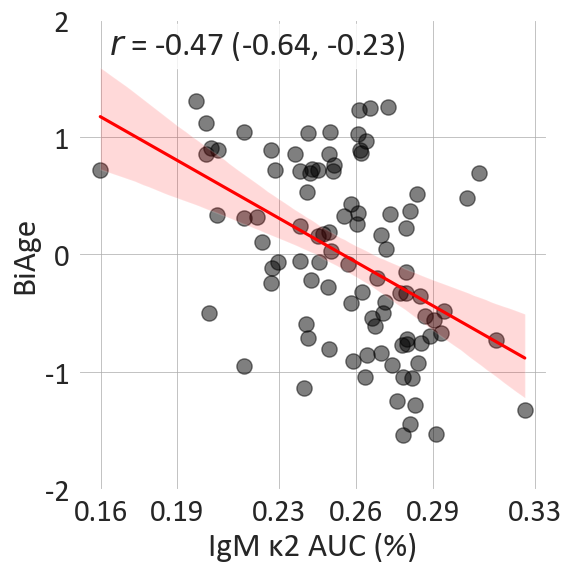

 24%|██▍       | 13/54 [00:00<00:00, 81.77it/s]

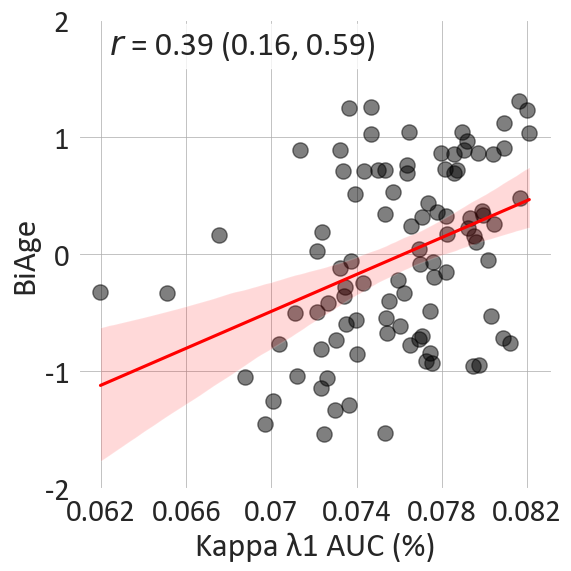

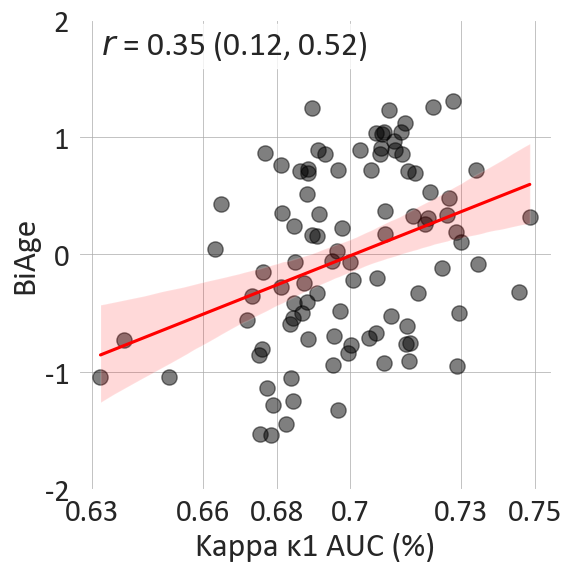

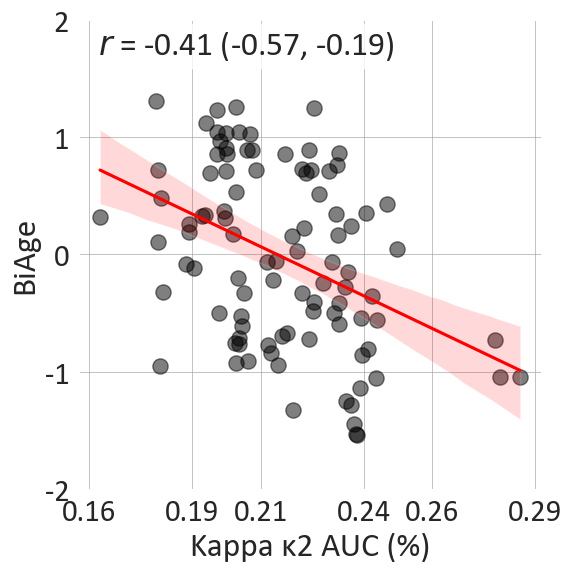

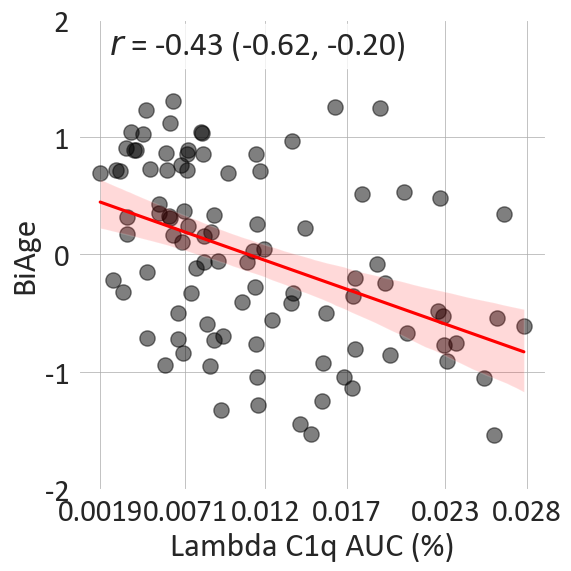

 41%|████      | 22/54 [00:00<00:01, 24.75it/s]

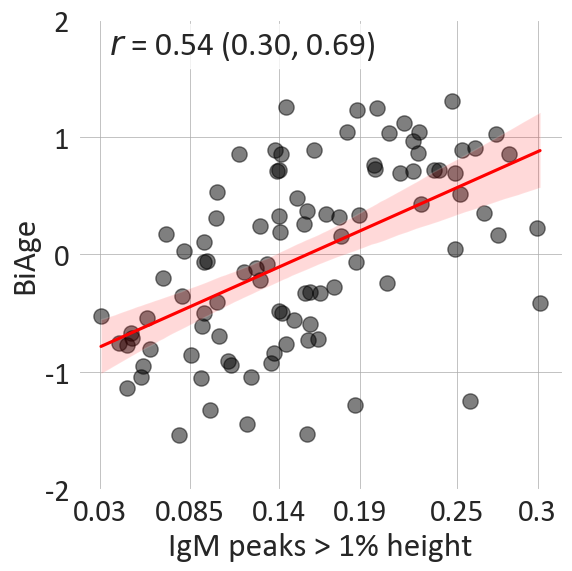

 50%|█████     | 27/54 [00:00<00:01, 26.02it/s]

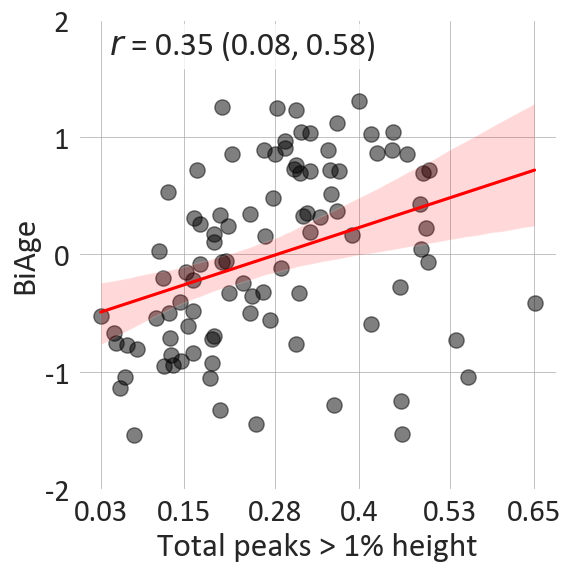

 63%|██████▎   | 34/54 [00:01<00:00, 30.59it/s]

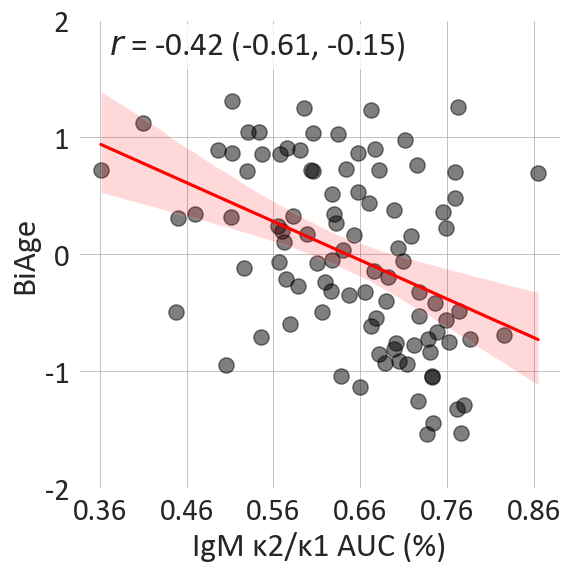

 76%|███████▌  | 41/54 [00:01<00:00, 34.35it/s]

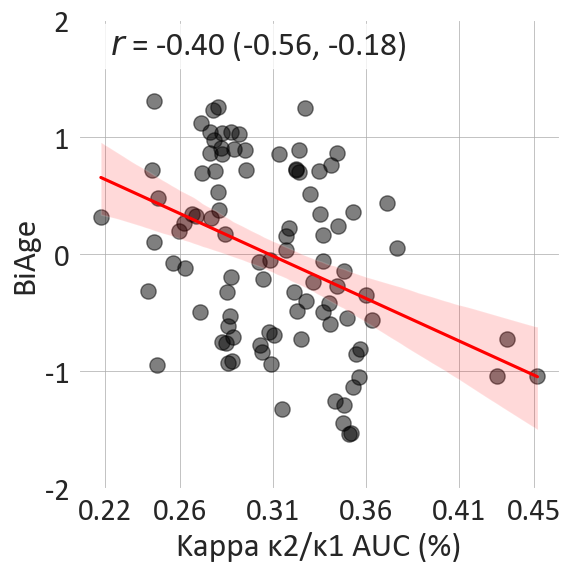

100%|██████████| 54/54 [00:01<00:00, 38.21it/s]


In [81]:
# compute the determination coef (r2) for all variables vs our target variable (age or humoral age)

# FIGURE 1 E

covariates_metric_list = []
for feature in tqdm(candidate_features):
    feature_filename = feature.replace(" >", "").replace("/", "_")
    # get the values of interest
    y = feature_exploration_df[target_score_colname]
    x = trace_features_analysis_df_enriched[feature]
    # check if some variance
    # compute pearson's r
    val_r = scipy.stats.pearsonr(x, y).statistic
    feature_metric = val_r ** 2
    if np.std(x) == 0:
        print(f"Skipping {feature=}: zero-variance")
        covariates_metric_list.append(0)  # put a dummy "zero" value to avoid "nan"'s
        continue
    # save the r2 in a list
    covariates_metric_list.append(feature_metric)
    if (feature_exploration_mode == "qualitative") or (feature_metric < 0.1):  # plot only if r² >= 0.1
        continue
    # prepare the plot
    # create a correlation plot between this feature and the target variable
    plt.figure(figsize=(pp_size, pp_size))
    if target_score_colname == "Age score":
        yticks = [-2, -1, 0, 1, 2]
    elif target_score_colname == "Age":
        yticks = [40, 50, 65, 75]
    xmin, xmax = x.min(), x.max()
    xrange = xmax - xmin
    xticks = np.arange(xmin, xmax + (xrange / 5) / 2, xrange / 5)
    xticks = [float(f"{v:.2g}") for v in xticks]
    plot_lm(x=x, y=y, group_name="Negatives", xticks=xticks, yticks=yticks,
            ylabel="BiAge" if target_score_colname == "Age score" else target_score_colname,
            xlabel=feature,
            text_bbox_alpha=.8,
            text_show_sample_size=False,
            confidence_level=.99)
    plt.tight_layout()
    plt.show()
    
covariates_metric_list = np.array(covariates_metric_list)

From there, we will select all features with a r2 at least > 0.1 and perform recursive feature elimination using a linear model to highlight the independent contribution of each feature

In [82]:
# select our subset of variables of interest
cov_keep_filter = covariates_metric_list > .01
# we'll take all covariates with r² > 0.1
features_kept_for_rfe = [cov for cov, keep in zip(candidate_features, cov_keep_filter) if keep]

print("Number of features selected:")
print(len(features_kept_for_rfe))

# RFE

MODEL_TYPE = "lm"
lm = linear_model.LinearRegression()

y = feature_exploration_df[target_score_colname].to_numpy()
X = trace_features_analysis_df_enriched[features_kept_for_rfe].to_numpy()

# run RFE => manually
features_ranking = np.array([-1, ] * X.shape[1])
with tqdm(total=X.shape[1]) as pbar:
    while True:
        # update progress
        pbar.update()
        # list variables still in competition
        not_already_excluded = np.where(features_ranking == -1)[0]
        if len(not_already_excluded) == 1:
            iter_rank = np.sum(features_ranking == -1)
            features_ranking[not_already_excluded[0]] = iter_rank
            break
        # parse them and compute r2 when removing each of them
        step_results = []
        for k in not_already_excluded:
            iter_X = X[:, [v for v in not_already_excluded if v != k]]
            # iter_metric = np.nan
            if MODEL_TYPE in ["lm", "ridge1e-6"]:
                # just train and test on the same data
                lm.fit(iter_X, y)
                iter_metric = scipy.stats.pearsonr(lm.predict(iter_X), y).statistic ** 2
            elif MODEL_TYPE in ["xgboost"]:
                # train and test on different data (or else we will always have r==1...)
                iter_X_train, iter_X_test, y_train, y_test = train_test_split(iter_X, y, train_size=.8, random_state=1)
                lm.fit(iter_X_train, y_train)
                iter_metric = scipy.stats.pearsonr(lm.predict(iter_X_test), y_test).statistic ** 2
            else:
                assert False, f"Unknown expected behaviour for {MODEL_TYPE=}"
            step_results.append(iter_metric)
        # the variable we want to keep MOST is the variable that when we remove it, we have the worst results (lowest r2)
        # we will remove the variable that when removed gives the best r2 (useless)
        remove_pos = np.argmax(step_results)
        iter_rank = np.sum(features_ranking == -1)
        features_ranking[not_already_excluded[remove_pos]] = iter_rank

Number of features selected:
40


100%|██████████| 40/40 [00:00<00:00, 80.75it/s]


We will then compute the r2 at each stage, i.e. using an increasing number of features with features ordered by their importance in predicting BiAge

In [83]:
# compute r2 at each stage
rfe_results = []
for keep_how_many_variables in range(1, len(features_ranking) + 1)[::-1]:
    iteration_X = X[:, features_ranking <= keep_how_many_variables]
    if MODEL_TYPE in ["lm", "ridge1e-6"]:
        # just train and test on the same data
        lm.fit(iteration_X, y)
        metric = scipy.stats.pearsonr(lm.predict(iteration_X), y).statistic  # ** 2
    elif MODEL_TYPE in ["xgboost"]:
        # train and test on different data (or else we will always have r==1...)
        iter_X_train, iter_X_test, y_train, y_test = train_test_split(iteration_X, y, train_size=.8, random_state=1)
        lm.fit(iter_X_train, y_train)
        metric = scipy.stats.pearsonr(lm.predict(iter_X_test), y_test).statistic  # ** 2
    else:
        assert False, f"Unknown expected behaviour for {MODEL_TYPE=}"
    rfe_results.append(
        {"feature_excluded_after": features_kept_for_rfe[np.where(features_ranking == keep_how_many_variables)[0][0]],
         "n_features": keep_how_many_variables, "r": metric})

rfe_results = pd.DataFrame(rfe_results)
print(rfe_results)

      feature_excluded_after  n_features         r
0          IgM κ1+κ2 AUC (%)          40  0.892061
1          IgA κ1+κ2 AUC (%)          39  0.892061
2          IgM λ1+λ2 AUC (%)          38  0.892061
3                   FLCRATIO          37  0.892061
4         N_Peaks_below_LLMI          36  0.892037
5             IgA κ1 AUC (%)          35  0.891937
6            IgA κ/λ AUC (%)          34  0.891810
7        Kappa κ2/κ1 AUC (%)          33  0.891627
8             IgA λ1 AUC (%)          32  0.891480
9          IgA κ2/κ1 AUC (%)          31  0.891144
10         IgA λ1+λ2 AUC (%)          30  0.890334
11        GAM_Total_Optilite          29  0.890245
12         IgM κ2/κ1 AUC (%)          28  0.889323
13         IgG λ2/λ1 AUC (%)          27  0.888331
14                IUFLCRatio          26  0.887451
15          Kappa κ2 AUC (%)          25  0.885956
16            IgG κ1 AUC (%)          24  0.885040
17            IgG λ2 AUC (%)          23  0.882329
18            IgG κ2 AUC (%)   

Then we can plot the r2 of predicting BiAge from our features, according to the number of features

This is **Figure 1D**

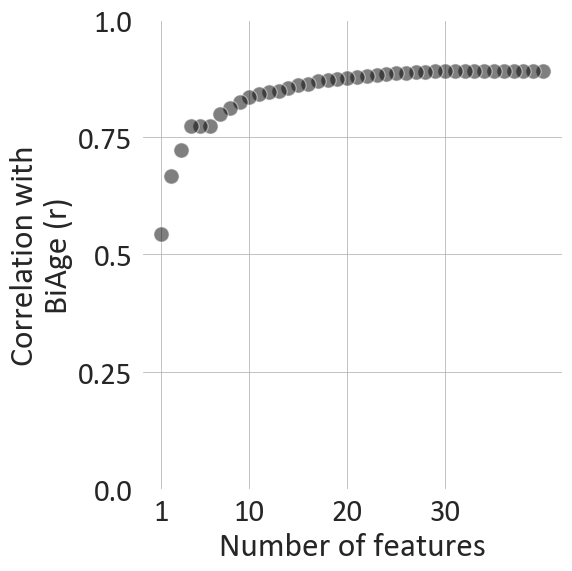

In [84]:
# FIGURE 1 D

plt.figure(figsize=(pp_size, pp_size))
plot_lm(x=rfe_results.n_features, y=rfe_results.r,
        group_name="Features", xlabel="Number of features",
        ylabel=f"Correlation with\n{'BiAge' if target_score_colname == 'Age score' else target_score_colname} (r)",
        text_pos="bottom right",
        yticks=[0., .25, .5, .75, 1.],
        xticks=[1, *np.arange(10, len(rfe_results), 10)],
        text_show=False,
        no_lm=True,
        confidence_level=.99)
plt.tight_layout()
plt.show()

In [85]:
# save results
print(rfe_results)

      feature_excluded_after  n_features         r
0          IgM κ1+κ2 AUC (%)          40  0.892061
1          IgA κ1+κ2 AUC (%)          39  0.892061
2          IgM λ1+λ2 AUC (%)          38  0.892061
3                   FLCRATIO          37  0.892061
4         N_Peaks_below_LLMI          36  0.892037
5             IgA κ1 AUC (%)          35  0.891937
6            IgA κ/λ AUC (%)          34  0.891810
7        Kappa κ2/κ1 AUC (%)          33  0.891627
8             IgA λ1 AUC (%)          32  0.891480
9          IgA κ2/κ1 AUC (%)          31  0.891144
10         IgA λ1+λ2 AUC (%)          30  0.890334
11        GAM_Total_Optilite          29  0.890245
12         IgM κ2/κ1 AUC (%)          28  0.889323
13         IgG λ2/λ1 AUC (%)          27  0.888331
14                IUFLCRatio          26  0.887451
15          Kappa κ2 AUC (%)          25  0.885956
16            IgG κ1 AUC (%)          24  0.885040
17            IgG λ2 AUC (%)          23  0.882329
18            IgG κ2 AUC (%)   

We can plot all top features with r2 > 0.1 in a single plot, which is **Supplementary Figure S6**

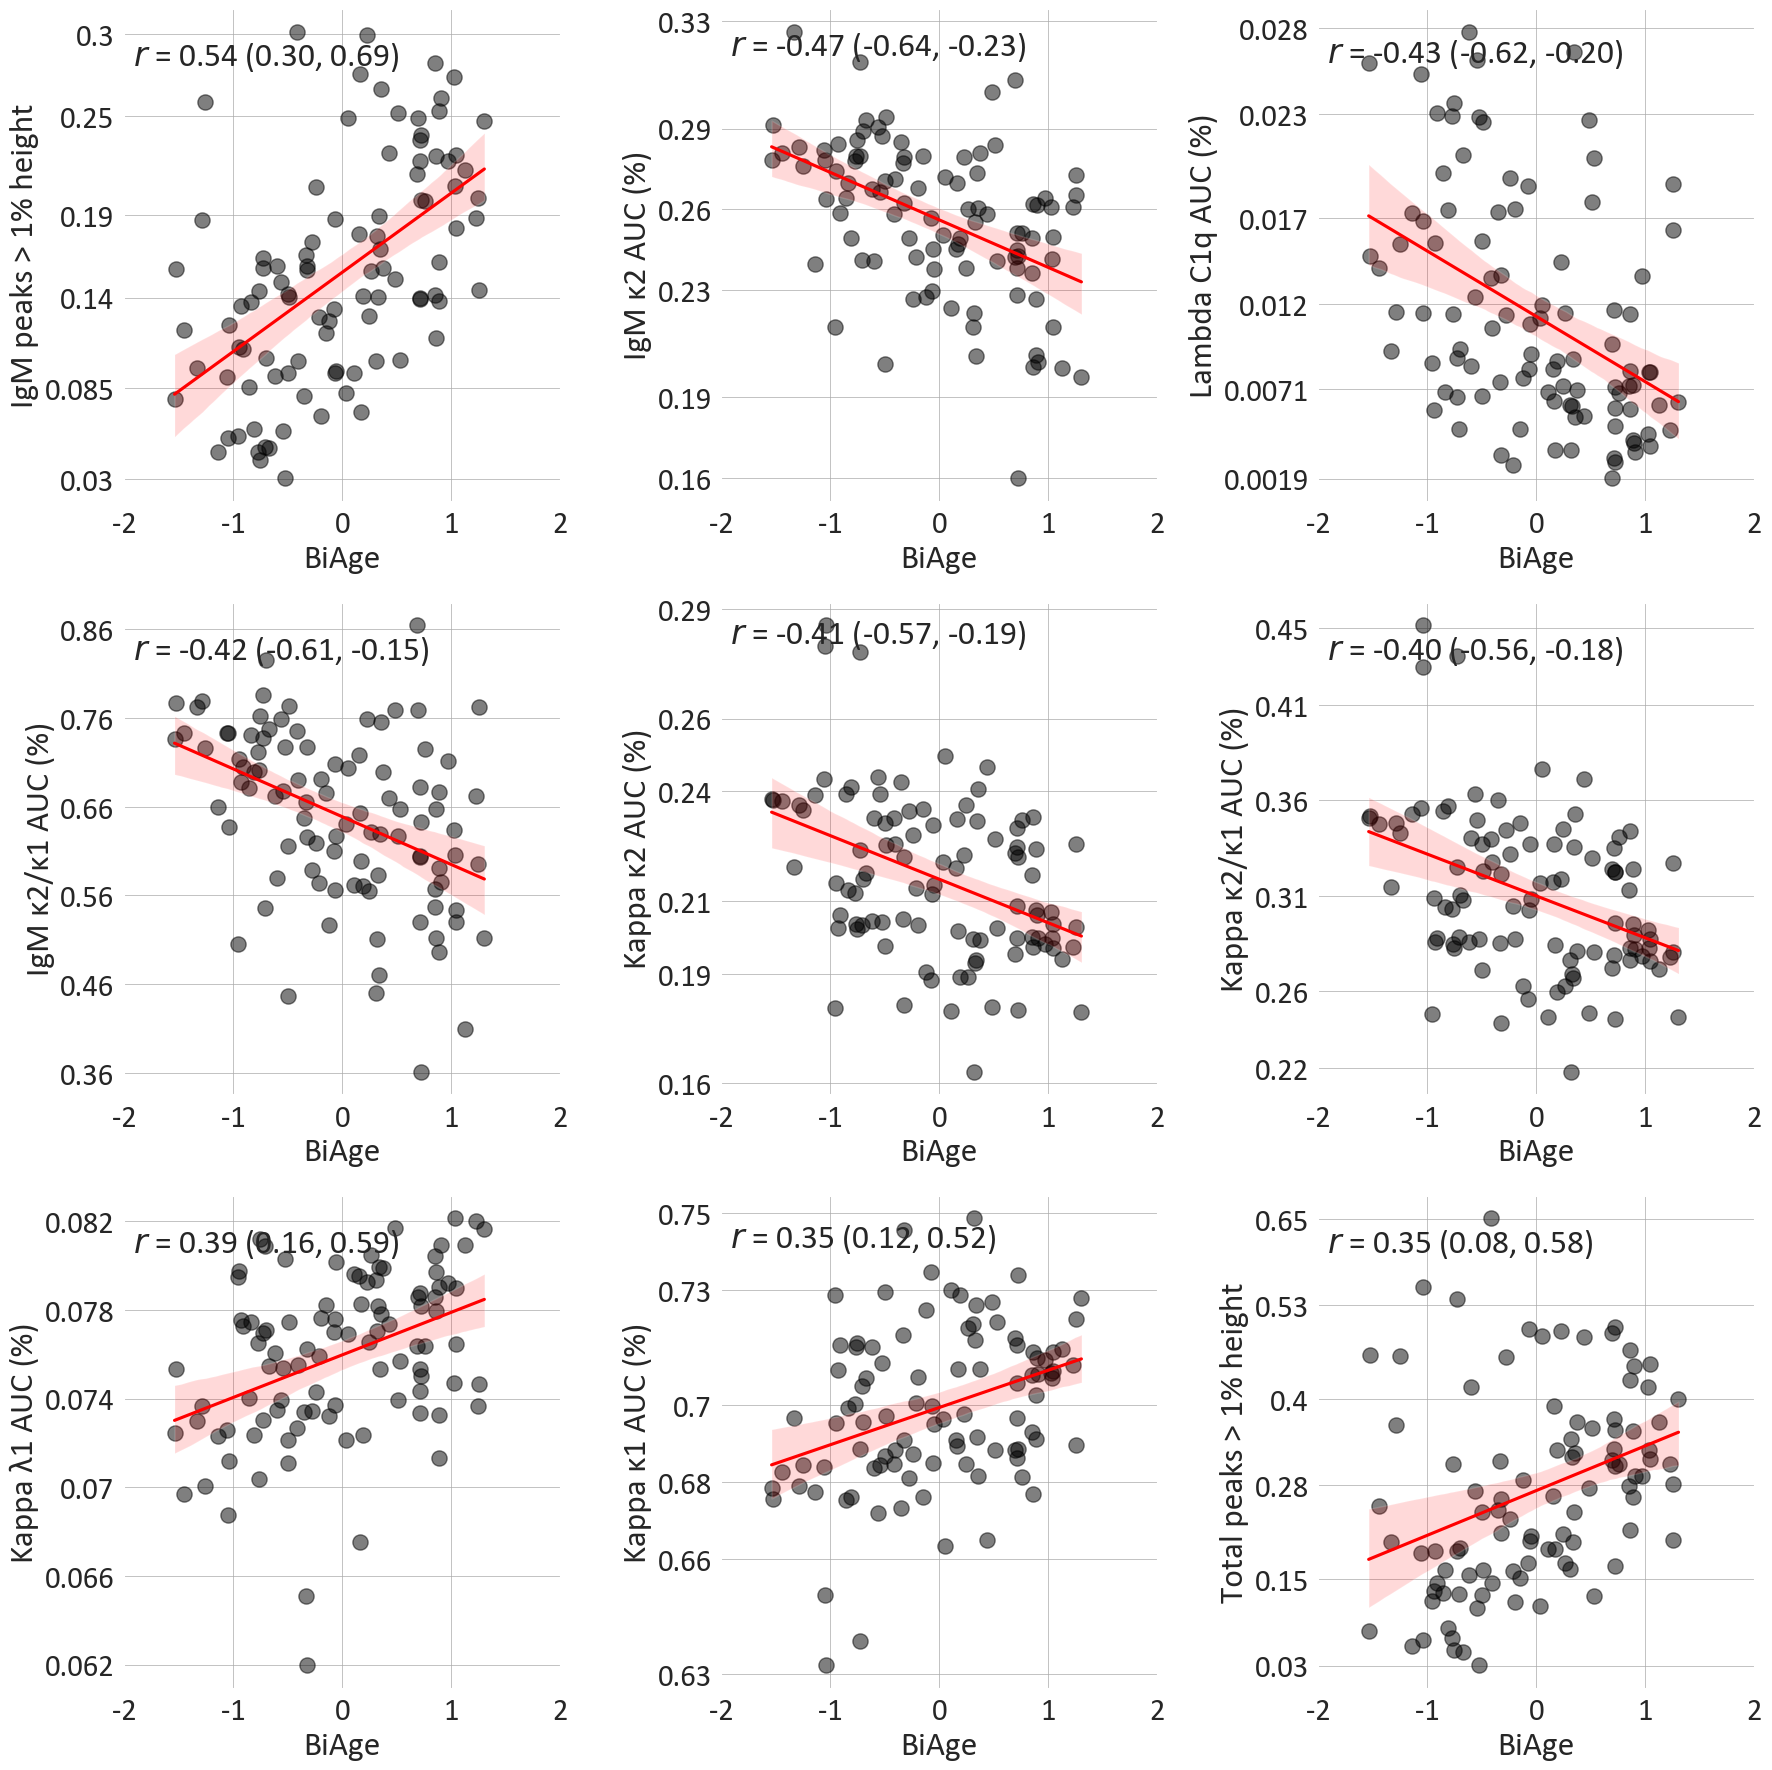

In [86]:
# FIGURE S6

order_by_r2_instead = True
if order_by_r2_instead:
    order = np.argsort(covariates_metric_list[cov_keep_filter])
    ranks = np.argsort(order)
    ranks = len(ranks) - ranks
    features_ranking_kept = ranks
else:
    features_ranking_kept = features_ranking

# np.array(covariates_r2_list)[features_ranking_kept-1]

# plot all covariates, ranked
n_col = 3
n_row = 3
max_n_features = n_col * n_row
plt.figure(figsize=(pp_size * n_col, pp_size * n_row))
for position, rank in enumerate(features_ranking_kept):
    if rank > max_n_features:
        continue
    col = features_kept_for_rfe[position]
    plt.subplot(n_row, n_col, rank)
    x = feature_exploration_df[target_score_colname]
    y = trace_features_analysis_df_enriched[col]
    r = scipy.stats.pearsonr(x, y).statistic
    xticks = [-2, -1, 0, 1, 2] if target_score_colname == "Age score" else [40, 50, 65,
                                                                            75] if target_score_colname == "Age" else None
    ymin, ymax = y.min(), y.max()
    yrange = ymax - ymin
    yticks = np.arange(ymin, ymax + (yrange / 5) / 2, yrange / 5)
    yticks = [float(f"{v:.2g}") for v in yticks]
    plot_lm(x=x, y=y, group_name="Negatives", xticks=xticks, yticks=yticks,
            text_show_sample_size=False,
            xlabel="BiAge" if target_score_colname == "Age score" else "Age" if target_score_colname == "Age" else "?",
            ylabel=col,
            confidence_level=.99)
    # plt.title(f"{position}/{rank}")
plt.tight_layout()
plt.show()

Finally, we can select and example of sample predicted with high BiAge or low BiAge and plot their spectra, overlayed with the gaussian distributions that were extracted (kappa 1, kappa 2, etc.)

First, we will need to design the function responsible of creating this plot for a sample:

In [87]:
def gaussians_pretty_plot(ms_digitized_data_buffer: list, optim_params_buffer: list, optim_params_colors: list,
                          n_isotypes: int, gaussian_names: list,
                          raw_lw: float = .5, reconstructed_lw: float = 1,
                          dalton_scale_in_k: bool = False,
                          plot_gaussians: bool = True,
                          plot_ipsa_residuals: bool = False,
                          trace_peaks_analysis: list = None,
                          show_legend: bool = True, highlight_residual_error: bool = True, show: bool = False):
    """
    Do a pretty plot of gaussian deconvolution results of an MS sample

    :param ms_digitized_data_buffer: output of previous functions used for deconvoluting gaussians
    :param optim_params_buffer: output of previous functions used for deconvoluting gaussians
    :param optim_params_colors: colors of the different gaussians
    :param n_isotypes: number of isotypes, usually 5
    :param gaussian_names: names of the gaussians
    :param raw_lw: width of the raw data line
    :param reconstructed_lw: width of the reconstructed (modelled) data line
    :param dalton_scale_in_k: boolean, whether the m/z scale should be in Dalton or kDa
    :param show_legend: bool, whether to show legend or not
    :param highlight_residual_error: bool, default False, whether to display the area of the reconstruction error
    :param plot_gaussians: bool, whether or not to plot gaussians
    :param plot_ipsa_residuals: whether or not to plot residuals after ipsa smoothing
    :param trace_peaks_analysis: automatically detected peaks data to show, default None
    :param show: bool, default to False; set to True to call plt.show() before returning, keep False so the figure can be saved after executing the routine
    :return:
    """

    LEGEND_RAW_TRACKSHOW = (0,)
    LEGEND_PEAKS_TRACKSHOW = (1,)
    LEGEND_ISO_GAUSSIANS_TRACKSHOW = [[], [], [], [1, 3], [0, 2, 4]]

    # from scipy.ndimage import gaussian_filter

    if highlight_residual_error:
        plt.figure(figsize=(pp_size * 1.6, pp_size * 2.4))
    else:
        plt.figure(figsize=(pp_size * 1.25, pp_size * 2.0))
    for isotype in range(n_isotypes):
        ms_digitized_data = ms_digitized_data_buffer[isotype]
        optim_params = optim_params_buffer[isotype]

        # create the subplot for this isotype (1 new row)
        ax = plt.subplot(5, 1, isotype + 1)

        # plot the raw trace (initially, so it appears first in the legend)
        sns.lineplot(x=ms_digitized_data.iloc[:, 0], y=ms_digitized_data.iloc[:, 1], color="#000000",
                     # label="Raw data" if ((isotype in LEGEND_RAW_TRACKSHOW) and show_legend) else None,
                     lw=raw_lw,
                     ax=ax)
        # FAKE DATA FOR THE LEGEND (so the line width will be a bit thickier)
        if (isotype in LEGEND_RAW_TRACKSHOW) and show_legend:
            sns.lineplot(x=[ms_digitized_data.iloc[0, 0]], y=[ms_digitized_data.iloc[0, 1]],
                         color="#000000", label="Raw data", ax=ax)

        if plot_gaussians:

            # plot the area under each gaussian
            for gaussian_j, param in enumerate(optim_params):
                gmx = model_trace_from_gaussians(ms_digitized_data.iloc[:, 0], [param])
                ax.fill_between(x=ms_digitized_data.iloc[:, 0], y1=gmx, color=optim_params_colors[isotype][gaussian_j], alpha=0.3)
                sns.lineplot(x=ms_digitized_data.iloc[:, 0], y=gmx, color=optim_params_colors[isotype][gaussian_j], ax=ax)
            # and the legend with it if we want it
            if show_legend:
                for gaussian_j in LEGEND_ISO_GAUSSIANS_TRACKSHOW[isotype]:
                    # FAKE INVISILBE DATA FOR LEGEND
                    sns.lineplot(x=[ms_digitized_data.iloc[0, 0]], y=[ms_digitized_data.iloc[0, 1]],
                                 color=optim_params_colors[isotype][gaussian_j], label=gaussian_names[isotype][gaussian_j] + " distribution", ax=ax)

            ggmx = model_trace_from_gaussians(ms_digitized_data.iloc[:, 0], optim_params)

            # plot the residual error
            if highlight_residual_error:
                ax.fill_between(x=ms_digitized_data.iloc[:, 0],
                                y1=np.minimum(ggmx.to_numpy(), ms_digitized_data.iloc[:, 1].to_numpy()),
                                y2=np.maximum(ggmx.to_numpy(), ms_digitized_data.iloc[:, 1].to_numpy()),
                                color="#ff0000", alpha=0.9)
                if show_legend:
                    # FAKE INVISIBLE FOR LEGEND
                    sns.lineplot(x=[ms_digitized_data.iloc[0, 0]], y=[ms_digitized_data.iloc[0, 1]],
                                 color="#ff0000", lw=3, label="Reconstruction error")

            # plot ipsa residual error
            if plot_ipsa_residuals:
                x_ipsa = ipsa_baseline(x_track=np.stack([ms_digitized_data.iloc[:, 0].values,
                                                         ms_digitized_data.iloc[:, 1].values], axis=0))

                residuals = ms_digitized_data.iloc[:, 1].values - x_ipsa[1, ...]
                residuals = np.abs(residuals)

                ircolor = "#ff0000"
                sns.lineplot(x=ms_digitized_data.iloc[:, 0], y=residuals, color=ircolor, ax=ax)
                if show_legend:
                    # FAKE INVISILBE DATA FOR LEGEND
                    sns.lineplot(x=[ms_digitized_data.iloc[0, 0]], y=[ms_digitized_data.iloc[0, 1]], color=ircolor, label="Residuals (IPSA)", ax=ax)

            # show automatically detected peaks
            if trace_peaks_analysis is not None:
                # trace_peaks_analysis["peaks_data"][isotype]
                # sns.lineplot(x=ms_digitized_data.iloc[:, 0],
                #              y=np.maximum(trace_peaks_analysis["residuals"][isotype], 0),
                #              color="#ff0000", ax=ax)
                for peak_center_pos in trace_peaks_analysis["peaks_data"][isotype][0]:
                    pos_start = peak_center_pos - 10
                    pos_end = peak_center_pos + 10
                    ax.fill_between(x=ms_digitized_data.iloc[pos_start:pos_end, 0],
                                    y1=trace_peaks_analysis["x_ipsa"][isotype][pos_start:pos_end],
                                    y2=ms_digitized_data.iloc[pos_start:pos_end, 1],
                                    color="#ff0000", alpha=0.3)
                if (isotype in LEGEND_PEAKS_TRACKSHOW) and show_legend:
                    # FAKE INVISILBE DATA FOR LEGEND
                    sns.lineplot(x=[ms_digitized_data.iloc[0, 0]], y=[ms_digitized_data.iloc[0, 1]], color="#ff0000", label="Low s/n peaks",
                                 lw=3, alpha=.3, ax=ax)

            # plot the GMM baseline
            sns.lineplot(x=ms_digitized_data.iloc[:, 0], y=ggmx, color="#aaaaaa", label="Modelled" if ((isotype in LEGEND_RAW_TRACKSHOW) and show_legend) else None, lw=reconstructed_lw, ax=ax)

            # plot the raw trace (again, so it appears OVER the other distributions)
            sns.lineplot(x=ms_digitized_data.iloc[:, 0], y=ms_digitized_data.iloc[:, 1], color="#000000", lw=raw_lw, ax=ax)

        if isotype == (n_isotypes - 1):  # last (bottom most) track: show x axis
            plt.xticks([10900, 11700, 12500])
            xticks = ax.get_xticks()
            if dalton_scale_in_k:
                xticks = [f"{v / 1000:.1f}k" for v in xticks]
            ax.set_xticklabels(xticks, fontdict=ticks_font_params)
            plt.xlabel("m/z", **labels_font_params)
        else:  # other tracks: do not show legend
            plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            ax.set(xlabel=None)

        plt.yticks([0, .5, 1.])
        yticks = ax.get_yticks()
        yticks = (yticks * 100).astype(int)
        ax.set_yticklabels(yticks, fontdict=ticks_font_params)
        if isotype < 3:
            iso_name = f"Ig{'GAM'[isotype]}"
        elif isotype == 3:
            iso_name = "κ"
        elif isotype == 4:
            iso_name = "λ"
        else:
            iso_name = None
        plt.ylabel(f"{iso_name} relative\nabundance (%)", **labels_font_params)

    plt.tight_layout()
    if show:
        plt.show()
        

def features_plot(match_id: str, figure_path: str):
    """
    plot an example of trace with features decomposed

    :param match_id:
    :param figure_path:
    :return:
    """
    ms_digitized_data_buffer, optim_params_buffer, rmse = deconvolute_gaussians_v2(dataset_path=dataset_dir,
                                                                                   match_id=match_id,
                                                                                   p_keys=P_KEYS,
                                                                                   gaussians=DEFAULT_GAUSSIANS,
                                                                                   n_isotypes=len(DEFAULT_ISOTYPES),
                                                                                   harcoded_params=DEFAULT_HARDCODED_PARAMS,
                                                                                   init_global_params=DEFAULT_INIT_GLOBAL_PARAMS,
                                                                                   global_params_bounds=DEFAULT_GLOBAL_PARAMS_BOUNDS,
                                                                                   return_rmse=True)

    trace_peaks_analysis = peak_detection_v3(dataset_path=dataset_dir, match_id=match_id,
                                             peak_height_threshold=.01)

    gaussians_pretty_plot(ms_digitized_data_buffer=ms_digitized_data_buffer,
                          optim_params_buffer=optim_params_buffer,
                          optim_params_colors=DEFAULT_PARAM_COLORS,
                          gaussian_names=DEFAULT_GAUSSIAN_NAMES,
                          highlight_residual_error=False,
                          plot_ipsa_residuals=False,
                          trace_peaks_analysis=trace_peaks_analysis,
                          n_isotypes=len(DEFAULT_ISOTYPES),
                          show=False)

    plt.show()

Then, we can loop through all samples which we used for feature exploration, and plot the spectra for the sample with highest BiAge and lowest BiAge

This is **Figure 1C**

Lowest BiAge first:

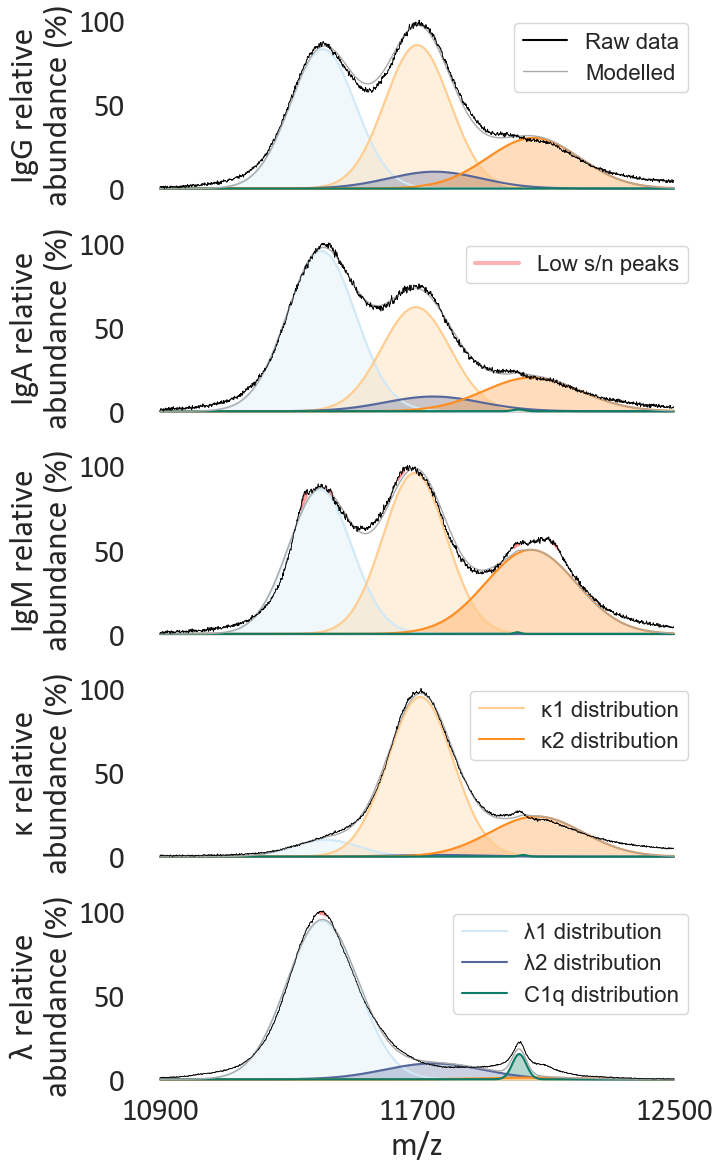

In [88]:
features_plot(match_id=feature_exploration_df.sort_values("Age score").iloc[0]["ANON_ID"], figure_path=None)

Then highest BiAge:

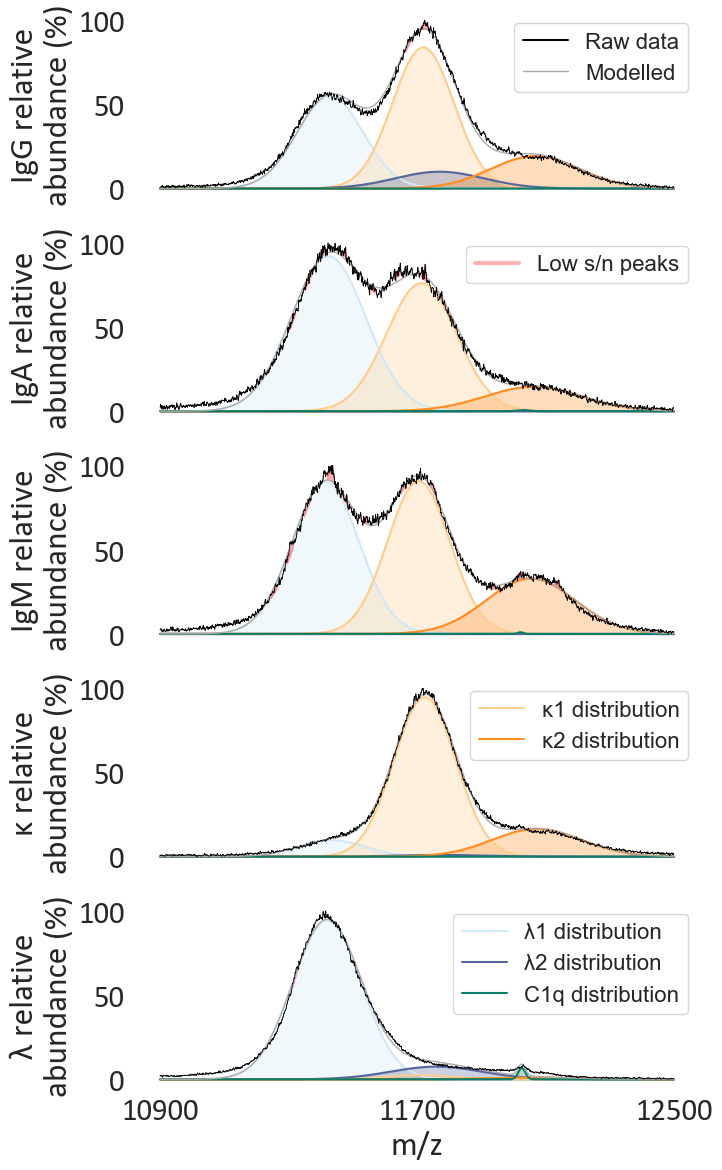

In [89]:
features_plot(match_id=feature_exploration_df.sort_values("Age score", ascending=False).iloc[0]["ANON_ID"], figure_path=None)